In [6]:
import numpy as np
import math
import matplotlib.pyplot as plt  
from sklearn.metrics import mean_squared_error
import pandas as pd

from keras.layers import Dropout
from keras.layers import Dense,Input
from keras.models import Sequential,Model
from keras.callbacks import EarlyStopping
import numpy

import sys
import xlwt
##get data##
import MySQLdb
from sklearn.preprocessing import MinMaxScaler


def transfromData(trainRaw, testRaw,windosSize):  ##Train ratial, train, test
    sc = MinMaxScaler(feature_range = (0, 1))
    #npRaw = np.array(rawData)
    #scaledData = sc.fit_transform(npRaw.reshape(-1,1))  
    #trainData = np.array(scaledData[:trainCount]).reshape(-1,1)##train 
    #testData = np.array(scaledData[-testCount:]).reshape(-1,1)
    
    npTrain = sc.fit_transform(np.array(trainRaw).reshape(-1,1))
    npTest = sc.fit_transform(np.array(trainRaw).reshape(-1,1))
    

    X_train, y_train = splitXy(npTrain,windosSize)
    X_test, y_test = splitXy(npTest,windosSize)
    return sc, X_train, y_train, X_test, y_test

def splitXy(data,windosSize):
    windows = []
    for i in range(windosSize, data.shape[0]):
        windows.append(data[i-windosSize:i, 0])
    np.random.shuffle(windows)
    X = []
    y = []
    for i in range(len(windows)):
        X.append(windows[i][:windosSize-1])
        y.append(windows[i][-1:])
    X, y = np.array(X), np.array(y)
    #X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X,y
def buildModel():
    dnn_1_input = Input(shape=(6,),name='dnn_1_input')
    dnn_1 = Dense(128,activation="tanh", name='dnn_1')(dnn_1_input)
    dnn_2 = Dense(64,activation="tanh", name='dnn_2')(dnn_1)
    dnn_3 = Dense(32,activation="tanh", name='dnn_3')(dnn_2)
    dnn_4 = Dense(1, activation='tanh', name='dnn_4')(dnn_3)

    model = Model(dnn_1_input,dnn_4)
    model.summary()
    model.compile(loss='mse',
                  optimizer='adam')
    return model
def getStationList(cursor):
    stationList = []
    queryString = "SELECT distinct station from cleandata"
    cursor.execute(queryString)
    results = cursor.fetchall()
    for row in results :
        val = str(row).strip("',()")
        stationList.append(val)
    stationList.remove('富貴角')##only 106少數資料
    return stationList
def Visualize():
    predicted = sc.inverse_transform(regressor.predict(X_test))
    originY = sc.inverse_transform (y_test)
    print("MSE : ["+str(mean_squared_error(predicted, originY))+"]")
    # Visualising the results
    plt.plot(originY[:100], color = 'red', label = 'Real')  
    plt.plot(predicted[:100], color = 'blue', label = 'Predicted ') 
    plt.legend()
    plt.show()
def writeExcelHead(sheet1,epochs,station):
    sheet1.write(0,1,station)
    raw = 1
    for e in range(epochs):
        sheet1.write(raw,0,e+1)
        raw+=1


def fetchData(cursor,station,windosSize):
    queryString = "SELECT * from cleandata where station='"+station+"' and item = 'PM2.5' and date NOT like '2017%'"
    cursor.execute(queryString)
    results = cursor.fetchall()

    trainRawData = []
    for row in results:
        for i in range(3,27):
            trainRawData.append(float(row[i]))
            
    queryString = "SELECT * from cleandata where station='"+station+"' and item = 'PM2.5' and date like '2017%'"
    cursor.execute(queryString)
    results = cursor.fetchall()

    testRawData = []
    for row in results:
        for i in range(3,27):
            testRawData.append(float(row[i]))

    sc, X_train, y_train, X_test, y_test = transfromData(trainRawData,testRawData,windosSize)
    return sc, X_train, y_train, X_test, y_test
def train(regressor,sc, X_train, y_train, X_test, y_test,epochs):
    patient = 50
    p_cnt = 0
    prev_mse = 0.0
    mseList = []
    for i in range(epochs):
        regressor.fit(X_train, y_train,validation_split=0.2, epochs = 1, batch_size = 32,verbose=2)
        predicted = sc.inverse_transform(regressor.predict(X_test))
        originY = sc.inverse_transform (y_test)
        mse = mean_squared_error(predicted, originY)
        mseList.append(mse)
        if prev_mse < mse:
            p_cnt += 1
        if prev_mse >mse :
            p_cnt -= 1
        print("Epoch : " +str(i)+", MSE : ["+str(mse)+"]")
        print('-------------------------------------------')
        prev_mse = mse
    
        if p_cnt > 50 :
            break
    plt.plot(mseList, color = 'blue', label = 'MSEs ') 
    plt.legend()
    plt.show()
    return mseList

training : 二林
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 1s - loss: 9.5358e-04 - val_loss: 8.0908e-04
Epoch : 0, MSE : 

 - 1s - loss: 7.4651e-04 - val_loss: 7.5875e-04
Epoch : 38, MSE : [41.608877848740526]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 1s - loss: 7.4769e-04 - val_loss: 7.6730e-04
Epoch : 39, MSE : [41.603295330660714]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 1s - loss: 7.4425e-04 - val_loss: 7.7066e-04
Epoch : 40, MSE : [41.778863482331]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 1s - loss: 7.4667e-04 - val_loss: 8.1377e-04
Epoch : 41, MSE : [43.185017320469136]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 1s - loss: 7.4524e-04 - val_loss: 8.3779e-04
Epoch : 42, MSE : [45.443438556585576]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 0s - loss: 7.5293e-04 - val_loss: 7.5769e-04
Epoch

 - 1s - loss: 7.2879e-04 - val_loss: 7.7584e-04
Epoch : 82, MSE : [42.44681248261118]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 1s - loss: 7.2883e-04 - val_loss: 7.4143e-04
Epoch : 83, MSE : [40.362488895847015]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 1s - loss: 7.2719e-04 - val_loss: 7.6897e-04
Epoch : 84, MSE : [41.380328910218445]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 1s - loss: 7.3154e-04 - val_loss: 7.6288e-04
Epoch : 85, MSE : [41.769233862863885]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 1s - loss: 7.3410e-04 - val_loss: 7.4604e-04
Epoch : 86, MSE : [40.636674283234925]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 1s - loss: 7.3017e-04 - val_loss: 7.4638e-04
Epo

Epoch : 125, MSE : [41.56370721926207]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 1s - loss: 7.2075e-04 - val_loss: 7.9240e-04
Epoch : 126, MSE : [43.21007055919863]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 1s - loss: 7.1823e-04 - val_loss: 7.2592e-04
Epoch : 127, MSE : [39.740078435212666]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 1s - loss: 7.1778e-04 - val_loss: 7.3732e-04
Epoch : 128, MSE : [40.75233924481341]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 1s - loss: 7.1914e-04 - val_loss: 7.4052e-04
Epoch : 129, MSE : [40.45674090865372]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 1s - loss: 7.1619e-04 - val_loss: 7.4460e-04
Epoch : 130, MSE : [41.099052337501085]
---------

 - 1s - loss: 7.1730e-04 - val_loss: 7.5735e-04
Epoch : 169, MSE : [42.19124536550279]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 1s - loss: 7.1510e-04 - val_loss: 7.1849e-04
Epoch : 170, MSE : [39.72052620916643]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 1s - loss: 7.0967e-04 - val_loss: 7.1485e-04
Epoch : 171, MSE : [39.36386925745136]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 1s - loss: 7.0822e-04 - val_loss: 7.1697e-04
Epoch : 172, MSE : [39.634367284792205]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 1s - loss: 7.0898e-04 - val_loss: 7.2210e-04
Epoch : 173, MSE : [39.74907175585891]
-------------------------------------------
Train on 17140 samples, validate on 4285 samples
Epoch 1/1
 - 0s - loss: 7.1009e-04 - val_loss: 7.2485e-04
E

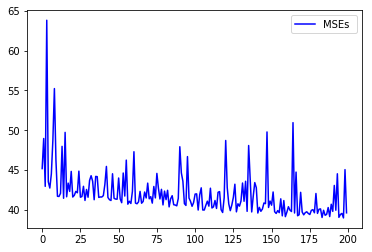

check point at 2019-04-25 10:42:53.713253
training : 南投
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 9.9970e-0

 - 1s - loss: 6.6696e-04 - val_loss: 6.2370e-04
Epoch : 38, MSE : [19.53724267023511]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 6.6799e-04 - val_loss: 5.9951e-04
Epoch : 39, MSE : [19.030953396257424]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 6.7269e-04 - val_loss: 6.6697e-04
Epoch : 40, MSE : [21.28355918210837]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 6.7218e-04 - val_loss: 6.2679e-04
Epoch : 41, MSE : [19.860485476648826]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 6.5253e-04 - val_loss: 6.3038e-04
Epoch : 42, MSE : [20.21338598262152]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 6.6139e-04 - val_loss: 6.1719e-04
Epoch

Epoch : 81, MSE : [20.27458381260321]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 6.4404e-04 - val_loss: 5.8388e-04
Epoch : 82, MSE : [18.57722274550792]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 6.4401e-04 - val_loss: 6.1704e-04
Epoch : 83, MSE : [19.31288403346814]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 6.4163e-04 - val_loss: 5.7839e-04
Epoch : 84, MSE : [18.387190377862904]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 6.4530e-04 - val_loss: 5.8526e-04
Epoch : 85, MSE : [18.74717562638485]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 6.3483e-04 - val_loss: 5.9255e-04
Epoch : 86, MSE : [18.6702041680388]
-----------------

 - 1s - loss: 6.3202e-04 - val_loss: 6.0836e-04
Epoch : 125, MSE : [19.086875798233052]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 6.3167e-04 - val_loss: 6.1047e-04
Epoch : 126, MSE : [19.379392347192464]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 6.3223e-04 - val_loss: 5.8664e-04
Epoch : 127, MSE : [18.667914624769956]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 6.3505e-04 - val_loss: 6.1806e-04
Epoch : 128, MSE : [19.474201537799765]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 6.3873e-04 - val_loss: 5.8341e-04
Epoch : 129, MSE : [18.531820701153528]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 6.3174e-04 - val_loss: 5.9517e-

 - 1s - loss: 6.3083e-04 - val_loss: 5.8110e-04
Epoch : 168, MSE : [18.360245050772985]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 6.3059e-04 - val_loss: 5.9627e-04
Epoch : 169, MSE : [18.766344370895915]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 6.3275e-04 - val_loss: 5.7831e-04
Epoch : 170, MSE : [18.348992979281686]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 6.2498e-04 - val_loss: 5.9827e-04
Epoch : 171, MSE : [18.991749898481853]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 6.2706e-04 - val_loss: 5.8983e-04
Epoch : 172, MSE : [18.843533310543236]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 6.2827e-04 - val_loss: 5.6972e-

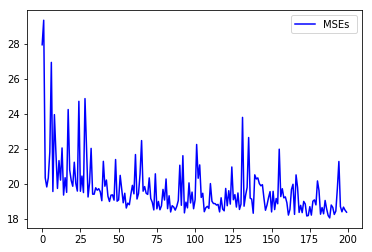

check point at 2019-04-25 10:46:26.814170
training : 埔里
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 2s - loss: 4.0955e-0

 - 1s - loss: 2.2297e-04 - val_loss: 2.1955e-04
Epoch : 38, MSE : [21.847343222988602]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 2.2001e-04 - val_loss: 2.2970e-04
Epoch : 39, MSE : [23.193667234647954]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 2.1981e-04 - val_loss: 2.1777e-04
Epoch : 40, MSE : [21.714494831150205]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 2.2289e-04 - val_loss: 2.1134e-04
Epoch : 41, MSE : [21.54544575294154]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 2.2361e-04 - val_loss: 2.1478e-04
Epoch : 42, MSE : [21.441662947350324]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 2.2038e-04 - val_loss: 2.1671e-04
Epo

Epoch : 81, MSE : [22.856123913904124]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 2.1645e-04 - val_loss: 2.2895e-04
Epoch : 82, MSE : [21.64520708664804]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 2.1819e-04 - val_loss: 2.2477e-04
Epoch : 83, MSE : [22.373618294766406]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 2.1718e-04 - val_loss: 2.1498e-04
Epoch : 84, MSE : [21.96185142201394]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 2.1919e-04 - val_loss: 2.1908e-04
Epoch : 85, MSE : [22.096781915563664]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 2.1620e-04 - val_loss: 2.2163e-04
Epoch : 86, MSE : [22.16894031321297]
--------------

 - 1s - loss: 2.1648e-04 - val_loss: 3.0529e-04
Epoch : 125, MSE : [29.725568259142914]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 2.1637e-04 - val_loss: 2.1411e-04
Epoch : 126, MSE : [21.295679301759325]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 2.1485e-04 - val_loss: 2.1336e-04
Epoch : 127, MSE : [21.036715813147858]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 2.1587e-04 - val_loss: 2.4024e-04
Epoch : 128, MSE : [23.075684409840566]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 2.1468e-04 - val_loss: 2.1724e-04
Epoch : 129, MSE : [21.32436020245408]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 2.1372e-04 - val_loss: 2.2608e-0

 - 1s - loss: 2.1153e-04 - val_loss: 2.2116e-04
Epoch : 168, MSE : [21.81017175617686]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 2.1334e-04 - val_loss: 2.1825e-04
Epoch : 169, MSE : [21.91497817056466]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 2.1008e-04 - val_loss: 2.1981e-04
Epoch : 170, MSE : [22.241766922445464]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 2.1408e-04 - val_loss: 2.1807e-04
Epoch : 171, MSE : [21.57456588166423]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 2.1074e-04 - val_loss: 2.1697e-04
Epoch : 172, MSE : [21.28711806970485]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 2.1421e-04 - val_loss: 2.2194e-04
E

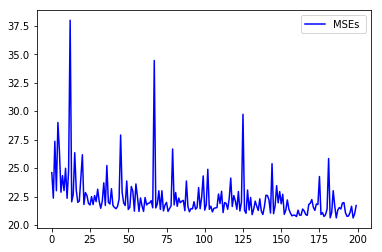

check point at 2019-04-25 10:49:55.730455
training : 大里
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 1s - loss: 0.0016 - 

Epoch : 39, MSE : [38.4292263736102]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 0s - loss: 0.0012 - val_loss: 0.0012
Epoch : 40, MSE : [38.46430353980671]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 1s - loss: 0.0012 - val_loss: 0.0012
Epoch : 41, MSE : [37.78776067320279]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 1s - loss: 0.0012 - val_loss: 0.0012
Epoch : 42, MSE : [38.32357579441158]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 1s - loss: 0.0012 - val_loss: 0.0012
Epoch : 43, MSE : [38.27445366711274]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 1s - loss: 0.0012 - val_loss: 0.0012
Epoch : 44, MSE : [38.075037452465374]
-------------------------------------------
Train on 1610

 - 1s - loss: 0.0012 - val_loss: 0.0012
Epoch : 85, MSE : [38.030569624500444]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 1s - loss: 0.0012 - val_loss: 0.0014
Epoch : 86, MSE : [43.3095968189936]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 1s - loss: 0.0012 - val_loss: 0.0012
Epoch : 87, MSE : [37.53766604244707]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 1s - loss: 0.0012 - val_loss: 0.0012
Epoch : 88, MSE : [38.824117768078516]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 1s - loss: 0.0012 - val_loss: 0.0013
Epoch : 89, MSE : [39.27222329925977]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 1s - loss: 0.0012 - val_loss: 0.0012
Epoch : 90, MSE : [37.976350993463264]
---------------

Epoch : 130, MSE : [38.35602905112139]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 1s - loss: 0.0012 - val_loss: 0.0013
Epoch : 131, MSE : [41.72079394719406]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 1s - loss: 0.0012 - val_loss: 0.0012
Epoch : 132, MSE : [37.22494472991287]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 1s - loss: 0.0012 - val_loss: 0.0012
Epoch : 133, MSE : [37.72753721866576]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 1s - loss: 0.0012 - val_loss: 0.0012
Epoch : 134, MSE : [38.72867306567555]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 1s - loss: 0.0012 - val_loss: 0.0013
Epoch : 135, MSE : [38.928079309895445]
-------------------------------------------
Train 

Epoch : 175, MSE : [38.53969667689209]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 1s - loss: 0.0012 - val_loss: 0.0012
Epoch : 176, MSE : [37.717380551029244]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch : 177, MSE : [39.393281092880365]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 1s - loss: 0.0011 - val_loss: 0.0012
Epoch : 178, MSE : [37.66922275059153]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 1s - loss: 0.0012 - val_loss: 0.0012
Epoch : 179, MSE : [38.05175162711038]
-------------------------------------------
Train on 16103 samples, validate on 4026 samples
Epoch 1/1
 - 1s - loss: 0.0012 - val_loss: 0.0013
Epoch : 180, MSE : [38.99426247515853]
-------------------------------------------
Train

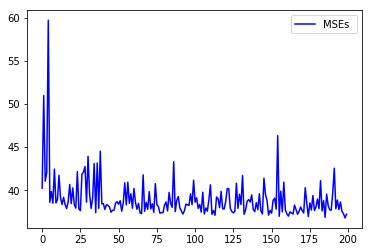

check point at 2019-04-25 10:52:35.921958
training : 彰化
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 1s - loss: 0.0018 - 

 - 1s - loss: 9.7992e-04 - val_loss: 8.7364e-04
Epoch : 38, MSE : [34.19998063250809]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 1s - loss: 9.7180e-04 - val_loss: 8.7997e-04
Epoch : 39, MSE : [34.464842263865705]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 1s - loss: 9.8082e-04 - val_loss: 9.0926e-04
Epoch : 40, MSE : [35.30819390836699]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 1s - loss: 9.8625e-04 - val_loss: 8.8177e-04
Epoch : 41, MSE : [34.33781217843301]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 1s - loss: 9.7161e-04 - val_loss: 8.9057e-04
Epoch : 42, MSE : [34.783832866067534]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 1s - loss: 9.8548e-04 - val_loss: 8.7461e-04
Epoch

 - 1s - loss: 9.3246e-04 - val_loss: 9.0132e-04
Epoch : 82, MSE : [34.49478453126482]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 1s - loss: 9.2986e-04 - val_loss: 8.6279e-04
Epoch : 83, MSE : [33.21400380490055]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 1s - loss: 9.3152e-04 - val_loss: 9.6624e-04
Epoch : 84, MSE : [36.852416512116655]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 1s - loss: 9.3118e-04 - val_loss: 8.9071e-04
Epoch : 85, MSE : [34.27320697767273]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 1s - loss: 9.2605e-04 - val_loss: 8.6722e-04
Epoch : 86, MSE : [33.36379680559844]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 1s - loss: 9.2719e-04 - val_loss: 8.8440e-04
Epoch 

Epoch : 125, MSE : [34.17036875749311]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 1s - loss: 9.0783e-04 - val_loss: 8.7416e-04
Epoch : 126, MSE : [33.6850193015793]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 1s - loss: 9.1069e-04 - val_loss: 8.5664e-04
Epoch : 127, MSE : [32.3882202952881]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 1s - loss: 9.1420e-04 - val_loss: 8.6059e-04
Epoch : 128, MSE : [32.99564657546271]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 1s - loss: 9.0888e-04 - val_loss: 8.3465e-04
Epoch : 129, MSE : [32.10731365095357]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 1s - loss: 9.1276e-04 - val_loss: 8.5006e-04
Epoch : 130, MSE : [32.408710584953916]
------------

 - 1s - loss: 8.9514e-04 - val_loss: 8.3771e-04
Epoch : 169, MSE : [32.329355985802785]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 1s - loss: 8.9497e-04 - val_loss: 8.7903e-04
Epoch : 170, MSE : [33.74346715944588]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 1s - loss: 9.0217e-04 - val_loss: 8.3374e-04
Epoch : 171, MSE : [31.947274153768664]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 1s - loss: 8.9957e-04 - val_loss: 9.0467e-04
Epoch : 172, MSE : [34.38557942787656]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 1s - loss: 8.9559e-04 - val_loss: 9.0931e-04
Epoch : 173, MSE : [35.19418414565796]
-------------------------------------------
Train on 20384 samples, validate on 5097 samples
Epoch 1/1
 - 1s - loss: 8.9408e-04 - val_loss: 8.3891e-04


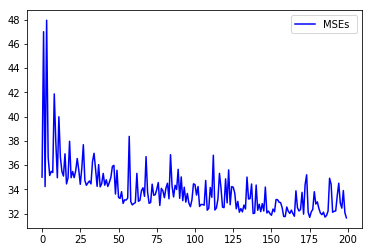

check point at 2019-04-25 10:55:57.278857
training : 忠明
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 1s - loss: 0.0016 - 

Epoch : 39, MSE : [30.275959608491917]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch : 40, MSE : [29.91378817762341]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 1s - loss: 0.0011 - val_loss: 0.0012
Epoch : 41, MSE : [31.968081132844322]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch : 42, MSE : [30.052238999160892]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch : 43, MSE : [29.992026558640845]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch : 44, MSE : [30.021822324950854]
-------------------------------------------
Train on

 - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch : 85, MSE : [31.048322498794814]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch : 86, MSE : [29.60003592872275]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch : 87, MSE : [29.91198220750132]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 1s - loss: 0.0011 - val_loss: 0.0012
Epoch : 88, MSE : [31.335013839459965]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch : 89, MSE : [30.525950545001724]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch : 90, MSE : [30.681408607896387]
-------------

 - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch : 130, MSE : [29.740099288253035]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch : 131, MSE : [29.900785681407143]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch : 132, MSE : [30.671869059766752]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch : 133, MSE : [30.220384632441938]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch : 134, MSE : [30.274695446657216]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 1s - loss: 0.0011 - val_loss: 0.0012
Epoch : 135, MSE : [32.07828287127954]
------

 - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch : 175, MSE : [30.52043651307142]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch : 176, MSE : [30.747804242569295]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch : 177, MSE : [30.0959477604895]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch : 178, MSE : [29.814213618294154]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch : 179, MSE : [29.50705842486119]
-------------------------------------------
Train on 21076 samples, validate on 5269 samples
Epoch 1/1
 - 1s - loss: 0.0011 - val_loss: 0.0012
Epoch : 180, MSE : [31.658711064778565]
---------

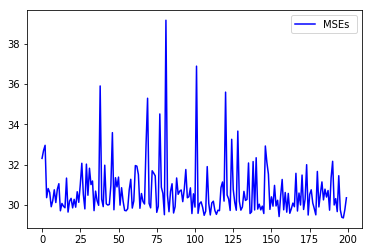

check point at 2019-04-25 10:59:32.283888
training : 沙鹿
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 2s - loss: 5.8647e-0

 - 1s - loss: 4.7247e-04 - val_loss: 4.8657e-04
Epoch : 38, MSE : [27.31235264029225]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 1s - loss: 4.7465e-04 - val_loss: 4.8245e-04
Epoch : 39, MSE : [27.161155414506762]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 1s - loss: 4.7787e-04 - val_loss: 5.5775e-04
Epoch : 40, MSE : [31.491089521846682]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 1s - loss: 4.7589e-04 - val_loss: 4.8751e-04
Epoch : 41, MSE : [27.38245513752794]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 1s - loss: 4.7308e-04 - val_loss: 4.8471e-04
Epoch : 42, MSE : [27.25591065624239]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 1s - loss: 4.6827e-04 - val_loss: 5.0122e-04
Epoch

Epoch : 81, MSE : [27.541982682666212]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 1s - loss: 4.5775e-04 - val_loss: 4.5541e-04
Epoch : 82, MSE : [25.582513760458276]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 1s - loss: 4.5698e-04 - val_loss: 4.5531e-04
Epoch : 83, MSE : [25.586538415287862]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 1s - loss: 4.6140e-04 - val_loss: 4.6023e-04
Epoch : 84, MSE : [25.861202403007397]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 1s - loss: 4.6099e-04 - val_loss: 4.7497e-04
Epoch : 85, MSE : [26.5203336094831]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 1s - loss: 4.5601e-04 - val_loss: 4.8607e-04
Epoch : 86, MSE : [27.52114269468948]
--------------

 - 1s - loss: 4.5219e-04 - val_loss: 4.5577e-04
Epoch : 125, MSE : [25.453987510289675]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 1s - loss: 4.5347e-04 - val_loss: 4.8329e-04
Epoch : 126, MSE : [27.485703682898684]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 1s - loss: 4.5386e-04 - val_loss: 5.0734e-04
Epoch : 127, MSE : [28.03966059432887]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 1s - loss: 4.5182e-04 - val_loss: 4.9646e-04
Epoch : 128, MSE : [27.894176508982362]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 1s - loss: 4.5229e-04 - val_loss: 4.8556e-04
Epoch : 129, MSE : [27.392077690324285]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 1s - loss: 4.5316e-04 - val_loss: 4.5104e-0

 - 1s - loss: 4.4865e-04 - val_loss: 4.8248e-04
Epoch : 168, MSE : [27.367742407442993]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 1s - loss: 4.5096e-04 - val_loss: 4.6956e-04
Epoch : 169, MSE : [26.04862145505433]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 1s - loss: 4.5111e-04 - val_loss: 4.6022e-04
Epoch : 170, MSE : [25.93115820959347]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 1s - loss: 4.4674e-04 - val_loss: 4.5237e-04
Epoch : 171, MSE : [25.38238179909493]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 1s - loss: 4.4580e-04 - val_loss: 5.0673e-04
Epoch : 172, MSE : [28.441409173001674]
-------------------------------------------
Train on 21978 samples, validate on 5495 samples
Epoch 1/1
 - 1s - loss: 4.4731e-04 - val_loss: 4.8363e-04


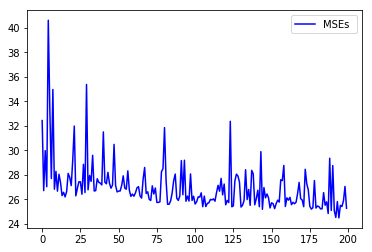

check point at 2019-04-25 11:03:24.608932
training : 竹山
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 2s - loss: 0.0021 - 

 - 1s - loss: 9.9145e-04 - val_loss: 9.0181e-04
Epoch : 39, MSE : [24.775459887645212]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 1s - loss: 9.8751e-04 - val_loss: 9.5943e-04
Epoch : 40, MSE : [26.19057798253828]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 1s - loss: 9.8391e-04 - val_loss: 8.8623e-04
Epoch : 41, MSE : [24.00110543588782]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 1s - loss: 9.7907e-04 - val_loss: 8.7967e-04
Epoch : 42, MSE : [24.22597614726201]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 1s - loss: 9.7722e-04 - val_loss: 8.5445e-04
Epoch : 43, MSE : [23.362322064969995]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 1s - loss: 9.7275e-04 - val_loss: 8.9947e-04
Epoch

Epoch : 82, MSE : [24.305648259833873]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 1s - loss: 9.6424e-04 - val_loss: 8.5949e-04
Epoch : 83, MSE : [23.401475511895782]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 1s - loss: 9.7150e-04 - val_loss: 8.3891e-04
Epoch : 84, MSE : [22.88848779020678]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 1s - loss: 9.7019e-04 - val_loss: 8.3637e-04
Epoch : 85, MSE : [22.830356304154446]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 1s - loss: 9.6504e-04 - val_loss: 9.4699e-04
Epoch : 86, MSE : [25.645927027147874]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 1s - loss: 9.6928e-04 - val_loss: 9.1786e-04
Epoch : 87, MSE : [24.724767068034968]
------------

 - 1s - loss: 9.5978e-04 - val_loss: 8.3275e-04
Epoch : 126, MSE : [22.63876233279618]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 1s - loss: 9.4849e-04 - val_loss: 8.2883e-04
Epoch : 127, MSE : [22.52637503152906]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 1s - loss: 9.5626e-04 - val_loss: 9.8259e-04
Epoch : 128, MSE : [26.449508909998126]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 1s - loss: 9.4966e-04 - val_loss: 9.0877e-04
Epoch : 129, MSE : [24.546282527664356]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 1s - loss: 9.5986e-04 - val_loss: 8.2161e-04
Epoch : 130, MSE : [22.410148177195563]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 1s - loss: 9.5138e-04 - val_loss: 8.7923e-04

 - 1s - loss: 9.5058e-04 - val_loss: 8.1906e-04
Epoch : 169, MSE : [22.381074899205643]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 1s - loss: 9.4521e-04 - val_loss: 8.2038e-04
Epoch : 170, MSE : [22.37412670199508]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 1s - loss: 9.4590e-04 - val_loss: 8.3212e-04
Epoch : 171, MSE : [22.61688544695016]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 1s - loss: 9.4933e-04 - val_loss: 8.3145e-04
Epoch : 172, MSE : [22.514717337942656]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 1s - loss: 9.4708e-04 - val_loss: 8.7524e-04
Epoch : 173, MSE : [23.714340391664166]
-------------------------------------------
Train on 21805 samples, validate on 5452 samples
Epoch 1/1
 - 1s - loss: 9.4666e-04 - val_loss: 8.4067e-04

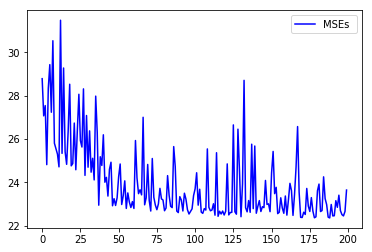

check point at 2019-04-25 11:07:25.262780
training : 線西
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 2s - loss: 3.3597e-0

 - 1s - loss: 2.5502e-04 - val_loss: 2.3056e-04
Epoch : 38, MSE : [27.772631086861093]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 2.5527e-04 - val_loss: 2.2542e-04
Epoch : 39, MSE : [27.174005355432357]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 2.5364e-04 - val_loss: 2.2158e-04
Epoch : 40, MSE : [26.451612508721514]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 2.5448e-04 - val_loss: 2.1674e-04
Epoch : 41, MSE : [25.95171961268289]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 2.5539e-04 - val_loss: 2.1790e-04
Epoch : 42, MSE : [26.10325422690228]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 2.5140e-04 - val_loss: 2.2709e-04
Epoc

Epoch : 81, MSE : [27.755362295276704]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 2.5040e-04 - val_loss: 2.1195e-04
Epoch : 82, MSE : [25.841085346861515]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 2.5009e-04 - val_loss: 2.2161e-04
Epoch : 83, MSE : [26.75267497150012]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 2.5222e-04 - val_loss: 2.1454e-04
Epoch : 84, MSE : [26.1353703758052]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 2.5224e-04 - val_loss: 2.2125e-04
Epoch : 85, MSE : [27.160133241361144]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 2.5419e-04 - val_loss: 2.9291e-04
Epoch : 86, MSE : [34.936254484854516]
--------------

 - 1s - loss: 2.5112e-04 - val_loss: 2.1460e-04
Epoch : 125, MSE : [26.13488215244615]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 2.5036e-04 - val_loss: 2.1369e-04
Epoch : 126, MSE : [26.439989394713685]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 2.5032e-04 - val_loss: 2.1175e-04
Epoch : 127, MSE : [25.877905690556695]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 2.4959e-04 - val_loss: 2.0829e-04
Epoch : 128, MSE : [25.455207152737415]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 2.5029e-04 - val_loss: 2.1211e-04
Epoch : 129, MSE : [26.318620710462003]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 2.5016e-04 - val_loss: 2.3058e-0

 - 1s - loss: 2.4969e-04 - val_loss: 2.0635e-04
Epoch : 168, MSE : [25.372925244795827]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 2.4961e-04 - val_loss: 2.1341e-04
Epoch : 169, MSE : [26.343288824793415]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 2.4843e-04 - val_loss: 2.1032e-04
Epoch : 170, MSE : [26.062732344919247]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 2.4828e-04 - val_loss: 2.1048e-04
Epoch : 171, MSE : [26.089525068685514]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 2.4768e-04 - val_loss: 2.0571e-04
Epoch : 172, MSE : [25.358722915145645]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 2.4840e-04 - val_loss: 2.0498e-

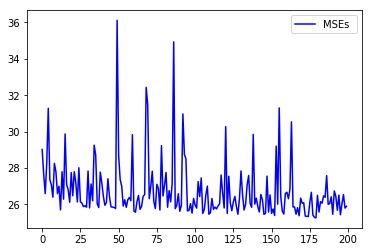

check point at 2019-04-25 11:11:35.055090
training : 西屯
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 2s - loss: 0.0010 - 

 - 1s - loss: 8.1606e-04 - val_loss: 8.1873e-04
Epoch : 38, MSE : [29.041326491699618]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 8.3489e-04 - val_loss: 7.8374e-04
Epoch : 39, MSE : [27.54819292245172]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 8.2561e-04 - val_loss: 7.9943e-04
Epoch : 40, MSE : [28.199413921149425]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 8.1976e-04 - val_loss: 8.0114e-04
Epoch : 41, MSE : [28.025389371176576]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 8.2197e-04 - val_loss: 8.0506e-04
Epoch : 42, MSE : [28.669351372985346]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 8.1422e-04 - val_loss: 8.0019e-04
Epo

Epoch : 81, MSE : [28.824273835935152]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 8.1570e-04 - val_loss: 7.8259e-04
Epoch : 82, MSE : [27.502100220336313]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 8.1357e-04 - val_loss: 7.8871e-04
Epoch : 83, MSE : [27.991443684257586]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 8.1820e-04 - val_loss: 7.7517e-04
Epoch : 84, MSE : [27.399511724435047]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 8.1646e-04 - val_loss: 8.1478e-04
Epoch : 85, MSE : [28.399232309141237]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 8.1872e-04 - val_loss: 7.8298e-04
Epoch : 86, MSE : [27.476987532522354]
-----------

 - 1s - loss: 8.0345e-04 - val_loss: 8.0349e-04
Epoch : 125, MSE : [28.170245854643543]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 8.1458e-04 - val_loss: 7.9166e-04
Epoch : 126, MSE : [28.02486823614035]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 8.0784e-04 - val_loss: 7.9510e-04
Epoch : 127, MSE : [27.799704750406573]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 8.0330e-04 - val_loss: 7.8827e-04
Epoch : 128, MSE : [27.733534328578145]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 8.0558e-04 - val_loss: 8.2663e-04
Epoch : 129, MSE : [29.223649750566274]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 8.0376e-04 - val_loss: 8.2469e-0

 - 1s - loss: 8.0059e-04 - val_loss: 7.9503e-04
Epoch : 168, MSE : [27.728481594097577]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 8.0648e-04 - val_loss: 8.2235e-04
Epoch : 169, MSE : [28.93359704382516]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 7.9945e-04 - val_loss: 8.8913e-04
Epoch : 170, MSE : [30.82293383895418]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 8.0465e-04 - val_loss: 7.8203e-04
Epoch : 171, MSE : [27.381918257012778]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 7.9994e-04 - val_loss: 8.4094e-04
Epoch : 172, MSE : [29.843472419690894]
-------------------------------------------
Train on 22074 samples, validate on 5519 samples
Epoch 1/1
 - 1s - loss: 8.0225e-04 - val_loss: 8.1180e-04

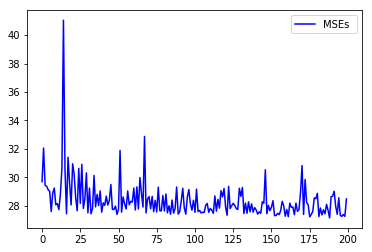

check point at 2019-04-25 11:15:39.490287
training : 豐原
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 1s - loss: 9.7037e-0

 - 1s - loss: 8.0822e-04 - val_loss: 9.9204e-04
Epoch : 38, MSE : [48.92660747216566]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 1s - loss: 8.0361e-04 - val_loss: 7.5606e-04
Epoch : 39, MSE : [37.88378213849359]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 1s - loss: 8.0465e-04 - val_loss: 7.6047e-04
Epoch : 40, MSE : [38.555859310150105]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 1s - loss: 8.0405e-04 - val_loss: 8.1550e-04
Epoch : 41, MSE : [40.5412166272239]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 1s - loss: 7.9550e-04 - val_loss: 7.6386e-04
Epoch : 42, MSE : [38.43658945138649]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 1s - loss: 8.0260e-04 - val_loss: 7.7832e-04
Epoch :

 - 1s - loss: 7.9532e-04 - val_loss: 8.1211e-04
Epoch : 82, MSE : [40.54427857963304]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 1s - loss: 7.9259e-04 - val_loss: 7.5411e-04
Epoch : 83, MSE : [38.04849609457859]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 1s - loss: 7.9336e-04 - val_loss: 8.4198e-04
Epoch : 84, MSE : [43.045891005189304]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 0s - loss: 7.9821e-04 - val_loss: 8.2197e-04
Epoch : 85, MSE : [41.855722364951994]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 1s - loss: 8.0328e-04 - val_loss: 7.8711e-04
Epoch : 86, MSE : [39.17643338027565]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 1s - loss: 7.9647e-04 - val_loss: 7.7288e-04
Epoch

Epoch : 125, MSE : [37.551536467009946]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 1s - loss: 7.9797e-04 - val_loss: 7.6103e-04
Epoch : 126, MSE : [37.99744331448147]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 1s - loss: 7.8872e-04 - val_loss: 7.4566e-04
Epoch : 127, MSE : [37.728914943149455]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 1s - loss: 7.9658e-04 - val_loss: 7.5349e-04
Epoch : 128, MSE : [37.83878328352942]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 1s - loss: 7.8995e-04 - val_loss: 7.4614e-04
Epoch : 129, MSE : [37.66312148924089]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 1s - loss: 7.9597e-04 - val_loss: 7.6622e-04
Epoch : 130, MSE : [38.40960423049948]
---------

 - 1s - loss: 7.8914e-04 - val_loss: 7.4450e-04
Epoch : 169, MSE : [37.62515785185039]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 1s - loss: 7.9544e-04 - val_loss: 7.9643e-04
Epoch : 170, MSE : [39.57923369841801]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 1s - loss: 7.9266e-04 - val_loss: 7.7488e-04
Epoch : 171, MSE : [38.483225732295]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 1s - loss: 7.9429e-04 - val_loss: 7.4828e-04
Epoch : 172, MSE : [37.53256170665122]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 1s - loss: 7.8996e-04 - val_loss: 7.8772e-04
Epoch : 173, MSE : [39.992208592932705]
-------------------------------------------
Train on 14720 samples, validate on 3681 samples
Epoch 1/1
 - 1s - loss: 7.9196e-04 - val_loss: 7.6549e-04
Epo

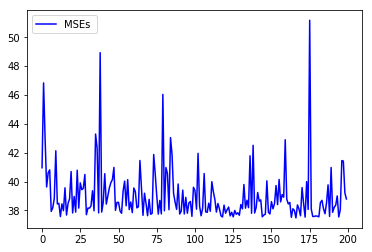

check point at 2019-04-25 11:18:26.571783
training : 三重
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 2s - loss: 0.0014 - 

 - 1s - loss: 9.4380e-04 - val_loss: 9.8717e-04
Epoch : 38, MSE : [26.27791766730825]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 1s - loss: 9.4870e-04 - val_loss: 0.0010
Epoch : 39, MSE : [27.56102760994035]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 1s - loss: 9.4762e-04 - val_loss: 9.5065e-04
Epoch : 40, MSE : [25.451918285780884]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 1s - loss: 9.4534e-04 - val_loss: 9.6852e-04
Epoch : 41, MSE : [25.971850954667307]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 1s - loss: 9.4270e-04 - val_loss: 9.6812e-04
Epoch : 42, MSE : [25.98779430244137]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 1s - loss: 9.4894e-04 - val_loss: 9.5904e-04
Epoch : 4

 - 1s - loss: 9.3553e-04 - val_loss: 9.9071e-04
Epoch : 82, MSE : [26.40015708495179]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 1s - loss: 9.3955e-04 - val_loss: 9.3570e-04
Epoch : 83, MSE : [25.08905517476393]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 1s - loss: 9.3476e-04 - val_loss: 9.3517e-04
Epoch : 84, MSE : [25.12518141664101]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 1s - loss: 9.3059e-04 - val_loss: 9.3823e-04
Epoch : 85, MSE : [25.127153280734223]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 1s - loss: 9.3528e-04 - val_loss: 9.3584e-04
Epoch : 86, MSE : [25.341626701418903]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 1s - loss: 9.4045e-04 - val_loss: 9.4197e-04
Epoch

Epoch : 125, MSE : [28.355007684267402]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 1s - loss: 9.2328e-04 - val_loss: 9.2828e-04
Epoch : 126, MSE : [24.998093866490457]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 1s - loss: 9.2278e-04 - val_loss: 9.7621e-04
Epoch : 127, MSE : [26.2317753445063]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 1s - loss: 9.2614e-04 - val_loss: 9.3389e-04
Epoch : 128, MSE : [24.883402260486804]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 1s - loss: 9.2130e-04 - val_loss: 9.3139e-04
Epoch : 129, MSE : [25.053280467147527]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 1s - loss: 9.2595e-04 - val_loss: 9.3622e-04
Epoch : 130, MSE : [25.04081321306367]
--------

 - 1s - loss: 9.2053e-04 - val_loss: 9.4636e-04
Epoch : 169, MSE : [25.097343709718132]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 1s - loss: 9.1495e-04 - val_loss: 0.0010
Epoch : 170, MSE : [27.006113091526988]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 1s - loss: 9.1458e-04 - val_loss: 9.5850e-04
Epoch : 171, MSE : [25.389113783102044]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 1s - loss: 9.1650e-04 - val_loss: 9.7198e-04
Epoch : 172, MSE : [25.782212121977253]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 1s - loss: 9.1410e-04 - val_loss: 9.4031e-04
Epoch : 173, MSE : [25.236387889004252]
-------------------------------------------
Train on 22842 samples, validate on 5711 samples
Epoch 1/1
 - 1s - loss: 9.1708e-04 - val_loss: 9.8650e-04
E

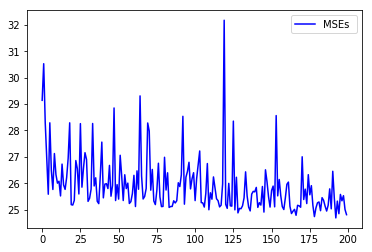

check point at 2019-04-25 11:22:50.177452
training : 中壢
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 2s - loss: 9.0034e-0

 - 1s - loss: 7.5730e-04 - val_loss: 7.7239e-04
Epoch : 38, MSE : [25.26290593855945]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 1s - loss: 7.6421e-04 - val_loss: 7.8139e-04
Epoch : 39, MSE : [25.543190318002488]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 1s - loss: 7.5215e-04 - val_loss: 7.9619e-04
Epoch : 40, MSE : [25.921361654232676]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 1s - loss: 7.5280e-04 - val_loss: 7.7229e-04
Epoch : 41, MSE : [25.14503798197946]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 1s - loss: 7.5690e-04 - val_loss: 7.7884e-04
Epoch : 42, MSE : [25.345059467171467]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 1s - loss: 7.5976e-04 - val_loss: 7.9069e-04
Epoc

 - 1s - loss: 7.4808e-04 - val_loss: 8.7753e-04
Epoch : 82, MSE : [28.90301715940913]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 1s - loss: 7.4808e-04 - val_loss: 7.7806e-04
Epoch : 83, MSE : [25.440824579665303]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 1s - loss: 7.4796e-04 - val_loss: 7.8545e-04
Epoch : 84, MSE : [25.65494703534874]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 1s - loss: 7.5154e-04 - val_loss: 7.7014e-04
Epoch : 85, MSE : [25.10848742982923]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 1s - loss: 7.5029e-04 - val_loss: 8.0975e-04
Epoch : 86, MSE : [26.43344403265928]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 1s - loss: 7.4471e-04 - val_loss: 7.7128e-04
Epoch 

Epoch : 125, MSE : [25.23393653478913]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 1s - loss: 7.4599e-04 - val_loss: 8.2801e-04
Epoch : 126, MSE : [27.158684287060158]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 1s - loss: 7.4367e-04 - val_loss: 7.8846e-04
Epoch : 127, MSE : [25.80734025139751]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 1s - loss: 7.4294e-04 - val_loss: 7.8061e-04
Epoch : 128, MSE : [25.607001340954284]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 1s - loss: 7.4537e-04 - val_loss: 7.5524e-04
Epoch : 129, MSE : [24.737253913301313]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 1s - loss: 7.4203e-04 - val_loss: 7.7552e-04
Epoch : 130, MSE : [25.301807557360714]
-------

Epoch : 168, MSE : [24.92894476587336]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 1s - loss: 7.4579e-04 - val_loss: 7.7180e-04
Epoch : 169, MSE : [25.343518705975477]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 1s - loss: 7.3962e-04 - val_loss: 7.7104e-04
Epoch : 170, MSE : [25.26526962112434]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 1s - loss: 7.4079e-04 - val_loss: 7.6467e-04
Epoch : 171, MSE : [25.163252743647902]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 1s - loss: 7.4093e-04 - val_loss: 7.6907e-04
Epoch : 172, MSE : [25.3073778791004]
-------------------------------------------
Train on 22900 samples, validate on 5725 samples
Epoch 1/1
 - 1s - loss: 7.3762e-04 - val_loss: 7.5842e-04
Epoch : 173, MSE : [24.778177328821165]
---------

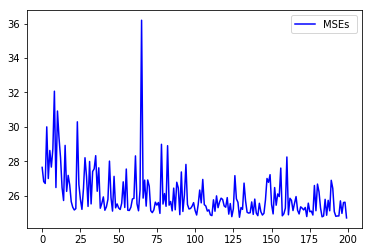

check point at 2019-04-25 11:27:32.773728
training : 中山
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 2s - loss: 0.0013 - 

 - 1s - loss: 0.0010 - val_loss: 9.5945e-04
Epoch : 39, MSE : [25.778331057950325]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 9.7026e-04
Epoch : 40, MSE : [25.837238538433436]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 0.0010
Epoch : 41, MSE : [27.477214576425766]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 9.6655e-04
Epoch : 42, MSE : [25.98455191382567]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 9.6463e-04
Epoch : 43, MSE : [25.90717618378531]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 9.8867e-04
Epoch : 44, MSE : [26.5017970292

 - 1s - loss: 0.0010 - val_loss: 0.0011
Epoch : 84, MSE : [28.595624530408152]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 9.2394e-04
Epoch : 85, MSE : [24.76819086184767]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 1s - loss: 9.9735e-04 - val_loss: 9.2082e-04
Epoch : 86, MSE : [24.75932385872471]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 1s - loss: 9.8750e-04 - val_loss: 9.8695e-04
Epoch : 87, MSE : [26.426791311126852]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 1s - loss: 9.9645e-04 - val_loss: 9.2115e-04
Epoch : 88, MSE : [24.687532454340865]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 1s - loss: 9.9209e-04 - val_loss: 9.1809e-04
Epoch : 89, MSE 

Epoch : 127, MSE : [24.301295477383565]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 1s - loss: 9.6773e-04 - val_loss: 9.1367e-04
Epoch : 128, MSE : [24.414060862724433]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 1s - loss: 9.8131e-04 - val_loss: 9.7578e-04
Epoch : 129, MSE : [26.08797525550645]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 1s - loss: 9.7509e-04 - val_loss: 9.1162e-04
Epoch : 130, MSE : [24.412247552425896]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 1s - loss: 9.7510e-04 - val_loss: 9.1961e-04
Epoch : 131, MSE : [24.611933125703146]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 1s - loss: 9.7060e-04 - val_loss: 9.3061e-04
Epoch : 132, MSE : [24.84133533597145]
-------

 - 1s - loss: 9.5400e-04 - val_loss: 0.0010
Epoch : 171, MSE : [26.64283664666847]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 1s - loss: 9.5888e-04 - val_loss: 8.9945e-04
Epoch : 172, MSE : [23.976328373171434]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 1s - loss: 9.5649e-04 - val_loss: 8.9679e-04
Epoch : 173, MSE : [23.97113272390176]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 1s - loss: 9.5934e-04 - val_loss: 9.1261e-04
Epoch : 174, MSE : [24.29710387035087]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 1s - loss: 9.5641e-04 - val_loss: 8.9976e-04
Epoch : 175, MSE : [24.043052907275005]
-------------------------------------------
Train on 15412 samples, validate on 3853 samples
Epoch 1/1
 - 1s - loss: 9.5583e-04 - val_loss: 9.0516e-04
Epoc

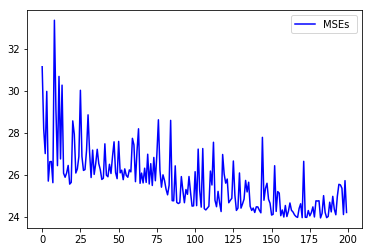

check point at 2019-04-25 11:30:42.047825
training : 古亭
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 2s - loss: 0.0013 - 

 - 1s - loss: 8.8899e-04 - val_loss: 8.4014e-04
Epoch : 38, MSE : [23.6438723503231]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 1s - loss: 8.9212e-04 - val_loss: 8.6215e-04
Epoch : 39, MSE : [24.001620050468308]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 1s - loss: 8.8982e-04 - val_loss: 8.5831e-04
Epoch : 40, MSE : [23.945132198890768]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 1s - loss: 8.9666e-04 - val_loss: 8.4754e-04
Epoch : 41, MSE : [23.75558323246793]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 1s - loss: 8.9380e-04 - val_loss: 8.5338e-04
Epoch : 42, MSE : [23.77003937410486]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 1s - loss: 8.8563e-04 - val_loss: 9.0132e-04
Epoch 

Epoch : 81, MSE : [25.326592082564073]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 1s - loss: 8.7983e-04 - val_loss: 8.4236e-04
Epoch : 82, MSE : [23.425257090856974]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 1s - loss: 8.9382e-04 - val_loss: 8.3830e-04
Epoch : 83, MSE : [23.377398520321062]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 1s - loss: 8.8187e-04 - val_loss: 8.4677e-04
Epoch : 84, MSE : [23.536402912111097]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 1s - loss: 8.7891e-04 - val_loss: 8.6353e-04
Epoch : 85, MSE : [24.202353118342753]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 1s - loss: 8.8118e-04 - val_loss: 8.4462e-04
Epoch : 86, MSE : [23.595174728345423]
-----------

 - 1s - loss: 8.7067e-04 - val_loss: 8.6560e-04
Epoch : 125, MSE : [24.21532660321147]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 1s - loss: 8.7235e-04 - val_loss: 8.4405e-04
Epoch : 126, MSE : [23.511279112718103]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 1s - loss: 8.7938e-04 - val_loss: 8.7457e-04
Epoch : 127, MSE : [24.031213225946214]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 1s - loss: 8.6855e-04 - val_loss: 8.4663e-04
Epoch : 128, MSE : [23.634571925245012]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 1s - loss: 8.6375e-04 - val_loss: 8.4710e-04
Epoch : 129, MSE : [23.493445354344015]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 1s - loss: 8.6856e-04 - val_loss: 8.8889e-0

 - 1s - loss: 8.6749e-04 - val_loss: 8.7867e-04
Epoch : 168, MSE : [24.439749245703688]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 1s - loss: 8.6369e-04 - val_loss: 8.3952e-04
Epoch : 169, MSE : [23.20030288759604]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 1s - loss: 8.6358e-04 - val_loss: 8.3597e-04
Epoch : 170, MSE : [23.14183846096496]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 1s - loss: 8.6064e-04 - val_loss: 8.7518e-04
Epoch : 171, MSE : [24.023814739832474]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 1s - loss: 8.6435e-04 - val_loss: 8.4699e-04
Epoch : 172, MSE : [23.523721306777915]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 1s - loss: 8.6764e-04 - val_loss: 8.4931e-04

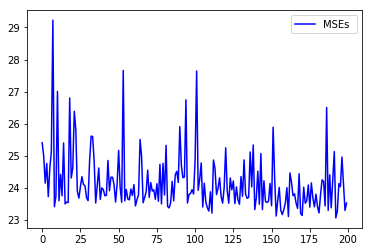

check point at 2019-04-25 11:35:19.511849
training : 土城
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 2s - loss: 9.4957e-0

 - 1s - loss: 7.8717e-04 - val_loss: 7.5293e-04
Epoch : 38, MSE : [17.928895560929167]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 1s - loss: 7.8646e-04 - val_loss: 7.3871e-04
Epoch : 39, MSE : [17.52292507845327]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 1s - loss: 7.8229e-04 - val_loss: 7.5019e-04
Epoch : 40, MSE : [17.72425991247972]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 1s - loss: 7.8337e-04 - val_loss: 7.4240e-04
Epoch : 41, MSE : [17.642986785092187]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 1s - loss: 7.9630e-04 - val_loss: 7.3629e-04
Epoch : 42, MSE : [17.454682716027346]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 1s - loss: 7.9405e-04 - val_loss: 7.6638e-04
Epoc

Epoch : 81, MSE : [17.015216193390927]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 1s - loss: 7.4423e-04 - val_loss: 7.4376e-04
Epoch : 82, MSE : [17.69461577156227]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 1s - loss: 7.3896e-04 - val_loss: 7.7088e-04
Epoch : 83, MSE : [18.122578615371857]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 1s - loss: 7.3765e-04 - val_loss: 7.9761e-04
Epoch : 84, MSE : [19.002031505103833]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 1s - loss: 7.3729e-04 - val_loss: 7.1675e-04
Epoch : 85, MSE : [17.027286040787633]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 1s - loss: 7.4220e-04 - val_loss: 7.1415e-04
Epoch : 86, MSE : [16.876133543571182]
------------

 - 1s - loss: 7.1421e-04 - val_loss: 6.9189e-04
Epoch : 125, MSE : [16.182171419735692]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 1s - loss: 7.0759e-04 - val_loss: 6.9311e-04
Epoch : 126, MSE : [16.257896499141523]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 1s - loss: 7.0960e-04 - val_loss: 7.4169e-04
Epoch : 127, MSE : [17.52283542431109]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 1s - loss: 7.1194e-04 - val_loss: 7.1159e-04
Epoch : 128, MSE : [16.757130656808403]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 1s - loss: 7.1103e-04 - val_loss: 6.8105e-04
Epoch : 129, MSE : [16.1045507135656]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 1s - loss: 7.1350e-04 - val_loss: 6.7038e-04


 - 1s - loss: 6.9377e-04 - val_loss: 6.7582e-04
Epoch : 168, MSE : [15.933594398142747]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 1s - loss: 6.9534e-04 - val_loss: 6.7039e-04
Epoch : 169, MSE : [15.758277024097195]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 1s - loss: 6.9770e-04 - val_loss: 6.6788e-04
Epoch : 170, MSE : [15.818667097713265]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 1s - loss: 6.9410e-04 - val_loss: 6.9070e-04
Epoch : 171, MSE : [16.366499764964008]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 1s - loss: 6.9587e-04 - val_loss: 7.1631e-04
Epoch : 172, MSE : [16.70529248528892]
-------------------------------------------
Train on 21728 samples, validate on 5433 samples
Epoch 1/1
 - 1s - loss: 6.9129e-04 - val_loss: 6.7962e-0

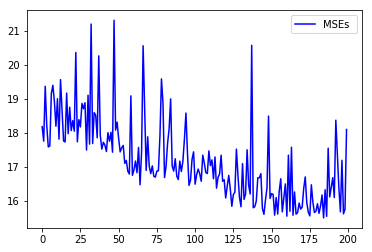

check point at 2019-04-25 11:39:55.663470
training : 基隆
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 2s - loss: 8.1920e-0

 - 1s - loss: 7.2130e-04 - val_loss: 7.3758e-04
Epoch : 38, MSE : [23.99255572743741]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 7.1887e-04 - val_loss: 7.4765e-04
Epoch : 39, MSE : [23.77224084514072]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 7.1216e-04 - val_loss: 6.8273e-04
Epoch : 40, MSE : [22.084510898864025]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 7.1848e-04 - val_loss: 7.2154e-04
Epoch : 41, MSE : [23.464111048533532]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 7.2394e-04 - val_loss: 7.1593e-04
Epoch : 42, MSE : [23.1134389494999]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 7.2016e-04 - val_loss: 6.8047e-04
Epoch 

Epoch : 81, MSE : [22.975665763897876]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 7.1904e-04 - val_loss: 6.8000e-04
Epoch : 82, MSE : [21.911426567072166]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 7.1119e-04 - val_loss: 6.9095e-04
Epoch : 83, MSE : [22.143989632851028]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 7.1279e-04 - val_loss: 6.7928e-04
Epoch : 84, MSE : [22.062316070978753]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 7.1530e-04 - val_loss: 6.8144e-04
Epoch : 85, MSE : [21.92980574002633]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 7.1458e-04 - val_loss: 6.9962e-04
Epoch : 86, MSE : [22.336059749722747]
------------

 - 1s - loss: 7.1578e-04 - val_loss: 7.1825e-04
Epoch : 125, MSE : [23.283044569971818]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 7.1506e-04 - val_loss: 7.0088e-04
Epoch : 126, MSE : [22.387106416334394]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 7.1228e-04 - val_loss: 6.8253e-04
Epoch : 127, MSE : [21.971436483779776]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 7.1488e-04 - val_loss: 7.1523e-04
Epoch : 128, MSE : [22.9389369391428]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 7.1473e-04 - val_loss: 6.9031e-04
Epoch : 129, MSE : [22.05186067678155]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 7.1120e-04 - val_loss: 7.0156e-04


 - 1s - loss: 7.1183e-04 - val_loss: 6.7559e-04
Epoch : 168, MSE : [21.90301451246375]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 7.1526e-04 - val_loss: 7.4427e-04
Epoch : 169, MSE : [23.940075645430753]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 7.1260e-04 - val_loss: 6.8199e-04
Epoch : 170, MSE : [21.919633844583213]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 7.1134e-04 - val_loss: 7.2217e-04
Epoch : 171, MSE : [22.962845192362376]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 7.1255e-04 - val_loss: 6.7793e-04
Epoch : 172, MSE : [21.948607805680947]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 7.1294e-04 - val_loss: 6.7980e-0

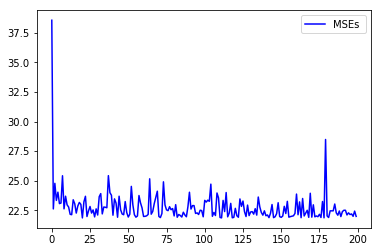

check point at 2019-04-25 11:44:35.674192
training : 士林
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 2s - loss: 9.9302e-0

 - 1s - loss: 8.2520e-04 - val_loss: 8.3097e-04
Epoch : 38, MSE : [24.787042152029535]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 1s - loss: 8.3938e-04 - val_loss: 8.4305e-04
Epoch : 39, MSE : [25.19257868821944]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 1s - loss: 8.3043e-04 - val_loss: 9.0625e-04
Epoch : 40, MSE : [26.794896041301712]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 1s - loss: 8.3543e-04 - val_loss: 7.8736e-04
Epoch : 41, MSE : [23.25524825741572]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 1s - loss: 8.4113e-04 - val_loss: 8.6749e-04
Epoch : 42, MSE : [25.107491373655005]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 1s - loss: 8.3038e-04 - val_loss: 9.5714e-04
Epoc

Epoch : 81, MSE : [22.112834321901587]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 1s - loss: 7.9666e-04 - val_loss: 7.7701e-04
Epoch : 82, MSE : [22.829270775898134]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 1s - loss: 7.8799e-04 - val_loss: 7.6763e-04
Epoch : 83, MSE : [22.613946919388464]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 1s - loss: 7.9204e-04 - val_loss: 7.5723e-04
Epoch : 84, MSE : [22.270006654899237]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 1s - loss: 7.9288e-04 - val_loss: 7.9871e-04
Epoch : 85, MSE : [23.420564448775472]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 1s - loss: 7.8831e-04 - val_loss: 7.8071e-04
Epoch : 86, MSE : [23.051499771755545]
-----------

 - 1s - loss: 7.8219e-04 - val_loss: 7.9990e-04
Epoch : 125, MSE : [23.451938223343095]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 1s - loss: 7.7969e-04 - val_loss: 7.4677e-04
Epoch : 126, MSE : [22.26039209957637]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 1s - loss: 7.7779e-04 - val_loss: 7.7392e-04
Epoch : 127, MSE : [22.697420165653497]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 1s - loss: 7.8013e-04 - val_loss: 7.4695e-04
Epoch : 128, MSE : [21.968868479501417]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 1s - loss: 7.8492e-04 - val_loss: 7.3901e-04
Epoch : 129, MSE : [21.77180519865019]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 1s - loss: 7.7885e-04 - val_loss: 7.4952e-04

 - 1s - loss: 7.7369e-04 - val_loss: 8.5505e-04
Epoch : 168, MSE : [25.003102020724306]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 1s - loss: 7.7391e-04 - val_loss: 7.2948e-04
Epoch : 169, MSE : [21.49728720098688]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 1s - loss: 7.7819e-04 - val_loss: 7.2741e-04
Epoch : 170, MSE : [21.54042412210177]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 1s - loss: 7.6556e-04 - val_loss: 8.2076e-04
Epoch : 171, MSE : [24.045277241934507]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 1s - loss: 7.7602e-04 - val_loss: 7.9436e-04
Epoch : 172, MSE : [23.63656296102479]
-------------------------------------------
Train on 18484 samples, validate on 4621 samples
Epoch 1/1
 - 1s - loss: 7.7390e-04 - val_loss: 7.6073e-04


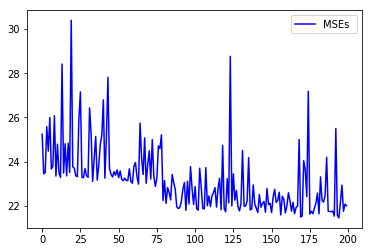

check point at 2019-04-25 11:48:40.265619
training : 大同
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 2s - loss: 0.0012 - 

 - 1s - loss: 9.4379e-04 - val_loss: 9.6850e-04
Epoch : 38, MSE : [28.338954868087548]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 1s - loss: 9.3856e-04 - val_loss: 9.2466e-04
Epoch : 39, MSE : [27.19609955651213]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 1s - loss: 9.3670e-04 - val_loss: 9.4663e-04
Epoch : 40, MSE : [27.68906893686111]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 1s - loss: 9.3679e-04 - val_loss: 9.2291e-04
Epoch : 41, MSE : [27.032049112164984]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 1s - loss: 9.3791e-04 - val_loss: 9.4137e-04
Epoch : 42, MSE : [27.747237131985234]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 1s - loss: 9.4331e-04 - val_loss: 9.4332e-04
Epoc

Epoch : 81, MSE : [25.95018552845763]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 1s - loss: 9.0359e-04 - val_loss: 9.0211e-04
Epoch : 82, MSE : [25.94548035048305]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 1s - loss: 8.8924e-04 - val_loss: 9.5318e-04
Epoch : 83, MSE : [27.435337462454097]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 1s - loss: 9.0496e-04 - val_loss: 9.1125e-04
Epoch : 84, MSE : [26.24689230884128]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 1s - loss: 8.9006e-04 - val_loss: 9.1412e-04
Epoch : 85, MSE : [26.14290980544161]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 1s - loss: 8.9329e-04 - val_loss: 9.2512e-04
Epoch : 86, MSE : [26.50560713675937]
----------------

 - 1s - loss: 8.7322e-04 - val_loss: 9.2434e-04
Epoch : 125, MSE : [26.541713502605987]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 1s - loss: 8.7305e-04 - val_loss: 9.3702e-04
Epoch : 126, MSE : [26.565831563744617]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 1s - loss: 8.7705e-04 - val_loss: 9.3580e-04
Epoch : 127, MSE : [27.01159606860597]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 1s - loss: 8.7181e-04 - val_loss: 9.1169e-04
Epoch : 128, MSE : [26.137081767898355]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 1s - loss: 8.7498e-04 - val_loss: 8.9059e-04
Epoch : 129, MSE : [25.373895666388258]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 1s - loss: 8.7278e-04 - val_loss: 9.1433e-0

Epoch : 168, MSE : [25.381543827545407]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 1s - loss: 8.7268e-04 - val_loss: 8.9417e-04
Epoch : 169, MSE : [25.51049385306634]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 1s - loss: 8.6596e-04 - val_loss: 8.9614e-04
Epoch : 170, MSE : [25.293252678105187]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 1s - loss: 8.6531e-04 - val_loss: 8.9426e-04
Epoch : 171, MSE : [25.409968147791876]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 1s - loss: 8.6825e-04 - val_loss: 9.0128e-04
Epoch : 172, MSE : [25.412510277480987]
-------------------------------------------
Train on 22708 samples, validate on 5677 samples
Epoch 1/1
 - 1s - loss: 8.6866e-04 - val_loss: 9.0767e-04
Epoch : 173, MSE : [25.85896504202547]
-------

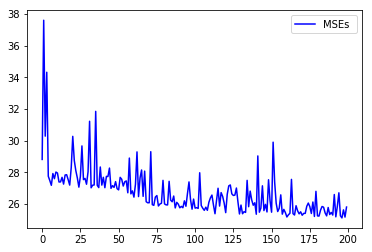

check point at 2019-04-25 11:53:47.164985
training : 大園
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 2s - loss: 7.9820e-0

 - 1s - loss: 6.3172e-04 - val_loss: 5.7600e-04
Epoch : 38, MSE : [27.976078188342544]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 1s - loss: 6.3160e-04 - val_loss: 6.4172e-04
Epoch : 39, MSE : [31.088976730200823]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 1s - loss: 6.2325e-04 - val_loss: 5.8173e-04
Epoch : 40, MSE : [27.603165946094737]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 1s - loss: 6.2987e-04 - val_loss: 5.7425e-04
Epoch : 41, MSE : [27.57894045808838]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 1s - loss: 6.3307e-04 - val_loss: 5.9684e-04
Epoch : 42, MSE : [28.39065267004202]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 1s - loss: 6.2557e-04 - val_loss: 5.7105e-04
Epoc

Epoch : 81, MSE : [27.6043136088624]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 1s - loss: 6.0732e-04 - val_loss: 5.5416e-04
Epoch : 82, MSE : [26.35505260844301]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 1s - loss: 6.0436e-04 - val_loss: 5.6143e-04
Epoch : 83, MSE : [26.734502762952]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 1s - loss: 6.0692e-04 - val_loss: 5.8184e-04
Epoch : 84, MSE : [27.983534189246186]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 1s - loss: 6.0396e-04 - val_loss: 5.5555e-04
Epoch : 85, MSE : [26.54399913017611]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 1s - loss: 6.0805e-04 - val_loss: 5.5957e-04
Epoch : 86, MSE : [26.486297682906404]
------------------

 - 1s - loss: 6.0007e-04 - val_loss: 5.9666e-04
Epoch : 125, MSE : [27.845649517489264]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 1s - loss: 5.9778e-04 - val_loss: 5.5253e-04
Epoch : 126, MSE : [25.96293993666218]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 1s - loss: 6.0023e-04 - val_loss: 5.5895e-04
Epoch : 127, MSE : [26.39292098035956]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 1s - loss: 5.9566e-04 - val_loss: 5.5590e-04
Epoch : 128, MSE : [26.020396903625002]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 1s - loss: 5.9089e-04 - val_loss: 5.5589e-04
Epoch : 129, MSE : [26.090047074424877]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 1s - loss: 6.0536e-04 - val_loss: 5.6757e-04

 - 1s - loss: 5.9303e-04 - val_loss: 6.2748e-04
Epoch : 168, MSE : [29.893769717406496]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 1s - loss: 5.9318e-04 - val_loss: 5.5177e-04
Epoch : 169, MSE : [25.810538339796857]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 1s - loss: 5.8801e-04 - val_loss: 5.5592e-04
Epoch : 170, MSE : [25.938335271888842]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 1s - loss: 5.8845e-04 - val_loss: 5.8455e-04
Epoch : 171, MSE : [27.014033787148268]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 1s - loss: 5.9061e-04 - val_loss: 5.6418e-04
Epoch : 172, MSE : [26.140807530030514]
-------------------------------------------
Train on 21824 samples, validate on 5457 samples
Epoch 1/1
 - 1s - loss: 5.9071e-04 - val_loss: 5.6771e-

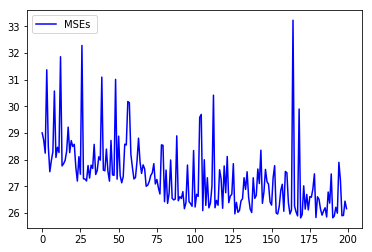

check point at 2019-04-25 11:58:50.702300
training : 平鎮
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 3s - loss: 9.5270e-0

 - 1s - loss: 6.4343e-04 - val_loss: 6.4253e-04
Epoch : 38, MSE : [26.60206259249381]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 1s - loss: 6.3816e-04 - val_loss: 6.5247e-04
Epoch : 39, MSE : [27.107760939069106]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 1s - loss: 6.4012e-04 - val_loss: 6.4008e-04
Epoch : 40, MSE : [26.516496288516215]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 1s - loss: 6.3965e-04 - val_loss: 6.3421e-04
Epoch : 41, MSE : [26.36886467960815]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 1s - loss: 6.4231e-04 - val_loss: 6.5901e-04
Epoch : 42, MSE : [27.118483160371763]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 1s - loss: 6.4459e-04 - val_loss: 6.5069e-04
Epoc

Epoch : 81, MSE : [25.637041692473527]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 1s - loss: 6.1020e-04 - val_loss: 6.1311e-04
Epoch : 82, MSE : [25.267166279504355]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 1s - loss: 6.0696e-04 - val_loss: 6.1534e-04
Epoch : 83, MSE : [25.33636857658137]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 1s - loss: 6.1266e-04 - val_loss: 6.1264e-04
Epoch : 84, MSE : [25.183622741825]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 1s - loss: 6.0736e-04 - val_loss: 6.1659e-04
Epoch : 85, MSE : [25.52758206874355]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 1s - loss: 6.1154e-04 - val_loss: 6.9108e-04
Epoch : 86, MSE : [28.145183650905324]
----------------

 - 1s - loss: 6.0382e-04 - val_loss: 6.9021e-04
Epoch : 125, MSE : [28.19125914421233]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 1s - loss: 6.0447e-04 - val_loss: 6.2471e-04
Epoch : 126, MSE : [25.6578246675139]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 1s - loss: 6.0621e-04 - val_loss: 6.2724e-04
Epoch : 127, MSE : [25.922824850517294]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 1s - loss: 6.0368e-04 - val_loss: 6.1576e-04
Epoch : 128, MSE : [25.187114284054676]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 1s - loss: 6.0615e-04 - val_loss: 6.2918e-04
Epoch : 129, MSE : [25.89694923752386]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 1s - loss: 6.0517e-04 - val_loss: 6.0950e-04
E

Epoch : 168, MSE : [25.59759846438769]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 1s - loss: 5.9674e-04 - val_loss: 6.1272e-04
Epoch : 169, MSE : [25.080596818448246]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 1s - loss: 6.0246e-04 - val_loss: 7.0302e-04
Epoch : 170, MSE : [28.57059653972161]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 1s - loss: 5.9798e-04 - val_loss: 6.1156e-04
Epoch : 171, MSE : [25.272499187379413]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 1s - loss: 5.9744e-04 - val_loss: 6.2295e-04
Epoch : 172, MSE : [25.54030600427202]
-------------------------------------------
Train on 23130 samples, validate on 5783 samples
Epoch 1/1
 - 1s - loss: 5.9676e-04 - val_loss: 6.2222e-04
Epoch : 173, MSE : [25.414147353358953]
--------

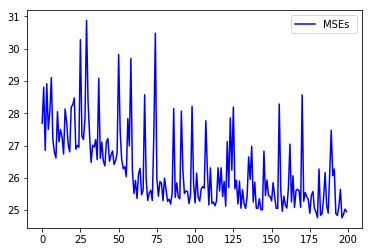

check point at 2019-04-25 12:04:15.365986
training : 新店
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 3s - loss: 8.0639e-0

 - 1s - loss: 6.5985e-04 - val_loss: 6.6683e-04
Epoch : 38, MSE : [14.267795903577984]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 1s - loss: 6.5895e-04 - val_loss: 6.3406e-04
Epoch : 39, MSE : [13.586830455032224]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 1s - loss: 6.5406e-04 - val_loss: 6.9986e-04
Epoch : 40, MSE : [14.86479645639262]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 1s - loss: 6.5918e-04 - val_loss: 6.4773e-04
Epoch : 41, MSE : [13.830347614979539]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 1s - loss: 6.5788e-04 - val_loss: 6.5238e-04
Epoch : 42, MSE : [13.839814679239662]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 1s - loss: 6.5119e-04 - val_loss: 6.3340e-04
Epo

Epoch : 81, MSE : [13.37681122932063]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 1s - loss: 6.2286e-04 - val_loss: 6.0214e-04
Epoch : 82, MSE : [12.759529870028812]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 1s - loss: 6.2205e-04 - val_loss: 8.2298e-04
Epoch : 83, MSE : [17.577289313655484]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 1s - loss: 6.2055e-04 - val_loss: 7.8736e-04
Epoch : 84, MSE : [16.526416961454835]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 1s - loss: 6.2325e-04 - val_loss: 6.5073e-04
Epoch : 85, MSE : [13.649127271679218]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 1s - loss: 6.1707e-04 - val_loss: 6.0478e-04
Epoch : 86, MSE : [12.784450621841486]
------------

 - 1s - loss: 6.0862e-04 - val_loss: 6.0271e-04
Epoch : 125, MSE : [12.70270885733031]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 1s - loss: 6.0773e-04 - val_loss: 5.9992e-04
Epoch : 126, MSE : [12.550638187900438]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 1s - loss: 6.0838e-04 - val_loss: 5.9873e-04
Epoch : 127, MSE : [12.59017788835394]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 1s - loss: 6.0646e-04 - val_loss: 6.0543e-04
Epoch : 128, MSE : [12.660699191611775]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 1s - loss: 6.0648e-04 - val_loss: 6.5869e-04
Epoch : 129, MSE : [13.96069814408351]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 1s - loss: 6.0895e-04 - val_loss: 5.9457e-04


 - 1s - loss: 6.0165e-04 - val_loss: 5.9255e-04
Epoch : 168, MSE : [12.512351316030118]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 1s - loss: 6.0398e-04 - val_loss: 5.9141e-04
Epoch : 169, MSE : [12.496816053529624]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 1s - loss: 6.0238e-04 - val_loss: 5.8512e-04
Epoch : 170, MSE : [12.365761378257377]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 1s - loss: 5.9725e-04 - val_loss: 6.1774e-04
Epoch : 171, MSE : [12.90968282925656]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 1s - loss: 6.0034e-04 - val_loss: 6.6639e-04
Epoch : 172, MSE : [14.222602763569009]
-------------------------------------------
Train on 22439 samples, validate on 5610 samples
Epoch 1/1
 - 1s - loss: 5.9925e-04 - val_loss: 5.9670e-0

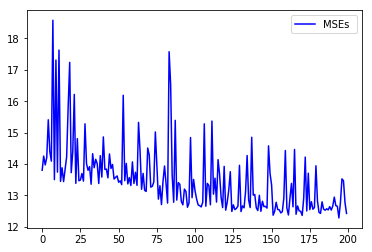

check point at 2019-04-25 12:09:36.779914
training : 新莊
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 3s - loss: 0.0010 - 

 - 1s - loss: 7.8550e-04 - val_loss: 6.9879e-04
Epoch : 38, MSE : [19.146948986206674]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 1s - loss: 7.9646e-04 - val_loss: 7.0742e-04
Epoch : 39, MSE : [19.30686853370314]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 1s - loss: 7.8840e-04 - val_loss: 6.8112e-04
Epoch : 40, MSE : [18.715764349429797]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 1s - loss: 7.8794e-04 - val_loss: 7.2690e-04
Epoch : 41, MSE : [19.840830265136766]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 1s - loss: 7.9571e-04 - val_loss: 6.9135e-04
Epoch : 42, MSE : [18.962832274812246]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 1s - loss: 7.9118e-04 - val_loss: 6.9407e-04
Epo

Epoch : 81, MSE : [17.769021336129214]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 1s - loss: 7.4436e-04 - val_loss: 6.5684e-04
Epoch : 82, MSE : [18.138346729051875]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 1s - loss: 7.5458e-04 - val_loss: 6.5136e-04
Epoch : 83, MSE : [17.980439740283128]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 1s - loss: 7.4494e-04 - val_loss: 6.4551e-04
Epoch : 84, MSE : [17.91464448504124]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 1s - loss: 7.4840e-04 - val_loss: 6.5933e-04
Epoch : 85, MSE : [18.125224353013895]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 1s - loss: 7.4621e-04 - val_loss: 6.9411e-04
Epoch : 86, MSE : [19.180183865304596]
------------

 - 1s - loss: 7.1688e-04 - val_loss: 6.6239e-04
Epoch : 125, MSE : [18.05662950615501]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 1s - loss: 7.1990e-04 - val_loss: 6.4717e-04
Epoch : 126, MSE : [17.69521423893433]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 1s - loss: 7.1491e-04 - val_loss: 6.2155e-04
Epoch : 127, MSE : [17.046603370222915]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 1s - loss: 7.2257e-04 - val_loss: 7.0871e-04
Epoch : 128, MSE : [19.274648052475506]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 1s - loss: 7.1879e-04 - val_loss: 6.5114e-04
Epoch : 129, MSE : [17.792576725370242]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 1s - loss: 7.1803e-04 - val_loss: 6.4124e-04

 - 1s - loss: 7.0476e-04 - val_loss: 6.2258e-04
Epoch : 168, MSE : [17.086980415621255]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 1s - loss: 7.0744e-04 - val_loss: 6.3370e-04
Epoch : 169, MSE : [17.306035656552957]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 1s - loss: 7.0575e-04 - val_loss: 6.1611e-04
Epoch : 170, MSE : [16.937006402264903]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 1s - loss: 6.9708e-04 - val_loss: 6.5200e-04
Epoch : 171, MSE : [17.997560469318895]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 1s - loss: 7.0112e-04 - val_loss: 6.0793e-04
Epoch : 172, MSE : [16.70853704495031]
-------------------------------------------
Train on 19904 samples, validate on 4977 samples
Epoch 1/1
 - 1s - loss: 7.0143e-04 - val_loss: 6.0981e-0

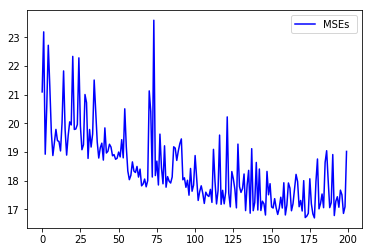

check point at 2019-04-25 12:14:34.596684
training : 松山
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 3s - loss: 0.0013 - 

 - 1s - loss: 0.0010 - val_loss: 0.0010
Epoch : 39, MSE : [27.408801527454898]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 1s - loss: 9.9920e-04 - val_loss: 0.0010
Epoch : 40, MSE : [26.552356946690853]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 0.0013
Epoch : 41, MSE : [33.362130704255286]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 0.0010
Epoch : 42, MSE : [27.29632592230269]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 9.9052e-04
Epoch : 43, MSE : [26.035852118461474]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 0.0010
Epoch : 44, MSE : [26.316505902824865]
----

 - 1s - loss: 9.4986e-04 - val_loss: 9.9147e-04
Epoch : 83, MSE : [26.115042972291693]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 1s - loss: 9.5757e-04 - val_loss: 9.5653e-04
Epoch : 84, MSE : [25.210489443489152]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 1s - loss: 9.5282e-04 - val_loss: 9.3882e-04
Epoch : 85, MSE : [24.712484863345065]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 1s - loss: 9.6057e-04 - val_loss: 9.4790e-04
Epoch : 86, MSE : [24.851358561048354]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 1s - loss: 9.5491e-04 - val_loss: 9.5437e-04
Epoch : 87, MSE : [25.009405024725936]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 1s - loss: 9.5247e-04 - val_loss: 0.0010
Epoch 

Epoch : 126, MSE : [24.577804442643707]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 1s - loss: 9.4855e-04 - val_loss: 9.3568e-04
Epoch : 127, MSE : [24.63108292520174]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 1s - loss: 9.4426e-04 - val_loss: 9.4012e-04
Epoch : 128, MSE : [24.87521335322451]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 1s - loss: 9.4861e-04 - val_loss: 9.6022e-04
Epoch : 129, MSE : [25.45067236021244]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 1s - loss: 9.4556e-04 - val_loss: 9.3235e-04
Epoch : 130, MSE : [24.54387531633957]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 1s - loss: 9.4553e-04 - val_loss: 9.3187e-04
Epoch : 131, MSE : [24.633382200180506]
---------

 - 1s - loss: 9.3977e-04 - val_loss: 9.8250e-04
Epoch : 170, MSE : [26.109543867073274]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 1s - loss: 9.4526e-04 - val_loss: 9.4872e-04
Epoch : 171, MSE : [25.097240146089117]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 1s - loss: 9.4893e-04 - val_loss: 9.2393e-04
Epoch : 172, MSE : [24.482693711668052]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 1s - loss: 9.4018e-04 - val_loss: 9.5936e-04
Epoch : 173, MSE : [25.52852020947255]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 1s - loss: 9.4486e-04 - val_loss: 9.9011e-04
Epoch : 174, MSE : [26.11380593914771]
-------------------------------------------
Train on 18311 samples, validate on 4578 samples
Epoch 1/1
 - 1s - loss: 9.4506e-04 - val_loss: 9.3568e-04

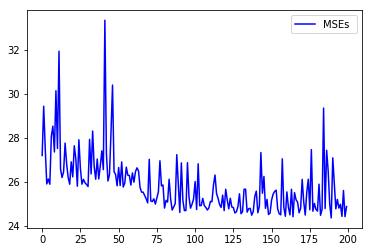

check point at 2019-04-25 12:19:05.873663
training : 板橋
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 2s - loss: 8.2069e-0

 - 1s - loss: 6.5964e-04 - val_loss: 7.2855e-04
Epoch : 38, MSE : [17.249859578701194]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 6.4876e-04 - val_loss: 7.4764e-04
Epoch : 39, MSE : [17.648587878463598]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 6.5135e-04 - val_loss: 7.4222e-04
Epoch : 40, MSE : [17.662868972762205]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 6.4920e-04 - val_loss: 7.3424e-04
Epoch : 41, MSE : [17.45812845917537]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 6.5378e-04 - val_loss: 8.5526e-04
Epoch : 42, MSE : [20.76706603788667]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 6.5280e-04 - val_loss: 8.0986e-04
Epoc

Epoch : 81, MSE : [16.966917537466628]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 6.3235e-04 - val_loss: 7.4480e-04
Epoch : 82, MSE : [17.513736019664496]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 6.3393e-04 - val_loss: 7.1895e-04
Epoch : 83, MSE : [16.84711674868906]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 6.3721e-04 - val_loss: 8.2483e-04
Epoch : 84, MSE : [19.844504522981467]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 6.3201e-04 - val_loss: 7.1641e-04
Epoch : 85, MSE : [16.76379464030736]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 6.2839e-04 - val_loss: 7.2495e-04
Epoch : 86, MSE : [16.952859437757375]
-------------

 - 1s - loss: 6.2316e-04 - val_loss: 7.3101e-04
Epoch : 125, MSE : [17.156672036149157]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 6.2078e-04 - val_loss: 7.1679e-04
Epoch : 126, MSE : [16.778377963950547]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 6.2326e-04 - val_loss: 7.5345e-04
Epoch : 127, MSE : [17.684769109959753]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 6.2324e-04 - val_loss: 7.0744e-04
Epoch : 128, MSE : [16.537402462669576]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 6.1985e-04 - val_loss: 7.2748e-04
Epoch : 129, MSE : [17.112913027482126]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 6.2242e-04 - val_loss: 7.8565e-

 - 1s - loss: 6.1094e-04 - val_loss: 7.1645e-04
Epoch : 168, MSE : [16.66733508981474]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 6.1277e-04 - val_loss: 7.1846e-04
Epoch : 169, MSE : [16.728301746105323]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 6.1097e-04 - val_loss: 7.0416e-04
Epoch : 170, MSE : [16.333128812989496]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 6.0959e-04 - val_loss: 7.0118e-04
Epoch : 171, MSE : [16.269769648353087]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 6.1304e-04 - val_loss: 7.1175e-04
Epoch : 172, MSE : [16.571638903879858]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 6.1201e-04 - val_loss: 7.3177e-0

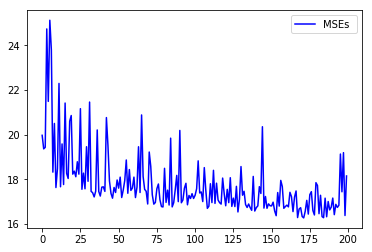

check point at 2019-04-25 12:24:37.552461
training : 林口
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 3s - loss: 9.6136e-0

 - 1s - loss: 5.5617e-04 - val_loss: 5.5123e-04
Epoch : 38, MSE : [17.367597437082388]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 1s - loss: 5.5564e-04 - val_loss: 5.2701e-04
Epoch : 39, MSE : [16.648867637518773]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 1s - loss: 5.5483e-04 - val_loss: 5.2665e-04
Epoch : 40, MSE : [16.676972797767775]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 1s - loss: 5.5590e-04 - val_loss: 5.5096e-04
Epoch : 41, MSE : [17.337190588195675]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 1s - loss: 5.5194e-04 - val_loss: 5.7510e-04
Epoch : 42, MSE : [17.982661865759233]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 1s - loss: 5.5732e-04 - val_loss: 5.2216e-04
Ep

Epoch : 81, MSE : [16.409305751753994]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 1s - loss: 5.3894e-04 - val_loss: 6.2364e-04
Epoch : 82, MSE : [19.59864479572915]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 1s - loss: 5.3394e-04 - val_loss: 5.2460e-04
Epoch : 83, MSE : [16.507610542465727]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 1s - loss: 5.3526e-04 - val_loss: 5.3396e-04
Epoch : 84, MSE : [16.76593943849068]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 1s - loss: 5.4366e-04 - val_loss: 5.2032e-04
Epoch : 85, MSE : [16.41685754875958]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 1s - loss: 5.3590e-04 - val_loss: 5.5459e-04
Epoch : 86, MSE : [17.32108662612114]
---------------

 - 1s - loss: 5.3282e-04 - val_loss: 5.3151e-04
Epoch : 125, MSE : [16.64514402663321]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 1s - loss: 5.3556e-04 - val_loss: 5.3561e-04
Epoch : 126, MSE : [16.698179868135796]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 1s - loss: 5.3332e-04 - val_loss: 5.4441e-04
Epoch : 127, MSE : [17.0492501916915]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 1s - loss: 5.3380e-04 - val_loss: 5.2563e-04
Epoch : 128, MSE : [16.59837066851481]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 1s - loss: 5.3444e-04 - val_loss: 5.2098e-04
Epoch : 129, MSE : [16.325378480221698]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 1s - loss: 5.3526e-04 - val_loss: 5.4092e-04
E

Epoch : 168, MSE : [16.200944336450636]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 1s - loss: 5.2928e-04 - val_loss: 5.2231e-04
Epoch : 169, MSE : [16.308534230566764]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 1s - loss: 5.3188e-04 - val_loss: 5.3477e-04
Epoch : 170, MSE : [16.60961920050057]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 1s - loss: 5.3002e-04 - val_loss: 5.3899e-04
Epoch : 171, MSE : [16.69051254699274]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 1s - loss: 5.2946e-04 - val_loss: 5.1800e-04
Epoch : 172, MSE : [16.1491037067012]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 1s - loss: 5.2906e-04 - val_loss: 5.4773e-04
Epoch : 173, MSE : [17.15395578237566]
----------

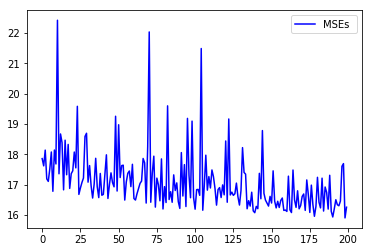

check point at 2019-04-25 12:30:23.198987
training : 桃園
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 3s - loss: 0.0012 - 

 - 1s - loss: 9.1746e-04 - val_loss: 9.2138e-04
Epoch : 38, MSE : [26.21943848571083]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 9.2175e-04 - val_loss: 9.7655e-04
Epoch : 39, MSE : [27.60625425986828]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 9.1915e-04 - val_loss: 9.7208e-04
Epoch : 40, MSE : [27.551926441171247]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 9.1594e-04 - val_loss: 9.6681e-04
Epoch : 41, MSE : [27.570743286686515]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 9.0461e-04 - val_loss: 9.3139e-04
Epoch : 42, MSE : [26.38727863568047]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 9.1426e-04 - val_loss: 9.1734e-04
Epoch

 - 1s - loss: 8.6620e-04 - val_loss: 8.9366e-04
Epoch : 82, MSE : [24.961927245745425]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 8.7659e-04 - val_loss: 9.2068e-04
Epoch : 83, MSE : [25.78920736248466]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 8.6787e-04 - val_loss: 9.0887e-04
Epoch : 84, MSE : [25.44683749752371]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 8.6581e-04 - val_loss: 8.9842e-04
Epoch : 85, MSE : [25.29266188819486]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 8.6802e-04 - val_loss: 8.8854e-04
Epoch : 86, MSE : [24.90811085732125]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 8.6022e-04 - val_loss: 9.7823e-04
Epoch 

Epoch : 125, MSE : [25.711849515032263]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 8.6076e-04 - val_loss: 9.1314e-04
Epoch : 126, MSE : [25.503167848367077]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 8.5281e-04 - val_loss: 8.8598e-04
Epoch : 127, MSE : [24.742097943762754]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 8.6128e-04 - val_loss: 8.8496e-04
Epoch : 128, MSE : [24.722421273224597]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 8.5727e-04 - val_loss: 8.8651e-04
Epoch : 129, MSE : [24.682048536142208]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 8.5491e-04 - val_loss: 8.9566e-04
Epoch : 130, MSE : [24.86468391171326]
------

Epoch : 168, MSE : [25.18592516797073]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 8.4985e-04 - val_loss: 9.4628e-04
Epoch : 169, MSE : [26.38180308346857]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 8.5236e-04 - val_loss: 8.8603e-04
Epoch : 170, MSE : [24.570597704684086]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 8.4907e-04 - val_loss: 8.8298e-04
Epoch : 171, MSE : [24.744118657443824]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 8.4581e-04 - val_loss: 8.7590e-04
Epoch : 172, MSE : [24.38395627363912]
-------------------------------------------
Train on 21767 samples, validate on 5442 samples
Epoch 1/1
 - 1s - loss: 8.4257e-04 - val_loss: 8.7425e-04
Epoch : 173, MSE : [24.41957801905502]
---------

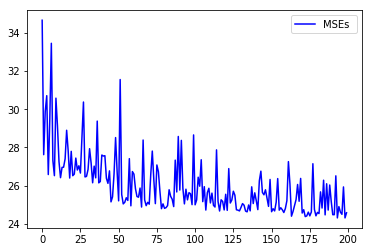

check point at 2019-04-25 12:36:05.017665
training : 永和
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 3s - loss: 8.7480e-0

 - 1s - loss: 5.9541e-04 - val_loss: 5.9929e-04
Epoch : 38, MSE : [15.725400302160734]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 1s - loss: 5.9153e-04 - val_loss: 6.3312e-04
Epoch : 39, MSE : [16.630194838890056]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 1s - loss: 5.8947e-04 - val_loss: 6.1196e-04
Epoch : 40, MSE : [16.058665920208796]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 1s - loss: 5.8943e-04 - val_loss: 6.0412e-04
Epoch : 41, MSE : [16.00530684737282]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 1s - loss: 5.8908e-04 - val_loss: 5.9012e-04
Epoch : 42, MSE : [15.537978552334813]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 1s - loss: 5.8885e-04 - val_loss: 6.0282e-04
Epo

Epoch : 81, MSE : [14.753436357520235]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 1s - loss: 5.5850e-04 - val_loss: 6.1408e-04
Epoch : 82, MSE : [16.329314799935737]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 1s - loss: 5.5740e-04 - val_loss: 5.6281e-04
Epoch : 83, MSE : [14.794104138186828]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 1s - loss: 5.5504e-04 - val_loss: 5.7167e-04
Epoch : 84, MSE : [14.98802273216783]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 1s - loss: 5.6013e-04 - val_loss: 5.5873e-04
Epoch : 85, MSE : [14.742675156034158]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 1s - loss: 5.5548e-04 - val_loss: 5.5996e-04
Epoch : 86, MSE : [14.75407920104671]
-------------

 - 1s - loss: 5.5371e-04 - val_loss: 5.7025e-04
Epoch : 125, MSE : [15.101569124434555]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 1s - loss: 5.5257e-04 - val_loss: 5.5356e-04
Epoch : 126, MSE : [14.582959362464642]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 1s - loss: 5.5051e-04 - val_loss: 5.7669e-04
Epoch : 127, MSE : [15.089551460221717]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 1s - loss: 5.4988e-04 - val_loss: 5.5563e-04
Epoch : 128, MSE : [14.581312242348622]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 1s - loss: 5.4925e-04 - val_loss: 5.6153e-04
Epoch : 129, MSE : [14.766251579005734]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 1s - loss: 5.4743e-04 - val_loss: 6.1203e-

 - 1s - loss: 5.4627e-04 - val_loss: 5.5254e-04
Epoch : 168, MSE : [14.51173979206083]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 1s - loss: 5.5307e-04 - val_loss: 5.6618e-04
Epoch : 169, MSE : [14.853973106789493]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 1s - loss: 5.4870e-04 - val_loss: 5.7014e-04
Epoch : 170, MSE : [14.956462117421587]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 1s - loss: 5.5010e-04 - val_loss: 5.8205e-04
Epoch : 171, MSE : [15.410081027378185]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 1s - loss: 5.5234e-04 - val_loss: 5.5605e-04
Epoch : 172, MSE : [14.615096201965843]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 1s - loss: 5.4775e-04 - val_loss: 6.1140e-0

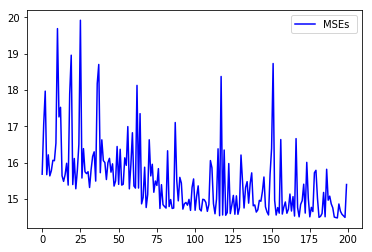

check point at 2019-04-25 12:42:10.490860
training : 汐止
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 3s - loss: 7.9218e-0

 - 1s - loss: 5.1304e-04 - val_loss: 4.5637e-04
Epoch : 38, MSE : [13.376342906550779]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 1s - loss: 5.1034e-04 - val_loss: 4.6197e-04
Epoch : 39, MSE : [13.583271583923057]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 1s - loss: 5.0675e-04 - val_loss: 4.6720e-04
Epoch : 40, MSE : [13.552123029245754]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 1s - loss: 5.0575e-04 - val_loss: 4.6957e-04
Epoch : 41, MSE : [13.589778511850316]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 1s - loss: 5.1391e-04 - val_loss: 4.5180e-04
Epoch : 42, MSE : [13.189115374197216]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 1s - loss: 5.0969e-04 - val_loss: 5.1247e-04
Ep

Epoch : 81, MSE : [15.215144306700164]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 1s - loss: 5.0418e-04 - val_loss: 5.2218e-04
Epoch : 82, MSE : [15.1275298223845]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 1s - loss: 5.0600e-04 - val_loss: 4.6349e-04
Epoch : 83, MSE : [13.47516858331237]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 1s - loss: 5.0081e-04 - val_loss: 4.7409e-04
Epoch : 84, MSE : [13.599721453910126]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 1s - loss: 5.0385e-04 - val_loss: 4.8719e-04
Epoch : 85, MSE : [14.087428213584502]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 1s - loss: 5.0144e-04 - val_loss: 5.0093e-04
Epoch : 86, MSE : [14.507389549983989]
--------------

 - 1s - loss: 4.9967e-04 - val_loss: 4.6702e-04
Epoch : 125, MSE : [13.31897761818661]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 1s - loss: 5.0096e-04 - val_loss: 4.7889e-04
Epoch : 126, MSE : [13.995343442780733]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 1s - loss: 4.9919e-04 - val_loss: 4.7316e-04
Epoch : 127, MSE : [13.80134238668772]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 1s - loss: 4.9700e-04 - val_loss: 4.6884e-04
Epoch : 128, MSE : [13.430610179589447]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 1s - loss: 4.9674e-04 - val_loss: 4.5460e-04
Epoch : 129, MSE : [13.1224337385381]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 1s - loss: 4.9850e-04 - val_loss: 4.5741e-04
E

 - 1s - loss: 4.9355e-04 - val_loss: 5.6434e-04
Epoch : 168, MSE : [16.144018501546213]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 1s - loss: 4.9077e-04 - val_loss: 4.6307e-04
Epoch : 169, MSE : [13.222382348053078]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 1s - loss: 4.9182e-04 - val_loss: 4.8704e-04
Epoch : 170, MSE : [14.001219586736092]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 1s - loss: 4.9041e-04 - val_loss: 5.0267e-04
Epoch : 171, MSE : [14.227138578538792]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 1s - loss: 4.9104e-04 - val_loss: 4.7066e-04
Epoch : 172, MSE : [13.50951533565032]
-------------------------------------------
Train on 21152 samples, validate on 5289 samples
Epoch 1/1
 - 1s - loss: 4.9122e-04 - val_loss: 4.8912e-0

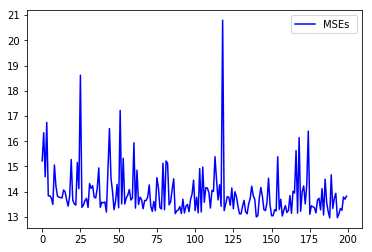

check point at 2019-04-25 12:47:56.574852
training : 淡水
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 3s - loss: 7.0225e-0

 - 1s - loss: 4.8468e-04 - val_loss: 4.9117e-04
Epoch : 38, MSE : [14.125390690233015]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 4.9045e-04 - val_loss: 4.7751e-04
Epoch : 39, MSE : [13.724985766073061]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 4.8775e-04 - val_loss: 4.8745e-04
Epoch : 40, MSE : [14.082511875820797]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 4.8235e-04 - val_loss: 4.7951e-04
Epoch : 41, MSE : [13.759180504639291]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 4.8493e-04 - val_loss: 4.8613e-04
Epoch : 42, MSE : [14.143563597017923]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 4.8355e-04 - val_loss: 5.2413e-04
Ep

Epoch : 81, MSE : [14.157344910581322]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 4.7849e-04 - val_loss: 4.7629e-04
Epoch : 82, MSE : [13.725956079394361]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 4.7350e-04 - val_loss: 4.7289e-04
Epoch : 83, MSE : [13.51125800326737]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 4.7493e-04 - val_loss: 4.7823e-04
Epoch : 84, MSE : [13.644757307139656]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 4.7399e-04 - val_loss: 4.7510e-04
Epoch : 85, MSE : [13.663319350666148]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 4.7632e-04 - val_loss: 4.7444e-04
Epoch : 86, MSE : [13.586655791080075]
------------

 - 1s - loss: 4.7583e-04 - val_loss: 4.7496e-04
Epoch : 125, MSE : [13.686116569428869]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 4.7441e-04 - val_loss: 4.7252e-04
Epoch : 126, MSE : [13.576446873838787]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 4.7230e-04 - val_loss: 4.7213e-04
Epoch : 127, MSE : [13.49598572220703]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 4.7240e-04 - val_loss: 5.2906e-04
Epoch : 128, MSE : [15.207725560716868]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 4.7503e-04 - val_loss: 4.6964e-04
Epoch : 129, MSE : [13.430512446528617]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 4.7653e-04 - val_loss: 4.9261e-0

 - 1s - loss: 4.7185e-04 - val_loss: 5.0836e-04
Epoch : 168, MSE : [14.453287773635276]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 4.7156e-04 - val_loss: 4.7076e-04
Epoch : 169, MSE : [13.525570509075866]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 4.6853e-04 - val_loss: 4.7984e-04
Epoch : 170, MSE : [13.80731207037024]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 4.6868e-04 - val_loss: 4.6899e-04
Epoch : 171, MSE : [13.454805903144763]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 4.6825e-04 - val_loss: 4.7963e-04
Epoch : 172, MSE : [13.702918520004362]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 4.6856e-04 - val_loss: 4.8046e-0

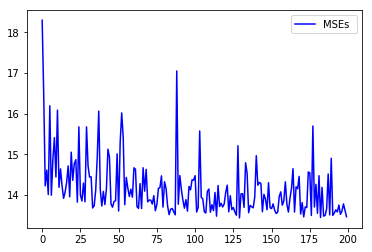

check point at 2019-04-25 12:53:58.376441
training : 菜寮
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 3s - loss: 7.4328e-0

 - 1s - loss: 5.3571e-04 - val_loss: 6.3993e-04
Epoch : 38, MSE : [14.154452236080798]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 1s - loss: 5.3005e-04 - val_loss: 6.4993e-04
Epoch : 39, MSE : [14.396308652997568]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 1s - loss: 5.3278e-04 - val_loss: 6.8665e-04
Epoch : 40, MSE : [15.460804641416038]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 1s - loss: 5.3153e-04 - val_loss: 6.4750e-04
Epoch : 41, MSE : [14.409966210809001]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 1s - loss: 5.2886e-04 - val_loss: 6.4273e-04
Epoch : 42, MSE : [14.219855740788873]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 1s - loss: 5.2997e-04 - val_loss: 6.4855e-04
Ep

Epoch : 81, MSE : [15.197105151350494]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 1s - loss: 5.2885e-04 - val_loss: 6.8406e-04
Epoch : 82, MSE : [15.401919101916304]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 1s - loss: 5.2728e-04 - val_loss: 6.4197e-04
Epoch : 83, MSE : [14.303200797996153]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 1s - loss: 5.3294e-04 - val_loss: 7.4383e-04
Epoch : 84, MSE : [16.987413409081224]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 1s - loss: 5.3071e-04 - val_loss: 6.5074e-04
Epoch : 85, MSE : [14.363922355838245]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 1s - loss: 5.3334e-04 - val_loss: 6.3965e-04
Epoch : 86, MSE : [14.153026749286742]
-----------

 - 1s - loss: 5.1236e-04 - val_loss: 6.1593e-04
Epoch : 125, MSE : [13.714432373458052]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 1s - loss: 5.0973e-04 - val_loss: 6.1293e-04
Epoch : 126, MSE : [13.76944563753555]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 1s - loss: 5.1694e-04 - val_loss: 6.8582e-04
Epoch : 127, MSE : [15.765677444491253]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 1s - loss: 5.1426e-04 - val_loss: 6.2953e-04
Epoch : 128, MSE : [14.199483538146636]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 1s - loss: 5.0860e-04 - val_loss: 6.4355e-04
Epoch : 129, MSE : [14.380083600618496]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 1s - loss: 5.1241e-04 - val_loss: 6.2992e-0

 - 1s - loss: 5.0751e-04 - val_loss: 6.6140e-04
Epoch : 168, MSE : [14.834633160595585]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 1s - loss: 5.0795e-04 - val_loss: 6.3465e-04
Epoch : 169, MSE : [14.217895268225012]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 1s - loss: 5.0926e-04 - val_loss: 6.3235e-04
Epoch : 170, MSE : [14.107232965285824]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 1s - loss: 5.0550e-04 - val_loss: 6.0905e-04
Epoch : 171, MSE : [13.572647160080058]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 1s - loss: 5.0706e-04 - val_loss: 6.1565e-04
Epoch : 172, MSE : [13.821569333013482]
-------------------------------------------
Train on 22208 samples, validate on 5553 samples
Epoch 1/1
 - 1s - loss: 5.0616e-04 - val_loss: 6.3929e-

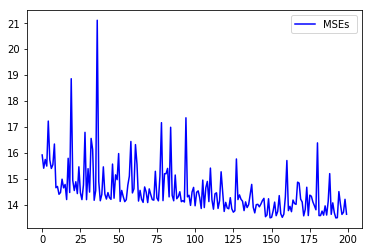

check point at 2019-04-25 13:00:11.755308
training : 萬華
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 4s - loss: 0.0012 - 

Epoch : 39, MSE : [28.79128081082162]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 0.0011
Epoch : 40, MSE : [27.288148179390774]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 0.0010
Epoch : 41, MSE : [26.336149308923783]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 0.0011
Epoch : 42, MSE : [28.345030486503685]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 0.0010
Epoch : 43, MSE : [25.87490548901004]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 0.0010
Epoch : 44, MSE : [26.3084743335305]
-------------------------------------------
Train on 21

 - 1s - loss: 9.6253e-04 - val_loss: 9.5598e-04
Epoch : 83, MSE : [24.788552084129655]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 9.7227e-04 - val_loss: 9.6238e-04
Epoch : 84, MSE : [24.845924196344587]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 9.6579e-04 - val_loss: 9.9318e-04
Epoch : 85, MSE : [25.89515380804528]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 9.5989e-04 - val_loss: 0.0010
Epoch : 86, MSE : [26.447018501165317]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 9.7342e-04 - val_loss: 9.5647e-04
Epoch : 87, MSE : [24.66647855150282]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 9.5932e-04 - val_loss: 9.5430e-04
Epoch : 

Epoch : 126, MSE : [25.286050681633807]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 9.5352e-04 - val_loss: 9.6621e-04
Epoch : 127, MSE : [24.96805171632196]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 9.5784e-04 - val_loss: 0.0010
Epoch : 128, MSE : [25.88744312950213]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 9.5124e-04 - val_loss: 9.5434e-04
Epoch : 129, MSE : [24.7469659732393]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 9.5620e-04 - val_loss: 9.4998e-04
Epoch : 130, MSE : [24.58158816456373]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 9.5617e-04 - val_loss: 9.8301e-04
Epoch : 131, MSE : [25.53018422723464]
---------------

 - 1s - loss: 9.5004e-04 - val_loss: 9.4963e-04
Epoch : 170, MSE : [24.517598056189]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 9.4354e-04 - val_loss: 0.0010
Epoch : 171, MSE : [26.773295698570077]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 9.4716e-04 - val_loss: 9.4972e-04
Epoch : 172, MSE : [24.493788325653725]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 9.5184e-04 - val_loss: 9.5531e-04
Epoch : 173, MSE : [24.688191465150165]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 9.5075e-04 - val_loss: 9.4859e-04
Epoch : 174, MSE : [24.531827486315194]
-------------------------------------------
Train on 21882 samples, validate on 5471 samples
Epoch 1/1
 - 1s - loss: 9.5085e-04 - val_loss: 9.9064e-04
Epoc

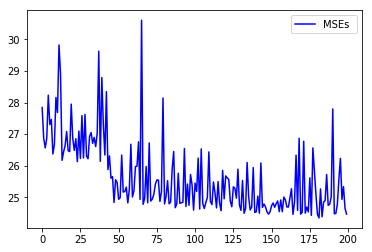

check point at 2019-04-25 13:06:25.009181
training : 萬里
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 3s - loss: 4.2579e-0

 - 1s - loss: 3.3569e-04 - val_loss: 3.1509e-04
Epoch : 38, MSE : [11.898032762564268]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 1s - loss: 3.3585e-04 - val_loss: 3.1610e-04
Epoch : 39, MSE : [11.855116432767172]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 1s - loss: 3.3751e-04 - val_loss: 3.1455e-04
Epoch : 40, MSE : [11.808565430945364]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 1s - loss: 3.3866e-04 - val_loss: 3.1400e-04
Epoch : 41, MSE : [11.929110887998414]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 1s - loss: 3.3828e-04 - val_loss: 3.4080e-04
Epoch : 42, MSE : [12.750937368138644]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 1s - loss: 3.3655e-04 - val_loss: 3.1105e-04
Ep

Epoch : 81, MSE : [11.842970109275218]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 1s - loss: 3.3126e-04 - val_loss: 3.2697e-04
Epoch : 82, MSE : [12.267774897867499]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 1s - loss: 3.3293e-04 - val_loss: 3.5985e-04
Epoch : 83, MSE : [13.60975297547743]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 1s - loss: 3.3200e-04 - val_loss: 3.1540e-04
Epoch : 84, MSE : [11.783037258816139]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 1s - loss: 3.3427e-04 - val_loss: 3.1364e-04
Epoch : 85, MSE : [11.776817084141632]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 1s - loss: 3.3007e-04 - val_loss: 3.2527e-04
Epoch : 86, MSE : [12.065113158793563]
------------

 - 1s - loss: 3.1982e-04 - val_loss: 3.2288e-04
Epoch : 125, MSE : [11.95787469888397]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 1s - loss: 3.1850e-04 - val_loss: 3.1866e-04
Epoch : 126, MSE : [11.946676240337405]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 1s - loss: 3.1883e-04 - val_loss: 3.3585e-04
Epoch : 127, MSE : [12.56478027340516]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 1s - loss: 3.1791e-04 - val_loss: 3.0556e-04
Epoch : 128, MSE : [11.367604287835915]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 1s - loss: 3.1740e-04 - val_loss: 3.0174e-04
Epoch : 129, MSE : [11.317640972955447]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 1s - loss: 3.2226e-04 - val_loss: 3.3176e-04

 - 1s - loss: 3.1770e-04 - val_loss: 3.0554e-04
Epoch : 168, MSE : [11.350910874403473]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 1s - loss: 3.1787e-04 - val_loss: 3.1084e-04
Epoch : 169, MSE : [11.515421719121658]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 1s - loss: 3.1585e-04 - val_loss: 3.0868e-04
Epoch : 170, MSE : [11.403368397453614]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 1s - loss: 3.1663e-04 - val_loss: 3.1124e-04
Epoch : 171, MSE : [11.51406825289419]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 1s - loss: 3.1463e-04 - val_loss: 3.1146e-04
Epoch : 172, MSE : [11.505662590082673]
-------------------------------------------
Train on 22228 samples, validate on 5557 samples
Epoch 1/1
 - 1s - loss: 3.1570e-04 - val_loss: 3.0756e-0

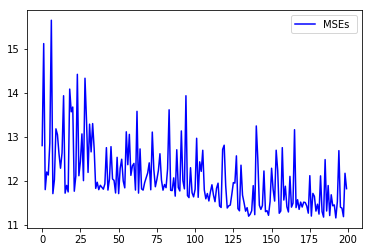

check point at 2019-04-25 13:13:12.182442
training : 觀音
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 3s - loss: 0.0011 - 

 - 1s - loss: 7.7818e-04 - val_loss: 8.2852e-04
Epoch : 38, MSE : [23.466632292310166]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 7.8115e-04 - val_loss: 7.4376e-04
Epoch : 39, MSE : [20.922570591131667]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 7.7486e-04 - val_loss: 7.7323e-04
Epoch : 40, MSE : [21.805555758286673]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 7.7359e-04 - val_loss: 7.3734e-04
Epoch : 41, MSE : [20.83225674849983]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 7.7162e-04 - val_loss: 7.4434e-04
Epoch : 42, MSE : [20.962375544468614]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 7.7225e-04 - val_loss: 7.6695e-04
Epo

Epoch : 81, MSE : [20.58237443422406]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 7.7001e-04 - val_loss: 8.1572e-04
Epoch : 82, MSE : [23.014469045789035]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 7.6538e-04 - val_loss: 7.4243e-04
Epoch : 83, MSE : [20.882743712267697]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 7.7349e-04 - val_loss: 7.2968e-04
Epoch : 84, MSE : [20.5939810866688]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 7.6478e-04 - val_loss: 8.3233e-04
Epoch : 85, MSE : [23.227161286103588]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 7.7020e-04 - val_loss: 7.7311e-04
Epoch : 86, MSE : [21.690033842617297]
--------------

 - 1s - loss: 7.6049e-04 - val_loss: 7.3344e-04
Epoch : 125, MSE : [20.744078418819523]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 7.5991e-04 - val_loss: 7.4546e-04
Epoch : 126, MSE : [21.02329738497843]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 7.6504e-04 - val_loss: 7.2388e-04
Epoch : 127, MSE : [20.48926339645651]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 7.6185e-04 - val_loss: 7.3371e-04
Epoch : 128, MSE : [20.79189573670116]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 7.6352e-04 - val_loss: 7.3375e-04
Epoch : 129, MSE : [20.718238590435792]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 7.6510e-04 - val_loss: 7.2510e-04


 - 1s - loss: 7.5395e-04 - val_loss: 7.4439e-04
Epoch : 168, MSE : [21.030807569992497]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 7.5354e-04 - val_loss: 7.6411e-04
Epoch : 169, MSE : [21.646981726889003]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 7.6023e-04 - val_loss: 7.3667e-04
Epoch : 170, MSE : [20.818928570934236]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 7.6047e-04 - val_loss: 8.0296e-04
Epoch : 171, MSE : [22.711022941252615]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 7.5480e-04 - val_loss: 7.2483e-04
Epoch : 172, MSE : [20.46793961773394]
-------------------------------------------
Train on 22036 samples, validate on 5509 samples
Epoch 1/1
 - 1s - loss: 7.6048e-04 - val_loss: 7.6323e-0

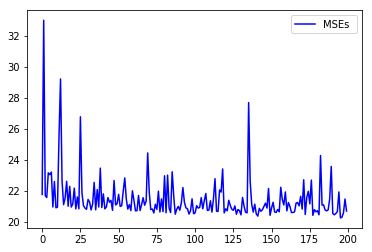

check point at 2019-04-25 13:19:44.559915
training : 陽明
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 4s - loss: 0.0012 - 

 - 1s - loss: 0.0010 - val_loss: 0.0010
Epoch : 39, MSE : [20.213599663226947]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 2s - loss: 0.0010 - val_loss: 9.9724e-04
Epoch : 40, MSE : [19.977573275148092]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 0.0010
Epoch : 41, MSE : [20.293386877876557]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 0.0010
Epoch : 42, MSE : [20.316173417395348]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 0.0010
Epoch : 43, MSE : [20.046813230500216]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 0.0011
Epoch : 44, MSE : [21.189136792935845]
-------

 - 1s - loss: 0.0010 - val_loss: 0.0010
Epoch : 84, MSE : [20.327148715049155]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 0.0010
Epoch : 85, MSE : [20.224877835202264]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 0.0010
Epoch : 86, MSE : [20.214207677985808]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 9.9184e-04
Epoch : 87, MSE : [19.86501095374656]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 9.9412e-04
Epoch : 88, MSE : [19.901853719315312]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 9.9690e-04
Epoch : 89, MSE : [19.958441809523876]


 - 1s - loss: 0.0010 - val_loss: 9.8375e-04
Epoch : 129, MSE : [19.724863123704324]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 0.0010
Epoch : 130, MSE : [20.920360512159988]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 9.8875e-04
Epoch : 131, MSE : [19.827100481979947]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 9.8723e-04
Epoch : 132, MSE : [19.799082978706657]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 0.0010
Epoch : 133, MSE : [20.134590640442347]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 9.8337e-04
Epoch : 134, MSE : [19.683244

Epoch : 173, MSE : [21.949582405022298]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 0.0011
Epoch : 174, MSE : [21.645705224282263]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 9.7347e-04
Epoch : 175, MSE : [19.456432657710366]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 9.9303e-04
Epoch : 176, MSE : [19.884867596628087]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 1s - loss: 9.9107e-04 - val_loss: 0.0011
Epoch : 177, MSE : [21.36990443519831]
-------------------------------------------
Train on 19175 samples, validate on 4794 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 9.9683e-04
Epoch : 178, MSE : [19.910002841853856]
------------------------------

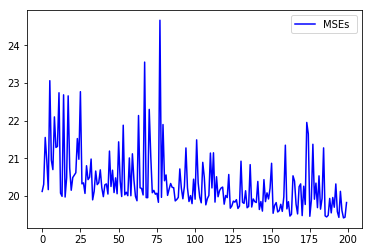

check point at 2019-04-25 13:25:47.783274
training : 龍潭
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 4s - loss: 0.0010 - 

 - 1s - loss: 8.5274e-04 - val_loss: 8.3170e-04
Epoch : 38, MSE : [27.13603043851046]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 1s - loss: 8.4761e-04 - val_loss: 8.1722e-04
Epoch : 39, MSE : [26.660177253222916]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 1s - loss: 8.4757e-04 - val_loss: 8.4971e-04
Epoch : 40, MSE : [27.565113883118546]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 1s - loss: 8.4584e-04 - val_loss: 8.2275e-04
Epoch : 41, MSE : [26.701687757008592]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 1s - loss: 8.4796e-04 - val_loss: 8.0853e-04
Epoch : 42, MSE : [26.317789937241308]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 1s - loss: 8.4591e-04 - val_loss: 9.3524e-04
Epo

Epoch : 81, MSE : [26.771183465807947]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 1s - loss: 7.9604e-04 - val_loss: 7.6247e-04
Epoch : 82, MSE : [24.593152430476714]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 1s - loss: 7.9799e-04 - val_loss: 8.3430e-04
Epoch : 83, MSE : [27.08181213900669]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 1s - loss: 7.9880e-04 - val_loss: 7.7775e-04
Epoch : 84, MSE : [25.06740690238992]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 1s - loss: 7.9805e-04 - val_loss: 7.6066e-04
Epoch : 85, MSE : [24.574415872298975]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 1s - loss: 7.9402e-04 - val_loss: 8.0211e-04
Epoch : 86, MSE : [26.00073284217302]
--------------

 - 1s - loss: 7.9311e-04 - val_loss: 7.5351e-04
Epoch : 125, MSE : [24.271840070243908]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 1s - loss: 7.8396e-04 - val_loss: 7.7627e-04
Epoch : 126, MSE : [24.857313145064694]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 1s - loss: 7.8183e-04 - val_loss: 7.7519e-04
Epoch : 127, MSE : [25.060762589704947]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 1s - loss: 7.8240e-04 - val_loss: 8.1178e-04
Epoch : 128, MSE : [25.99146426408726]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 1s - loss: 7.8459e-04 - val_loss: 7.7500e-04
Epoch : 129, MSE : [24.866582430442822]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 1s - loss: 7.8395e-04 - val_loss: 7.4673e-0

 - 1s - loss: 7.7898e-04 - val_loss: 7.5169e-04
Epoch : 168, MSE : [24.01137596041342]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 1s - loss: 7.7772e-04 - val_loss: 7.6016e-04
Epoch : 169, MSE : [24.203124832087838]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 1s - loss: 7.7832e-04 - val_loss: 7.5524e-04
Epoch : 170, MSE : [24.13765076585596]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 1s - loss: 7.7541e-04 - val_loss: 7.5165e-04
Epoch : 171, MSE : [23.958037031125976]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 1s - loss: 7.7777e-04 - val_loss: 7.5167e-04
Epoch : 172, MSE : [24.037303246488776]
-------------------------------------------
Train on 24071 samples, validate on 6018 samples
Epoch 1/1
 - 1s - loss: 7.7330e-04 - val_loss: 8.1344e-04

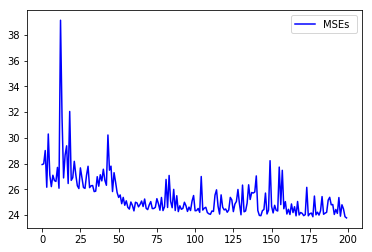

check point at 2019-04-25 13:33:09.782108
training : 冬山
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 4s - loss: 0.0010 - 

 - 1s - loss: 8.4581e-04 - val_loss: 7.9417e-04
Epoch : 38, MSE : [16.01384663577427]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 1s - loss: 8.3719e-04 - val_loss: 7.7107e-04
Epoch : 39, MSE : [15.481234964789895]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 1s - loss: 8.3726e-04 - val_loss: 7.4840e-04
Epoch : 40, MSE : [15.08212864871339]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 1s - loss: 8.3854e-04 - val_loss: 7.5706e-04
Epoch : 41, MSE : [15.311459739042714]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 1s - loss: 8.2801e-04 - val_loss: 8.2778e-04
Epoch : 42, MSE : [16.677995286164254]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 1s - loss: 8.4347e-04 - val_loss: 7.5344e-04
Epoc

Epoch : 81, MSE : [15.726347198508009]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 1s - loss: 7.7801e-04 - val_loss: 7.6099e-04
Epoch : 82, MSE : [15.038988952194613]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 1s - loss: 7.8020e-04 - val_loss: 7.4490e-04
Epoch : 83, MSE : [14.576946782794646]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 1s - loss: 7.7470e-04 - val_loss: 7.3735e-04
Epoch : 84, MSE : [14.53636538493212]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 1s - loss: 7.8614e-04 - val_loss: 7.2611e-04
Epoch : 85, MSE : [14.344941806523364]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 1s - loss: 7.8069e-04 - val_loss: 7.2844e-04
Epoch : 86, MSE : [14.317768481013212]
------------

 - 1s - loss: 7.7095e-04 - val_loss: 7.6290e-04
Epoch : 125, MSE : [14.912918181589509]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 1s - loss: 7.6292e-04 - val_loss: 7.3175e-04
Epoch : 126, MSE : [14.46209565110805]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 1s - loss: 7.6431e-04 - val_loss: 7.3040e-04
Epoch : 127, MSE : [14.193984209921345]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 1s - loss: 7.6638e-04 - val_loss: 7.4048e-04
Epoch : 128, MSE : [14.383277408864974]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 1s - loss: 7.6471e-04 - val_loss: 8.0193e-04
Epoch : 129, MSE : [15.489260188962794]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 1s - loss: 7.6309e-04 - val_loss: 7.1818e-0

 - 1s - loss: 7.5560e-04 - val_loss: 7.1604e-04
Epoch : 168, MSE : [13.86845175620965]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 1s - loss: 7.5975e-04 - val_loss: 7.2867e-04
Epoch : 169, MSE : [14.163020418652184]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 1s - loss: 7.5710e-04 - val_loss: 7.5663e-04
Epoch : 170, MSE : [14.809305778142836]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 1s - loss: 7.5276e-04 - val_loss: 7.1313e-04
Epoch : 171, MSE : [13.866862240981186]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 1s - loss: 7.5340e-04 - val_loss: 7.2764e-04
Epoch : 172, MSE : [14.235736701083631]
-------------------------------------------
Train on 20212 samples, validate on 5053 samples
Epoch 1/1
 - 1s - loss: 7.5510e-04 - val_loss: 7.5352e-0

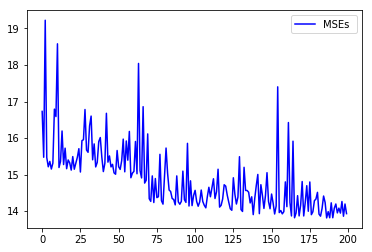

check point at 2019-04-25 13:39:26.598220
training : 宜蘭
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 4s - loss: 5.7438e-0

 - 1s - loss: 4.7056e-04 - val_loss: 4.5301e-04
Epoch : 38, MSE : [9.969635635302044]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 4.7230e-04 - val_loss: 4.6087e-04
Epoch : 39, MSE : [10.140933265547687]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 4.6765e-04 - val_loss: 4.4799e-04
Epoch : 40, MSE : [9.851820726418136]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 4.6300e-04 - val_loss: 4.5758e-04
Epoch : 41, MSE : [10.093222242883268]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 4.6174e-04 - val_loss: 4.5203e-04
Epoch : 42, MSE : [9.942654201376982]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 4.6494e-04 - val_loss: 4.4553e-04
Epoch

 - 1s - loss: 4.4148e-04 - val_loss: 4.3121e-04
Epoch : 82, MSE : [9.417495696565265]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 4.4118e-04 - val_loss: 4.6473e-04
Epoch : 83, MSE : [10.255425947207613]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 4.3622e-04 - val_loss: 4.2128e-04
Epoch : 84, MSE : [9.200052904023524]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 4.4091e-04 - val_loss: 4.2091e-04
Epoch : 85, MSE : [9.192943443779107]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 4.3542e-04 - val_loss: 4.2490e-04
Epoch : 86, MSE : [9.255882380152473]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 4.3551e-04 - val_loss: 4.2390e-04
Epoch 

Epoch : 125, MSE : [9.241458372259514]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 4.3877e-04 - val_loss: 4.3487e-04
Epoch : 126, MSE : [9.44286225937444]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 4.2712e-04 - val_loss: 4.3579e-04
Epoch : 127, MSE : [9.481646310262924]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 4.3249e-04 - val_loss: 4.3315e-04
Epoch : 128, MSE : [9.484870296867845]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 4.2655e-04 - val_loss: 4.1616e-04
Epoch : 129, MSE : [9.064801897892654]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 4.3035e-04 - val_loss: 4.1447e-04
Epoch : 130, MSE : [9.024501116186828]
------------

 - 1s - loss: 4.1827e-04 - val_loss: 4.2773e-04
Epoch : 169, MSE : [9.204729324261653]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 4.1535e-04 - val_loss: 4.4155e-04
Epoch : 170, MSE : [9.585971174761468]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 4.1690e-04 - val_loss: 4.1937e-04
Epoch : 171, MSE : [9.098698623283058]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 4.1805e-04 - val_loss: 4.0731e-04
Epoch : 172, MSE : [8.818370786249023]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 4.2153e-04 - val_loss: 4.0574e-04
Epoch : 173, MSE : [8.779454937635975]
-------------------------------------------
Train on 22189 samples, validate on 5548 samples
Epoch 1/1
 - 1s - loss: 4.1282e-04 - val_loss: 4.0894e-04
Ep

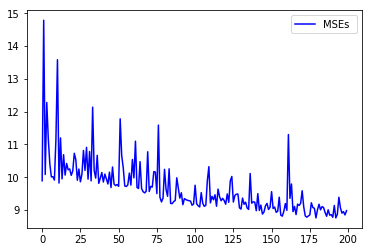

check point at 2019-04-25 13:46:27.473602
training : 三義
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 4s - loss: 7.9758e-0

 - 1s - loss: 5.9192e-04 - val_loss: 5.6314e-04
Epoch : 38, MSE : [24.099688706931907]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 1s - loss: 5.8604e-04 - val_loss: 5.5005e-04
Epoch : 39, MSE : [23.491036635121983]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 1s - loss: 5.8346e-04 - val_loss: 5.4984e-04
Epoch : 40, MSE : [23.504620264776616]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 1s - loss: 5.8382e-04 - val_loss: 5.3148e-04
Epoch : 41, MSE : [22.8139192587704]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 1s - loss: 5.8329e-04 - val_loss: 5.4182e-04
Epoch : 42, MSE : [23.214504006470346]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 1s - loss: 5.8726e-04 - val_loss: 5.3321e-04
Epoc

Epoch : 81, MSE : [24.810407068888097]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 1s - loss: 5.7190e-04 - val_loss: 5.4843e-04
Epoch : 82, MSE : [23.429299049052172]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 1s - loss: 5.7075e-04 - val_loss: 5.5039e-04
Epoch : 83, MSE : [23.50491325362919]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 1s - loss: 5.7168e-04 - val_loss: 5.3606e-04
Epoch : 84, MSE : [22.92898665398201]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 1s - loss: 5.7211e-04 - val_loss: 5.2194e-04
Epoch : 85, MSE : [22.300606438466826]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 1s - loss: 5.7285e-04 - val_loss: 5.3968e-04
Epoch : 86, MSE : [23.141068922746157]
-------------

 - 1s - loss: 5.6556e-04 - val_loss: 5.1220e-04
Epoch : 125, MSE : [22.034556609035317]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 1s - loss: 5.7125e-04 - val_loss: 5.2608e-04
Epoch : 126, MSE : [22.535278203952895]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 1s - loss: 5.6732e-04 - val_loss: 5.1550e-04
Epoch : 127, MSE : [22.096073510482356]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 1s - loss: 5.6421e-04 - val_loss: 5.1214e-04
Epoch : 128, MSE : [21.97756724651198]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 1s - loss: 5.6690e-04 - val_loss: 5.2610e-04
Epoch : 129, MSE : [22.675165156174803]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 1s - loss: 5.6882e-04 - val_loss: 5.1053e-0

 - 1s - loss: 5.6193e-04 - val_loss: 5.4600e-04
Epoch : 168, MSE : [23.406197180028276]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 1s - loss: 5.5646e-04 - val_loss: 5.0424e-04
Epoch : 169, MSE : [21.692653083386865]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 1s - loss: 5.5997e-04 - val_loss: 5.1507e-04
Epoch : 170, MSE : [22.27344510894372]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 1s - loss: 5.5643e-04 - val_loss: 5.0553e-04
Epoch : 171, MSE : [21.741530847145437]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 1s - loss: 5.5815e-04 - val_loss: 5.2052e-04
Epoch : 172, MSE : [22.26966820583301]
-------------------------------------------
Train on 21709 samples, validate on 5428 samples
Epoch 1/1
 - 1s - loss: 5.6333e-04 - val_loss: 5.4421e-04

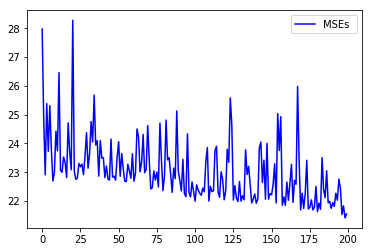

check point at 2019-04-25 13:53:22.755643
training : 新竹
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 4s - loss: 8.7042e-0

 - 1s - loss: 5.5855e-04 - val_loss: 5.6504e-04
Epoch : 38, MSE : [18.750672069790888]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 1s - loss: 5.6193e-04 - val_loss: 5.6910e-04
Epoch : 39, MSE : [18.66795107265571]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 1s - loss: 5.6156e-04 - val_loss: 5.1483e-04
Epoch : 40, MSE : [17.03563449648208]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 1s - loss: 5.6169e-04 - val_loss: 5.2681e-04
Epoch : 41, MSE : [17.437443518441317]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 1s - loss: 5.6165e-04 - val_loss: 5.1778e-04
Epoch : 42, MSE : [17.17068969359029]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 1s - loss: 5.6253e-04 - val_loss: 5.0195e-04
Epoch

Epoch : 81, MSE : [15.561817085355473]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 1s - loss: 5.2822e-04 - val_loss: 4.7030e-04
Epoch : 82, MSE : [15.709895583026528]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 1s - loss: 5.1921e-04 - val_loss: 4.8052e-04
Epoch : 83, MSE : [16.038885285966735]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 1s - loss: 5.2154e-04 - val_loss: 4.9258e-04
Epoch : 84, MSE : [16.418418818286575]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 1s - loss: 5.2626e-04 - val_loss: 4.6619e-04
Epoch : 85, MSE : [15.603509567739179]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 1s - loss: 5.2234e-04 - val_loss: 4.6962e-04
Epoch : 86, MSE : [15.68572303312129]
------------

 - 1s - loss: 5.0093e-04 - val_loss: 4.6866e-04
Epoch : 125, MSE : [15.59500364048111]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 1s - loss: 5.0812e-04 - val_loss: 4.6246e-04
Epoch : 126, MSE : [15.28023475319066]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 1s - loss: 4.9908e-04 - val_loss: 4.6794e-04
Epoch : 127, MSE : [15.46197988369809]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 1s - loss: 4.9913e-04 - val_loss: 4.4947e-04
Epoch : 128, MSE : [14.92167205591598]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 1s - loss: 4.9944e-04 - val_loss: 5.1190e-04
Epoch : 129, MSE : [16.828336494835163]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 1s - loss: 4.9755e-04 - val_loss: 4.6507e-04
E

 - 1s - loss: 4.8415e-04 - val_loss: 4.5941e-04
Epoch : 168, MSE : [15.093388650539119]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 1s - loss: 4.8850e-04 - val_loss: 4.5536e-04
Epoch : 169, MSE : [15.005647402101548]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 1s - loss: 4.8278e-04 - val_loss: 4.9073e-04
Epoch : 170, MSE : [16.205814323226377]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 1s - loss: 4.8514e-04 - val_loss: 4.6045e-04
Epoch : 171, MSE : [15.078224885797008]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 1s - loss: 4.8285e-04 - val_loss: 4.4833e-04
Epoch : 172, MSE : [14.779882556912789]
-------------------------------------------
Train on 22861 samples, validate on 5716 samples
Epoch 1/1
 - 1s - loss: 4.8677e-04 - val_loss: 4.7097e-

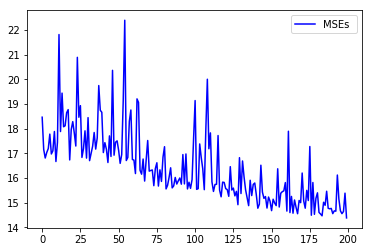

check point at 2019-04-25 14:00:45.160695
training : 湖口
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 4s - loss: 0.0011 - 

 - 1s - loss: 7.3999e-04 - val_loss: 6.5703e-04
Epoch : 38, MSE : [21.050854582155722]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 1s - loss: 7.4393e-04 - val_loss: 7.1735e-04
Epoch : 39, MSE : [22.82489145994818]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 1s - loss: 7.3018e-04 - val_loss: 6.7530e-04
Epoch : 40, MSE : [21.4697392161478]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 1s - loss: 7.5040e-04 - val_loss: 6.6445e-04
Epoch : 41, MSE : [21.314273038470926]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 1s - loss: 7.4480e-04 - val_loss: 6.9885e-04
Epoch : 42, MSE : [22.148296130069788]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 1s - loss: 7.4015e-04 - val_loss: 7.0965e-04
Epoch

Epoch : 81, MSE : [21.865315328713788]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 1s - loss: 7.3181e-04 - val_loss: 6.7974e-04
Epoch : 82, MSE : [21.892528584916413]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 1s - loss: 7.2878e-04 - val_loss: 7.0542e-04
Epoch : 83, MSE : [22.817363520869126]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 1s - loss: 7.3614e-04 - val_loss: 6.5732e-04
Epoch : 84, MSE : [21.27292699459331]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 1s - loss: 7.3652e-04 - val_loss: 6.4542e-04
Epoch : 85, MSE : [21.02524485214458]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 1s - loss: 7.3059e-04 - val_loss: 6.7934e-04
Epoch : 86, MSE : [21.80924418872006]
--------------

 - 1s - loss: 7.2741e-04 - val_loss: 6.7468e-04
Epoch : 125, MSE : [21.695253119107864]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 1s - loss: 7.2175e-04 - val_loss: 6.4417e-04
Epoch : 126, MSE : [20.96996837992714]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 1s - loss: 7.2362e-04 - val_loss: 6.5230e-04
Epoch : 127, MSE : [21.207532116142115]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 1s - loss: 7.2771e-04 - val_loss: 6.5645e-04
Epoch : 128, MSE : [21.26959357815317]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 1s - loss: 7.2259e-04 - val_loss: 7.1574e-04
Epoch : 129, MSE : [23.269430681141753]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 1s - loss: 7.3606e-04 - val_loss: 6.6250e-04

 - 1s - loss: 7.2206e-04 - val_loss: 7.0644e-04
Epoch : 168, MSE : [22.600204658438376]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 1s - loss: 7.2082e-04 - val_loss: 6.6262e-04
Epoch : 169, MSE : [21.38634025307404]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 1s - loss: 7.2094e-04 - val_loss: 7.1827e-04
Epoch : 170, MSE : [23.033419553124016]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 1s - loss: 7.2244e-04 - val_loss: 6.6420e-04
Epoch : 171, MSE : [21.428445545704047]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 1s - loss: 7.1968e-04 - val_loss: 6.5316e-04
Epoch : 172, MSE : [21.08847429793881]
-------------------------------------------
Train on 20788 samples, validate on 5197 samples
Epoch 1/1
 - 1s - loss: 7.1855e-04 - val_loss: 6.4139e-04

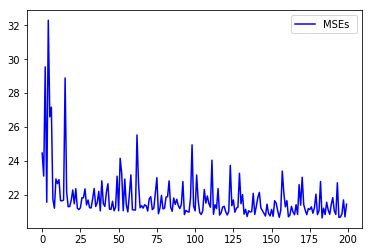

check point at 2019-04-25 14:07:37.911673
training : 竹東
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 4s - loss: 0.0011 - 

 - 1s - loss: 9.2195e-04 - val_loss: 9.1886e-04
Epoch : 38, MSE : [23.875483736367052]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 9.1760e-04 - val_loss: 9.3681e-04
Epoch : 39, MSE : [24.116392659686664]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 9.2301e-04 - val_loss: 9.3646e-04
Epoch : 40, MSE : [24.176889501725327]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 9.2212e-04 - val_loss: 0.0010
Epoch : 41, MSE : [26.704486773674635]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 9.1910e-04 - val_loss: 9.1167e-04
Epoch : 42, MSE : [23.629914662151673]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 9.1093e-04 - val_loss: 9.3896e-04
Epoch 

 - 1s - loss: 9.0037e-04 - val_loss: 0.0010
Epoch : 82, MSE : [25.706556754698738]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 8.9589e-04 - val_loss: 9.8062e-04
Epoch : 83, MSE : [25.114786736792023]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 8.9665e-04 - val_loss: 9.8210e-04
Epoch : 84, MSE : [25.13353989658259]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 8.9816e-04 - val_loss: 9.4606e-04
Epoch : 85, MSE : [24.146656278667255]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 8.9749e-04 - val_loss: 9.3600e-04
Epoch : 86, MSE : [23.811204604266095]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 8.9617e-04 - val_loss: 9.3293e-04
Epoch :

Epoch : 125, MSE : [23.110819486145207]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 8.9806e-04 - val_loss: 9.2217e-04
Epoch : 126, MSE : [23.498122804416333]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 8.9297e-04 - val_loss: 9.0375e-04
Epoch : 127, MSE : [23.08901829367228]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 8.8710e-04 - val_loss: 9.3389e-04
Epoch : 128, MSE : [23.86532093729781]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 8.8634e-04 - val_loss: 9.3675e-04
Epoch : 129, MSE : [23.67600773051199]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 8.9322e-04 - val_loss: 9.2087e-04
Epoch : 130, MSE : [23.49121204241597]
---------

 - 1s - loss: 8.8812e-04 - val_loss: 9.2245e-04
Epoch : 169, MSE : [23.398639420321693]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 8.8066e-04 - val_loss: 9.1931e-04
Epoch : 170, MSE : [23.384277770460944]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 8.8599e-04 - val_loss: 9.6623e-04
Epoch : 171, MSE : [24.72910523339704]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 8.7986e-04 - val_loss: 9.1685e-04
Epoch : 172, MSE : [23.192919458017602]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 8.8741e-04 - val_loss: 9.2999e-04
Epoch : 173, MSE : [23.482498189330933]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 8.8110e-04 - val_loss: 9.3220e-0

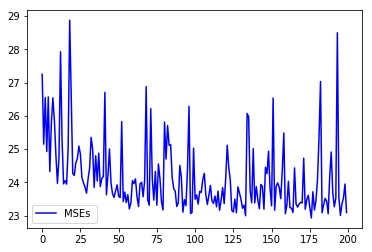

check point at 2019-04-25 14:14:37.130925
training : 苗栗
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 4s - loss: 0.0021 - 

Epoch : 39, MSE : [39.49959596152319]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 1s - loss: 0.0016 - val_loss: 0.0015
Epoch : 40, MSE : [35.177429789930514]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 1s - loss: 0.0016 - val_loss: 0.0015
Epoch : 41, MSE : [35.24843673103494]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 1s - loss: 0.0016 - val_loss: 0.0017
Epoch : 42, MSE : [39.00549407835279]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 1s - loss: 0.0016 - val_loss: 0.0015
Epoch : 43, MSE : [34.700152167965136]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 1s - loss: 0.0016 - val_loss: 0.0015
Epoch : 44, MSE : [34.8102811914989]
-------------------------------------------
Train on 200

 - 1s - loss: 0.0016 - val_loss: 0.0015
Epoch : 85, MSE : [34.794666766134725]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 1s - loss: 0.0016 - val_loss: 0.0016
Epoch : 86, MSE : [35.85464810008508]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 1s - loss: 0.0016 - val_loss: 0.0015
Epoch : 87, MSE : [35.51463292503657]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 1s - loss: 0.0015 - val_loss: 0.0015
Epoch : 88, MSE : [34.39281843624685]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 1s - loss: 0.0015 - val_loss: 0.0017
Epoch : 89, MSE : [39.4205550319839]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 1s - loss: 0.0015 - val_loss: 0.0016
Epoch : 90, MSE : [36.56777283929934]
-----------------

Epoch : 130, MSE : [43.92742630113215]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 1s - loss: 0.0015 - val_loss: 0.0015
Epoch : 131, MSE : [34.18976892963749]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 1s - loss: 0.0015 - val_loss: 0.0015
Epoch : 132, MSE : [34.38046589720651]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 1s - loss: 0.0015 - val_loss: 0.0015
Epoch : 133, MSE : [34.43962591157904]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 1s - loss: 0.0015 - val_loss: 0.0015
Epoch : 134, MSE : [33.79773808039411]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 1s - loss: 0.0015 - val_loss: 0.0015
Epoch : 135, MSE : [34.591068148071706]
-------------------------------------------
Train 

Epoch : 175, MSE : [32.986773802286656]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 1s - loss: 0.0015 - val_loss: 0.0015
Epoch : 176, MSE : [32.956836390665025]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 1s - loss: 0.0015 - val_loss: 0.0014
Epoch : 177, MSE : [32.86362539441725]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 1s - loss: 0.0015 - val_loss: 0.0014
Epoch : 178, MSE : [32.87678608438883]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 1s - loss: 0.0015 - val_loss: 0.0015
Epoch : 179, MSE : [33.153224508902206]
-------------------------------------------
Train on 20096 samples, validate on 5025 samples
Epoch 1/1
 - 1s - loss: 0.0015 - val_loss: 0.0015
Epoch : 180, MSE : [33.815177880093955]
-------------------------------------------
Tra

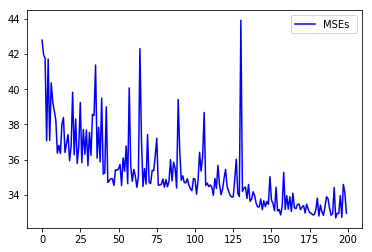

check point at 2019-04-25 14:21:27.678939
training : 頭份
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 4s - loss: 0.0010 - 

 - 1s - loss: 7.4216e-04 - val_loss: 7.7178e-04
Epoch : 38, MSE : [19.726310087274747]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 1s - loss: 7.3717e-04 - val_loss: 7.4917e-04
Epoch : 39, MSE : [19.24101484662231]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 1s - loss: 7.3797e-04 - val_loss: 7.4596e-04
Epoch : 40, MSE : [19.450881984293105]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 1s - loss: 7.3260e-04 - val_loss: 7.3019e-04
Epoch : 41, MSE : [18.941029285336903]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 1s - loss: 7.3376e-04 - val_loss: 7.4155e-04
Epoch : 42, MSE : [19.08988724220395]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 1s - loss: 7.3636e-04 - val_loss: 7.5552e-04
Epoc

Epoch : 81, MSE : [19.04717960229918]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 1s - loss: 7.0317e-04 - val_loss: 7.0799e-04
Epoch : 82, MSE : [18.34088953752529]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 1s - loss: 7.0072e-04 - val_loss: 7.0166e-04
Epoch : 83, MSE : [17.99304803683079]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 1s - loss: 6.9444e-04 - val_loss: 7.2187e-04
Epoch : 84, MSE : [18.804484303119576]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 1s - loss: 6.9937e-04 - val_loss: 7.3885e-04
Epoch : 85, MSE : [18.850574961149764]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 1s - loss: 6.9775e-04 - val_loss: 7.5948e-04
Epoch : 86, MSE : [19.533046214872112]
--------------

 - 1s - loss: 6.9294e-04 - val_loss: 6.9841e-04
Epoch : 125, MSE : [17.978282064880762]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 1s - loss: 7.0033e-04 - val_loss: 7.1353e-04
Epoch : 126, MSE : [18.531265980630703]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 1s - loss: 6.9492e-04 - val_loss: 7.1579e-04
Epoch : 127, MSE : [18.423637160592968]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 1s - loss: 6.9351e-04 - val_loss: 7.0121e-04
Epoch : 128, MSE : [18.024634666526822]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 1s - loss: 7.0040e-04 - val_loss: 7.0588e-04
Epoch : 129, MSE : [18.28941308784785]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 1s - loss: 6.9654e-04 - val_loss: 7.0654e-0

 - 1s - loss: 6.9371e-04 - val_loss: 7.0348e-04
Epoch : 168, MSE : [18.09503221689214]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 1s - loss: 6.9651e-04 - val_loss: 7.3001e-04
Epoch : 169, MSE : [18.595477499165483]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 1s - loss: 6.9432e-04 - val_loss: 7.0834e-04
Epoch : 170, MSE : [18.24810993524372]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 1s - loss: 6.9460e-04 - val_loss: 7.1060e-04
Epoch : 171, MSE : [18.407816340929127]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 1s - loss: 6.9364e-04 - val_loss: 7.0711e-04
Epoch : 172, MSE : [18.354498814962025]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 1s - loss: 6.9426e-04 - val_loss: 7.0691e-04

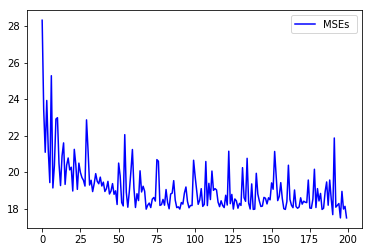

check point at 2019-04-25 14:29:19.784940
training : 臺東
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 4s - loss: 0.0015 - 

Epoch : 39, MSE : [7.713512401036098]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 1s - loss: 0.0012 - val_loss: 0.0013
Epoch : 40, MSE : [7.275057598902321]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 1s - loss: 0.0012 - val_loss: 0.0011
Epoch : 41, MSE : [6.611350757674915]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 42, MSE : [6.714828323216278]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 1s - loss: 0.0012 - val_loss: 0.0012
Epoch : 43, MSE : [6.644697830819285]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 1s - loss: 0.0012 - val_loss: 0.0012
Epoch : 44, MSE : [6.701818180438787]
-------------------------------------------
Train on 2349

 - 1s - loss: 0.0012 - val_loss: 0.0011
Epoch : 85, MSE : [6.566689824716281]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0014
Epoch : 86, MSE : [8.086148122475363]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 87, MSE : [6.885904684605377]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 1s - loss: 0.0012 - val_loss: 0.0012
Epoch : 88, MSE : [6.64203829522044]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0013
Epoch : 89, MSE : [7.681660812999857]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 90, MSE : [6.632663294735571]
------------------

Epoch : 130, MSE : [7.073030760535442]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0011
Epoch : 131, MSE : [6.5769817245190305]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 1s - loss: 0.0012 - val_loss: 0.0011
Epoch : 132, MSE : [6.512663078817343]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 133, MSE : [6.661393674683248]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 134, MSE : [6.787732931885681]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 1s - loss: 0.0012 - val_loss: 0.0012
Epoch : 135, MSE : [6.614765317473989]
-------------------------------------------
Train 

Epoch : 175, MSE : [6.60872942802074]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 1s - loss: 0.0012 - val_loss: 0.0011
Epoch : 176, MSE : [6.505131151266275]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0011
Epoch : 177, MSE : [6.523325176172036]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0011
Epoch : 178, MSE : [6.499638194432975]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 1s - loss: 0.0012 - val_loss: 0.0011
Epoch : 179, MSE : [6.470739014951991]
-------------------------------------------
Train on 23495 samples, validate on 5874 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0011
Epoch : 180, MSE : [6.550922168550108]
-------------------------------------------
Train on

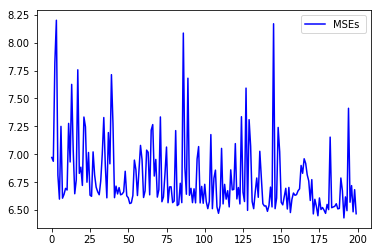

check point at 2019-04-25 14:37:39.185812
training : 花蓮
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 5s - loss: 0.0011 - 

 - 1s - loss: 7.9673e-04 - val_loss: 8.2235e-04
Epoch : 38, MSE : [10.747324844106375]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 1s - loss: 7.9462e-04 - val_loss: 7.7701e-04
Epoch : 39, MSE : [10.192424846724762]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 1s - loss: 8.0813e-04 - val_loss: 8.1982e-04
Epoch : 40, MSE : [10.795550339371731]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 1s - loss: 7.9723e-04 - val_loss: 9.7688e-04
Epoch : 41, MSE : [12.721948280916234]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 1s - loss: 8.0662e-04 - val_loss: 7.8891e-04
Epoch : 42, MSE : [10.36509356929176]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 1s - loss: 7.9906e-04 - val_loss: 8.0783e-04
Epo

Epoch : 81, MSE : [10.656248710244057]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 1s - loss: 7.9806e-04 - val_loss: 8.1004e-04
Epoch : 82, MSE : [10.63527745835904]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 1s - loss: 7.9215e-04 - val_loss: 7.7648e-04
Epoch : 83, MSE : [10.156546450789262]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 1s - loss: 7.9562e-04 - val_loss: 7.8278e-04
Epoch : 84, MSE : [10.263237152922848]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 1s - loss: 7.8942e-04 - val_loss: 7.8134e-04
Epoch : 85, MSE : [10.247200567251861]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 1s - loss: 7.9553e-04 - val_loss: 8.2078e-04
Epoch : 86, MSE : [10.732339699866918]
------------

 - 1s - loss: 7.8991e-04 - val_loss: 8.2771e-04
Epoch : 125, MSE : [10.845486301831684]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 1s - loss: 7.9415e-04 - val_loss: 7.7556e-04
Epoch : 126, MSE : [10.153980078711294]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 1s - loss: 7.9374e-04 - val_loss: 8.4242e-04
Epoch : 127, MSE : [11.050894884941785]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 1s - loss: 7.9215e-04 - val_loss: 7.7915e-04
Epoch : 128, MSE : [10.198928324197226]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 1s - loss: 7.9105e-04 - val_loss: 7.7681e-04
Epoch : 129, MSE : [10.174672031926425]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 1s - loss: 7.9279e-04 - val_loss: 7.8942e-

 - 1s - loss: 7.9153e-04 - val_loss: 8.0716e-04
Epoch : 168, MSE : [10.566114996068993]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 1s - loss: 7.8715e-04 - val_loss: 8.0888e-04
Epoch : 169, MSE : [10.513276804629106]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 1s - loss: 7.9183e-04 - val_loss: 7.9322e-04
Epoch : 170, MSE : [10.34911387956118]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 1s - loss: 7.9529e-04 - val_loss: 7.8555e-04
Epoch : 171, MSE : [10.257396848685477]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 1s - loss: 7.9286e-04 - val_loss: 7.7669e-04
Epoch : 172, MSE : [10.172970630531845]
-------------------------------------------
Train on 20711 samples, validate on 5178 samples
Epoch 1/1
 - 1s - loss: 7.8722e-04 - val_loss: 8.3922e-0

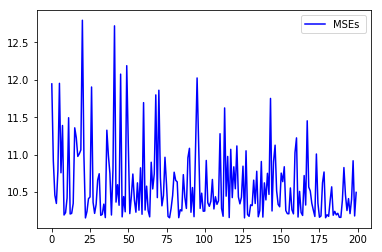

check point at 2019-04-25 14:45:05.621819
training : 關山
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 5s - loss: 0.0012 - 

 - 1s - loss: 8.7956e-04 - val_loss: 8.4594e-04
Epoch : 38, MSE : [5.384675434345627]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 2s - loss: 8.8061e-04 - val_loss: 8.5456e-04
Epoch : 39, MSE : [5.446141602603358]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 2s - loss: 8.7712e-04 - val_loss: 8.7118e-04
Epoch : 40, MSE : [5.5554125957910605]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 1s - loss: 8.8069e-04 - val_loss: 8.6370e-04
Epoch : 41, MSE : [5.502170262756502]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 2s - loss: 8.6763e-04 - val_loss: 8.3449e-04
Epoch : 42, MSE : [5.320925596928889]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 2s - loss: 8.7546e-04 - val_loss: 8.4942e-04
Epoch 

 - 1s - loss: 8.7013e-04 - val_loss: 9.2543e-04
Epoch : 82, MSE : [5.8457591844577195]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 2s - loss: 8.6659e-04 - val_loss: 8.6748e-04
Epoch : 83, MSE : [5.501256569100469]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 2s - loss: 8.6628e-04 - val_loss: 8.3552e-04
Epoch : 84, MSE : [5.3262622236704225]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 1s - loss: 8.6433e-04 - val_loss: 8.8207e-04
Epoch : 85, MSE : [5.635748737196031]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 2s - loss: 8.6813e-04 - val_loss: 9.8125e-04
Epoch : 86, MSE : [6.281563305382945]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 2s - loss: 8.7047e-04 - val_loss: 8.6869e-04
Epoch

Epoch : 125, MSE : [5.455910662992073]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 1s - loss: 8.6329e-04 - val_loss: 9.0844e-04
Epoch : 126, MSE : [5.706739473490283]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 2s - loss: 8.6103e-04 - val_loss: 8.4722e-04
Epoch : 127, MSE : [5.361400810853191]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 2s - loss: 8.5689e-04 - val_loss: 9.4338e-04
Epoch : 128, MSE : [6.026902548034123]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 1s - loss: 8.5596e-04 - val_loss: 8.9038e-04
Epoch : 129, MSE : [5.672156611112246]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 2s - loss: 8.6022e-04 - val_loss: 8.3654e-04
Epoch : 130, MSE : [5.313454176512167]
-----------

 - 2s - loss: 8.5370e-04 - val_loss: 8.8403e-04
Epoch : 169, MSE : [5.556659584585888]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 1s - loss: 8.5787e-04 - val_loss: 8.4448e-04
Epoch : 170, MSE : [5.350721931582018]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 2s - loss: 8.6134e-04 - val_loss: 8.3699e-04
Epoch : 171, MSE : [5.302847291278961]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 2s - loss: 8.5395e-04 - val_loss: 9.5785e-04
Epoch : 172, MSE : [6.119178313033503]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 1s - loss: 8.5922e-04 - val_loss: 8.5300e-04
Epoch : 173, MSE : [5.425899602673195]
-------------------------------------------
Train on 23188 samples, validate on 5797 samples
Epoch 1/1
 - 2s - loss: 8.6048e-04 - val_loss: 8.3220e-04
Ep

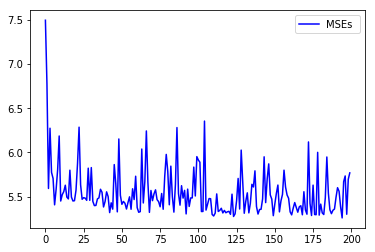

check point at 2019-04-25 14:53:30.147314
training : 金門
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 5s - loss: 2.5371e-0

 - 2s - loss: 1.5021e-04 - val_loss: 1.2606e-04
Epoch : 38, MSE : [28.646663985267335]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 1s - loss: 1.4828e-04 - val_loss: 1.2661e-04
Epoch : 39, MSE : [28.40608155192291]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 2s - loss: 1.5079e-04 - val_loss: 1.1862e-04
Epoch : 40, MSE : [27.05475325094112]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 2s - loss: 1.4994e-04 - val_loss: 1.2597e-04
Epoch : 41, MSE : [28.024083239499564]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 1s - loss: 1.5119e-04 - val_loss: 1.1858e-04
Epoch : 42, MSE : [26.883182810233624]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 2s - loss: 1.5138e-04 - val_loss: 1.2296e-04
Epoc

Epoch : 81, MSE : [28.348265450880078]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 2s - loss: 1.4639e-04 - val_loss: 1.3093e-04
Epoch : 82, MSE : [29.09796027051803]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 1s - loss: 1.4727e-04 - val_loss: 1.1945e-04
Epoch : 83, MSE : [26.97353476234151]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 2s - loss: 1.4604e-04 - val_loss: 1.2772e-04
Epoch : 84, MSE : [28.816437309050492]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 2s - loss: 1.4857e-04 - val_loss: 1.2752e-04
Epoch : 85, MSE : [28.21997497591436]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 1s - loss: 1.4751e-04 - val_loss: 1.1859e-04
Epoch : 86, MSE : [26.813803384458247]
--------------

 - 2s - loss: 1.4643e-04 - val_loss: 1.2106e-04
Epoch : 125, MSE : [27.011381267422276]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 1s - loss: 1.4506e-04 - val_loss: 1.2553e-04
Epoch : 126, MSE : [28.02596373234328]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 2s - loss: 1.4685e-04 - val_loss: 1.2672e-04
Epoch : 127, MSE : [28.058221406628924]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 2s - loss: 1.4683e-04 - val_loss: 1.6971e-04
Epoch : 128, MSE : [36.154047365037044]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 1s - loss: 1.4892e-04 - val_loss: 1.1851e-04
Epoch : 129, MSE : [26.676189709842664]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 2s - loss: 1.4737e-04 - val_loss: 1.3656e-0

 - 2s - loss: 1.4509e-04 - val_loss: 1.2318e-04
Epoch : 168, MSE : [27.29045563291332]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 2s - loss: 1.4434e-04 - val_loss: 1.2661e-04
Epoch : 169, MSE : [27.840068224639797]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 2s - loss: 1.4464e-04 - val_loss: 1.1951e-04
Epoch : 170, MSE : [26.743296635948752]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 2s - loss: 1.4399e-04 - val_loss: 1.1824e-04
Epoch : 171, MSE : [26.331461667276162]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 1s - loss: 1.4348e-04 - val_loss: 1.1839e-04
Epoch : 172, MSE : [26.64004031494054]
-------------------------------------------
Train on 23284 samples, validate on 5821 samples
Epoch 1/1
 - 2s - loss: 1.4499e-04 - val_loss: 1.2929e-04

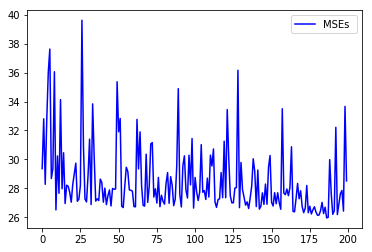

check point at 2019-04-25 15:02:06.625061
training : 馬公
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 5s - loss: 3.7242e-0

 - 1s - loss: 2.0108e-04 - val_loss: 1.7439e-04
Epoch : 38, MSE : [18.36738831109066]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 1s - loss: 2.0074e-04 - val_loss: 1.5517e-04
Epoch : 39, MSE : [16.29640895498353]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 1s - loss: 1.9694e-04 - val_loss: 1.8735e-04
Epoch : 40, MSE : [19.24123634723526]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 1s - loss: 2.0003e-04 - val_loss: 1.7911e-04
Epoch : 41, MSE : [18.32876722109925]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 1s - loss: 1.9987e-04 - val_loss: 1.9551e-04
Epoch : 42, MSE : [20.28562623777056]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 1s - loss: 1.9727e-04 - val_loss: 1.6282e-04
Epoch :

Epoch : 81, MSE : [16.397205744648502]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 1s - loss: 2.0019e-04 - val_loss: 1.7974e-04
Epoch : 82, MSE : [18.898018764517904]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 1s - loss: 1.9451e-04 - val_loss: 1.5317e-04
Epoch : 83, MSE : [16.45966779471206]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 1s - loss: 1.9292e-04 - val_loss: 1.6147e-04
Epoch : 84, MSE : [17.011775102042144]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 1s - loss: 1.9867e-04 - val_loss: 1.6100e-04
Epoch : 85, MSE : [17.07944220277908]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 1s - loss: 1.9553e-04 - val_loss: 1.5493e-04
Epoch : 86, MSE : [16.31722461077275]
--------------

 - 1s - loss: 1.9271e-04 - val_loss: 1.6270e-04
Epoch : 125, MSE : [17.24655345469694]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 1s - loss: 1.9541e-04 - val_loss: 1.4901e-04
Epoch : 126, MSE : [15.904429994197335]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 1s - loss: 1.9341e-04 - val_loss: 1.5286e-04
Epoch : 127, MSE : [16.274844866724774]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 1s - loss: 1.9414e-04 - val_loss: 1.7760e-04
Epoch : 128, MSE : [18.71537469111263]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 1s - loss: 1.9373e-04 - val_loss: 1.5410e-04
Epoch : 129, MSE : [16.241515220490758]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 1s - loss: 1.9234e-04 - val_loss: 1.5384e-04

 - 1s - loss: 1.9240e-04 - val_loss: 1.4854e-04
Epoch : 168, MSE : [15.897800208628098]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 1s - loss: 1.9060e-04 - val_loss: 1.5474e-04
Epoch : 169, MSE : [16.34371218254231]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 1s - loss: 1.9175e-04 - val_loss: 1.6113e-04
Epoch : 170, MSE : [16.812084150635265]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 1s - loss: 1.9535e-04 - val_loss: 1.5063e-04
Epoch : 171, MSE : [16.057044008771378]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 1s - loss: 1.8969e-04 - val_loss: 1.7193e-04
Epoch : 172, MSE : [17.62059990558983]
-------------------------------------------
Train on 20346 samples, validate on 5087 samples
Epoch 1/1
 - 1s - loss: 1.9859e-04 - val_loss: 1.5960e-04

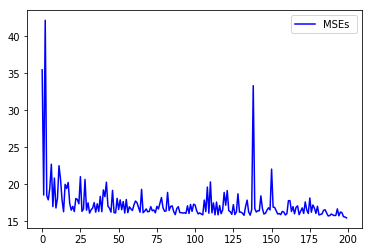

check point at 2019-04-25 15:09:50.044196
training : 馬祖
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 5s - loss: 3.5119e-0

 - 1s - loss: 2.3780e-04 - val_loss: 2.1631e-04
Epoch : 38, MSE : [18.7900626228609]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 2s - loss: 2.4007e-04 - val_loss: 2.1405e-04
Epoch : 39, MSE : [18.621043416524802]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 2s - loss: 2.3965e-04 - val_loss: 2.1696e-04
Epoch : 40, MSE : [18.793435099298602]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 2s - loss: 2.4086e-04 - val_loss: 2.4512e-04
Epoch : 41, MSE : [21.231955548977467]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 2s - loss: 2.3947e-04 - val_loss: 2.1482e-04
Epoch : 42, MSE : [18.57869223846281]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 1s - loss: 2.4233e-04 - val_loss: 2.0917e-04
Epoch

Epoch : 81, MSE : [20.35838053765927]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 2s - loss: 2.3895e-04 - val_loss: 2.1157e-04
Epoch : 82, MSE : [18.39885588543987]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 2s - loss: 2.3563e-04 - val_loss: 2.2965e-04
Epoch : 83, MSE : [19.92154899401023]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 2s - loss: 2.3442e-04 - val_loss: 2.5313e-04
Epoch : 84, MSE : [21.985247268490873]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 2s - loss: 2.3737e-04 - val_loss: 2.0730e-04
Epoch : 85, MSE : [18.012226202683237]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 1s - loss: 2.3414e-04 - val_loss: 2.0786e-04
Epoch : 86, MSE : [17.9789289274022]
----------------

 - 2s - loss: 2.2921e-04 - val_loss: 2.1407e-04
Epoch : 125, MSE : [18.47609345720712]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 2s - loss: 2.3241e-04 - val_loss: 2.1042e-04
Epoch : 126, MSE : [18.126032634352704]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 2s - loss: 2.2588e-04 - val_loss: 2.5708e-04
Epoch : 127, MSE : [22.370560265246336]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 2s - loss: 2.3552e-04 - val_loss: 2.4060e-04
Epoch : 128, MSE : [20.815110208592728]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 2s - loss: 2.3242e-04 - val_loss: 2.0750e-04
Epoch : 129, MSE : [17.9105452471692]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 2s - loss: 2.3266e-04 - val_loss: 2.2141e-04


 - 2s - loss: 2.2962e-04 - val_loss: 2.1298e-04
Epoch : 168, MSE : [18.353164676720862]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 2s - loss: 2.2387e-04 - val_loss: 2.0964e-04
Epoch : 169, MSE : [18.139282471678314]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 2s - loss: 2.2584e-04 - val_loss: 2.2034e-04
Epoch : 170, MSE : [19.016166676880506]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 2s - loss: 2.2905e-04 - val_loss: 2.2369e-04
Epoch : 171, MSE : [19.58814492952328]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 1s - loss: 2.2804e-04 - val_loss: 2.5391e-04
Epoch : 172, MSE : [21.92360914821485]
-------------------------------------------
Train on 22765 samples, validate on 5692 samples
Epoch 1/1
 - 2s - loss: 2.2774e-04 - val_loss: 2.0232e-04

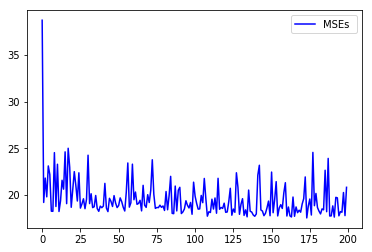

check point at 2019-04-25 15:18:30.537272
training : 臺南
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 5s - loss: 0.0014 - 

 - 1s - loss: 9.3880e-04 - val_loss: 9.0805e-04
Epoch : 38, MSE : [34.94452371801315]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 9.2807e-04 - val_loss: 8.6658e-04
Epoch : 39, MSE : [33.25430012765947]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 9.3733e-04 - val_loss: 8.9024e-04
Epoch : 40, MSE : [34.140502395564084]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 9.3086e-04 - val_loss: 8.3967e-04
Epoch : 41, MSE : [32.32727815969679]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 9.1140e-04 - val_loss: 8.6772e-04
Epoch : 42, MSE : [33.30890578780689]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 8.9481e-04 - val_loss: 8.0958e-04
Epoch 

 - 1s - loss: 8.7495e-04 - val_loss: 8.5770e-04
Epoch : 82, MSE : [32.897747663771405]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 8.7610e-04 - val_loss: 8.2830e-04
Epoch : 83, MSE : [32.00106327879413]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 8.6775e-04 - val_loss: 8.0445e-04
Epoch : 84, MSE : [30.9271218775499]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 8.6337e-04 - val_loss: 7.9488e-04
Epoch : 85, MSE : [30.607983141930315]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 8.6799e-04 - val_loss: 8.7772e-04
Epoch : 86, MSE : [33.53598216726948]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 8.6921e-04 - val_loss: 7.9585e-04
Epoch 

Epoch : 125, MSE : [32.62908762966388]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 8.3930e-04 - val_loss: 7.8133e-04
Epoch : 126, MSE : [29.776921974659125]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 8.3460e-04 - val_loss: 8.2329e-04
Epoch : 127, MSE : [31.755429271227683]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 8.3922e-04 - val_loss: 7.7883e-04
Epoch : 128, MSE : [29.835006724019777]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 8.3353e-04 - val_loss: 7.6831e-04
Epoch : 129, MSE : [29.683367179029407]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 8.2985e-04 - val_loss: 8.8219e-04
Epoch : 130, MSE : [33.79967480538435]
-------

Epoch : 168, MSE : [29.85064604626296]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 8.2003e-04 - val_loss: 7.9697e-04
Epoch : 169, MSE : [30.31522217242748]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 8.1925e-04 - val_loss: 7.5870e-04
Epoch : 170, MSE : [29.13982858407587]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 8.2321e-04 - val_loss: 7.6664e-04
Epoch : 171, MSE : [29.313024838440658]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 8.1856e-04 - val_loss: 7.9112e-04
Epoch : 172, MSE : [30.459143475625332]
-------------------------------------------
Train on 20749 samples, validate on 5188 samples
Epoch 1/1
 - 1s - loss: 8.2960e-04 - val_loss: 7.6304e-04
Epoch : 173, MSE : [29.318925163421753]
--------

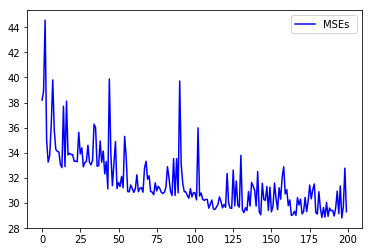

check point at 2019-04-25 15:26:27.283556
training : 臺西
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 5s - loss: 0.0011 - 

 - 2s - loss: 7.0358e-04 - val_loss: 6.6129e-04
Epoch : 38, MSE : [27.244176578906156]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 1s - loss: 6.9603e-04 - val_loss: 6.6939e-04
Epoch : 39, MSE : [27.543537449724937]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 2s - loss: 6.9544e-04 - val_loss: 6.5508e-04
Epoch : 40, MSE : [26.989271557636453]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 1s - loss: 6.9829e-04 - val_loss: 6.7045e-04
Epoch : 41, MSE : [27.577249596312708]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 2s - loss: 6.9161e-04 - val_loss: 8.7179e-04
Epoch : 42, MSE : [35.56768106280775]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 1s - loss: 6.9588e-04 - val_loss: 6.6211e-04
Epo

Epoch : 81, MSE : [25.147734121080383]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 2s - loss: 6.5244e-04 - val_loss: 6.1502e-04
Epoch : 82, MSE : [25.422315512717425]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 1s - loss: 6.4994e-04 - val_loss: 6.1460e-04
Epoch : 83, MSE : [25.394919960151395]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 2s - loss: 6.5226e-04 - val_loss: 6.5790e-04
Epoch : 84, MSE : [26.987508197955787]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 1s - loss: 6.5080e-04 - val_loss: 6.0998e-04
Epoch : 85, MSE : [25.061672976382848]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 2s - loss: 6.5396e-04 - val_loss: 6.2261e-04
Epoch : 86, MSE : [25.442247438501678]
-----------

 - 2s - loss: 6.3796e-04 - val_loss: 6.0045e-04
Epoch : 125, MSE : [24.701580433770474]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 2s - loss: 6.3715e-04 - val_loss: 6.1665e-04
Epoch : 126, MSE : [25.265289096726104]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 1s - loss: 6.4213e-04 - val_loss: 6.0857e-04
Epoch : 127, MSE : [25.296446542093733]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 2s - loss: 6.3692e-04 - val_loss: 6.1795e-04
Epoch : 128, MSE : [25.767326881773727]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 2s - loss: 6.4188e-04 - val_loss: 6.2079e-04
Epoch : 129, MSE : [25.712070981220688]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 2s - loss: 6.4053e-04 - val_loss: 6.2744e-

 - 2s - loss: 6.2426e-04 - val_loss: 5.7768e-04
Epoch : 168, MSE : [24.39577681798931]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 1s - loss: 6.2473e-04 - val_loss: 5.9219e-04
Epoch : 169, MSE : [24.729246537690972]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 2s - loss: 6.2409e-04 - val_loss: 5.9917e-04
Epoch : 170, MSE : [25.07191517573296]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 1s - loss: 6.2588e-04 - val_loss: 5.9317e-04
Epoch : 171, MSE : [25.052769782064047]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 2s - loss: 6.2171e-04 - val_loss: 5.7959e-04
Epoch : 172, MSE : [24.28949048235459]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 1s - loss: 6.2083e-04 - val_loss: 5.7481e-04


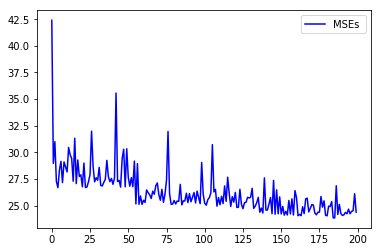

check point at 2019-04-25 15:35:09.354639
training : 善化
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 5s - loss: 0.0014 - 

Epoch : 39, MSE : [38.44569504119221]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0012
Epoch : 40, MSE : [42.20111291488443]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch : 41, MSE : [38.57028371989571]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0010
Epoch : 42, MSE : [37.54993082047725]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0010
Epoch : 43, MSE : [37.38373951124988]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0010
Epoch : 44, MSE : [37.51668874092899]
-------------------------------------------
Train on 2232

 - 1s - loss: 0.0011 - val_loss: 9.9429e-04
Epoch : 85, MSE : [36.367453167738]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0010
Epoch : 86, MSE : [37.33066659992476]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 9.8953e-04
Epoch : 87, MSE : [36.437023483461594]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 9.9241e-04
Epoch : 88, MSE : [36.39013318426878]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0010
Epoch : 89, MSE : [36.80544148077013]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 9.8142e-04
Epoch : 90, MSE : [36.04813481265684]
--

 - 2s - loss: 0.0011 - val_loss: 9.8991e-04
Epoch : 130, MSE : [36.09573029442431]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 9.9321e-04
Epoch : 131, MSE : [36.17069540576482]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0010
Epoch : 132, MSE : [36.546926890471845]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0011
Epoch : 133, MSE : [38.34666354991953]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 9.7783e-04
Epoch : 134, MSE : [35.733531615298375]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 1s - loss: 0.0011 - val_loss: 0.0010
Epoch : 135, MSE : [36.9204117656577

 - 2s - loss: 0.0010 - val_loss: 9.6235e-04
Epoch : 175, MSE : [34.77365333079165]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 2s - loss: 0.0010 - val_loss: 9.7781e-04
Epoch : 176, MSE : [35.47956329494837]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 0.0010
Epoch : 177, MSE : [36.91276770178471]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 2s - loss: 0.0010 - val_loss: 9.8101e-04
Epoch : 178, MSE : [35.354812625083554]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 2s - loss: 0.0010 - val_loss: 9.7695e-04
Epoch : 179, MSE : [35.17539510443328]
-------------------------------------------
Train on 22324 samples, validate on 5581 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 9.6816e-04
Epoch : 180, MSE : [35.039137

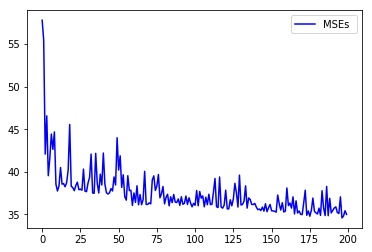

check point at 2019-04-25 15:43:50.925761
training : 嘉義
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 5s - loss: 0.0017 - 

Epoch : 39, MSE : [46.49413096058413]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0011
Epoch : 40, MSE : [45.26355777663453]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 1s - loss: 0.0012 - val_loss: 0.0011
Epoch : 41, MSE : [44.69051794303816]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 42, MSE : [45.349877603345725]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 43, MSE : [45.6836853870822]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 1s - loss: 0.0012 - val_loss: 0.0011
Epoch : 44, MSE : [45.04584355167488]
-------------------------------------------
Train on 2080

 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 85, MSE : [46.3839021122683]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0011
Epoch : 86, MSE : [44.67020067463768]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 1s - loss: 0.0011 - val_loss: 0.0012
Epoch : 87, MSE : [46.151300737985814]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0012
Epoch : 88, MSE : [49.13327039318008]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0012
Epoch : 89, MSE : [46.21797033503103]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 1s - loss: 0.0012 - val_loss: 0.0011
Epoch : 90, MSE : [44.399069009356566]
----------------

Epoch : 130, MSE : [46.59292691940946]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0011
Epoch : 131, MSE : [44.330961672852816]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch : 132, MSE : [44.16112230573054]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch : 133, MSE : [44.650464185592845]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0012
Epoch : 134, MSE : [46.662627327821504]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0011
Epoch : 135, MSE : [43.991695473494715]
-------------------------------------------
Tra

Epoch : 175, MSE : [43.69364808339994]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch : 176, MSE : [43.933471528802016]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch : 177, MSE : [44.0910741009343]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0011
Epoch : 178, MSE : [44.62250497726711]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch : 179, MSE : [44.083519612662016]
-------------------------------------------
Train on 20807 samples, validate on 5202 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0011
Epoch : 180, MSE : [46.01579898895239]
-------------------------------------------
Train 

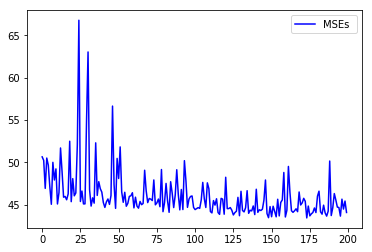

check point at 2019-04-25 15:52:10.873468
training : 安南
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 5s - loss: 0.0012 - 

 - 2s - loss: 9.4396e-04 - val_loss: 0.0011
Epoch : 38, MSE : [36.93793257875628]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 2s - loss: 9.5655e-04 - val_loss: 9.6799e-04
Epoch : 39, MSE : [32.513257836049206]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 2s - loss: 9.4645e-04 - val_loss: 0.0010
Epoch : 40, MSE : [33.6279367889455]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 2s - loss: 9.5614e-04 - val_loss: 0.0010
Epoch : 41, MSE : [34.87349776709]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 2s - loss: 9.3957e-04 - val_loss: 9.8875e-04
Epoch : 42, MSE : [33.03190494058077]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 2s - loss: 9.4563e-04 - val_loss: 0.0010
Epoch : 43, MSE : [35.4544

 - 2s - loss: 9.2909e-04 - val_loss: 9.7151e-04
Epoch : 82, MSE : [32.67536243698778]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 2s - loss: 9.3166e-04 - val_loss: 9.4986e-04
Epoch : 83, MSE : [31.799215734396263]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 1s - loss: 9.2827e-04 - val_loss: 9.4657e-04
Epoch : 84, MSE : [31.696216796906864]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 2s - loss: 9.3435e-04 - val_loss: 9.5606e-04
Epoch : 85, MSE : [32.08983052721516]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 2s - loss: 9.3490e-04 - val_loss: 9.4500e-04
Epoch : 86, MSE : [31.619029343966762]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 2s - loss: 9.4401e-04 - val_loss: 9.8945e-04
Epoc

Epoch : 125, MSE : [32.05610650234691]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 2s - loss: 9.2628e-04 - val_loss: 9.7144e-04
Epoch : 126, MSE : [32.680026046940164]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 2s - loss: 9.2077e-04 - val_loss: 9.5198e-04
Epoch : 127, MSE : [32.00489313846106]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 2s - loss: 9.2203e-04 - val_loss: 9.4337e-04
Epoch : 128, MSE : [31.715963780034414]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 2s - loss: 9.1972e-04 - val_loss: 9.7038e-04
Epoch : 129, MSE : [32.69218414905572]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 2s - loss: 9.2179e-04 - val_loss: 9.6719e-04
Epoch : 130, MSE : [32.72011766869184]
---------

 - 2s - loss: 9.1129e-04 - val_loss: 9.3891e-04
Epoch : 169, MSE : [31.384433855408044]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 2s - loss: 8.9981e-04 - val_loss: 9.9276e-04
Epoch : 170, MSE : [32.944856149573646]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 2s - loss: 9.0990e-04 - val_loss: 9.3726e-04
Epoch : 171, MSE : [31.46670429009478]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 2s - loss: 9.0970e-04 - val_loss: 9.8017e-04
Epoch : 172, MSE : [32.616018427409216]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 2s - loss: 9.0193e-04 - val_loss: 0.0011
Epoch : 173, MSE : [36.40049302812411]
-------------------------------------------
Train on 22669 samples, validate on 5668 samples
Epoch 1/1
 - 2s - loss: 9.0529e-04 - val_loss: 9.9219e-04
Epo

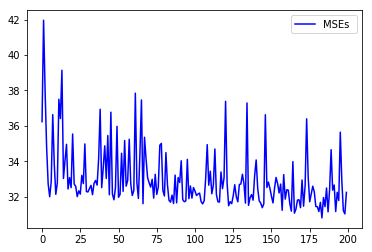

check point at 2019-04-25 16:01:20.801884
training : 崙背
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 5s - loss: 0.0011 - 

 - 1s - loss: 9.6814e-04 - val_loss: 0.0010
Epoch : 38, MSE : [41.44872174167244]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 9.6646e-04 - val_loss: 9.5943e-04
Epoch : 39, MSE : [39.287404211149486]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 9.5904e-04 - val_loss: 9.4463e-04
Epoch : 40, MSE : [38.84548312293784]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 9.5800e-04 - val_loss: 9.4519e-04
Epoch : 41, MSE : [38.967223575537005]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 9.6549e-04 - val_loss: 9.4500e-04
Epoch : 42, MSE : [38.98684369402284]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 9.4097e-04 - val_loss: 9.2340e-04
Epoch : 4

 - 2s - loss: 9.1608e-04 - val_loss: 9.2011e-04
Epoch : 82, MSE : [37.83150912437149]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 9.0871e-04 - val_loss: 9.0649e-04
Epoch : 83, MSE : [37.313755004953435]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 9.1045e-04 - val_loss: 0.0011
Epoch : 84, MSE : [46.07517986800353]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 1s - loss: 9.0544e-04 - val_loss: 8.9596e-04
Epoch : 85, MSE : [36.88286112536344]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 9.0499e-04 - val_loss: 9.0607e-04
Epoch : 86, MSE : [37.33772357746945]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 9.0882e-04 - val_loss: 9.6342e-04
Epoch : 87

Epoch : 125, MSE : [36.17629464098937]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 8.8968e-04 - val_loss: 9.6395e-04
Epoch : 126, MSE : [39.851147807282025]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 8.8935e-04 - val_loss: 8.9024e-04
Epoch : 127, MSE : [36.65459944552879]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 8.8872e-04 - val_loss: 8.7512e-04
Epoch : 128, MSE : [36.19277865656245]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 8.8721e-04 - val_loss: 8.9267e-04
Epoch : 129, MSE : [36.87648512498872]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 8.9091e-04 - val_loss: 9.6883e-04
Epoch : 130, MSE : [40.03921643255733]
----------

 - 2s - loss: 8.7151e-04 - val_loss: 8.6860e-04
Epoch : 169, MSE : [35.78946823367018]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 8.7061e-04 - val_loss: 8.6298e-04
Epoch : 170, MSE : [35.51792081555532]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 8.7075e-04 - val_loss: 8.6953e-04
Epoch : 171, MSE : [35.84177915210144]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 8.6503e-04 - val_loss: 8.9766e-04
Epoch : 172, MSE : [37.02611093962517]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 8.7506e-04 - val_loss: 8.5516e-04
Epoch : 173, MSE : [35.189847103961704]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 8.7217e-04 - val_loss: 8.7454e-04
E

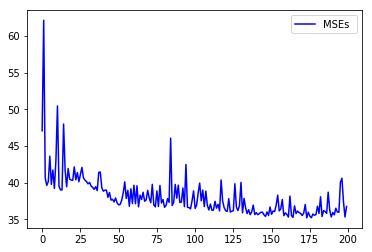

check point at 2019-04-25 16:10:32.667660
training : 斗六
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 6s - loss: 0.0013 - 

 - 2s - loss: 8.9551e-04 - val_loss: 8.5698e-04
Epoch : 38, MSE : [37.89822549641517]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 1s - loss: 9.0034e-04 - val_loss: 9.2869e-04
Epoch : 39, MSE : [40.48439309408998]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 2s - loss: 8.9778e-04 - val_loss: 8.7342e-04
Epoch : 40, MSE : [38.34495716080213]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 2s - loss: 8.9198e-04 - val_loss: 9.3417e-04
Epoch : 41, MSE : [40.56570491457416]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 2s - loss: 9.0174e-04 - val_loss: 8.6835e-04
Epoch : 42, MSE : [38.05871693511008]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 2s - loss: 8.9254e-04 - val_loss: 8.8557e-04
Epoch :

 - 2s - loss: 8.7614e-04 - val_loss: 8.5362e-04
Epoch : 82, MSE : [37.77905202471347]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 2s - loss: 8.7499e-04 - val_loss: 9.0936e-04
Epoch : 83, MSE : [40.5294843661711]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 2s - loss: 8.8048e-04 - val_loss: 9.0698e-04
Epoch : 84, MSE : [39.5433048160396]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 2s - loss: 8.8315e-04 - val_loss: 8.4972e-04
Epoch : 85, MSE : [37.3412898501496]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 1s - loss: 8.8069e-04 - val_loss: 8.4874e-04
Epoch : 86, MSE : [37.30452400425049]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 2s - loss: 8.8215e-04 - val_loss: 8.6950e-04
Epoch : 87

Epoch : 125, MSE : [37.34499823818889]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 2s - loss: 8.7444e-04 - val_loss: 8.4931e-04
Epoch : 126, MSE : [37.40451263993369]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 2s - loss: 8.7291e-04 - val_loss: 8.4388e-04
Epoch : 127, MSE : [37.31498312307845]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 2s - loss: 8.6691e-04 - val_loss: 8.9516e-04
Epoch : 128, MSE : [39.04725037429058]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 2s - loss: 8.7365e-04 - val_loss: 8.8729e-04
Epoch : 129, MSE : [39.30232894555713]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 2s - loss: 8.7821e-04 - val_loss: 8.4915e-04
Epoch : 130, MSE : [37.440729102851385]
----------

 - 2s - loss: 8.7296e-04 - val_loss: 8.9023e-04
Epoch : 169, MSE : [39.539876992953005]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 2s - loss: 8.6509e-04 - val_loss: 8.5713e-04
Epoch : 170, MSE : [37.49775206691339]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 2s - loss: 8.6186e-04 - val_loss: 8.5573e-04
Epoch : 171, MSE : [37.33762393236174]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 1s - loss: 8.6785e-04 - val_loss: 9.0812e-04
Epoch : 172, MSE : [39.485099149131266]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 2s - loss: 8.6741e-04 - val_loss: 8.5994e-04
Epoch : 173, MSE : [37.59235225832067]
-------------------------------------------
Train on 21959 samples, validate on 5490 samples
Epoch 1/1
 - 2s - loss: 8.6479e-04 - val_loss: 8.4375e-04


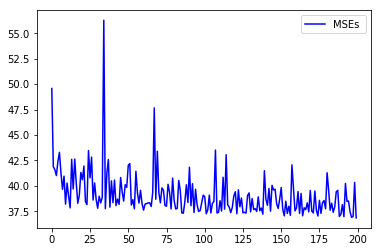

check point at 2019-04-25 16:19:39.268194
training : 新港
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 6s - loss: 0.0010 - 

 - 2s - loss: 6.3371e-04 - val_loss: 5.5746e-04
Epoch : 38, MSE : [33.76626815379773]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 2s - loss: 6.2672e-04 - val_loss: 5.2620e-04
Epoch : 39, MSE : [32.26018235737302]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 2s - loss: 6.3059e-04 - val_loss: 5.2961e-04
Epoch : 40, MSE : [32.363873911112876]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 2s - loss: 6.3213e-04 - val_loss: 5.8017e-04
Epoch : 41, MSE : [35.16034361098774]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 2s - loss: 6.3563e-04 - val_loss: 5.2501e-04
Epoch : 42, MSE : [32.33721712828915]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 2s - loss: 6.2605e-04 - val_loss: 5.9113e-04
Epoch 

 - 2s - loss: 6.1208e-04 - val_loss: 5.0581e-04
Epoch : 82, MSE : [31.12061175558575]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 2s - loss: 6.0771e-04 - val_loss: 5.3749e-04
Epoch : 83, MSE : [33.13983968778578]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 2s - loss: 6.0988e-04 - val_loss: 5.0588e-04
Epoch : 84, MSE : [31.114340565898225]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 2s - loss: 6.0815e-04 - val_loss: 5.3707e-04
Epoch : 85, MSE : [33.130274259256275]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 2s - loss: 6.0767e-04 - val_loss: 5.1115e-04
Epoch : 86, MSE : [31.29260505810495]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 2s - loss: 6.1030e-04 - val_loss: 5.1980e-04
Epoch

Epoch : 125, MSE : [30.94111624673026]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 2s - loss: 5.9845e-04 - val_loss: 5.1186e-04
Epoch : 126, MSE : [31.254399761045857]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 1s - loss: 5.9885e-04 - val_loss: 5.2666e-04
Epoch : 127, MSE : [31.958215558205254]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 1s - loss: 5.9488e-04 - val_loss: 5.0558e-04
Epoch : 128, MSE : [31.001097894732894]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 1s - loss: 5.9803e-04 - val_loss: 5.5001e-04
Epoch : 129, MSE : [33.80618513768432]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 2s - loss: 6.0456e-04 - val_loss: 5.0242e-04
Epoch : 130, MSE : [30.862096210714675]
-------

 - 2s - loss: 5.9632e-04 - val_loss: 5.0510e-04
Epoch : 169, MSE : [31.085932011771266]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 2s - loss: 5.9759e-04 - val_loss: 5.1049e-04
Epoch : 170, MSE : [31.166665005709685]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 2s - loss: 5.9731e-04 - val_loss: 5.8268e-04
Epoch : 171, MSE : [35.634121469663654]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 2s - loss: 5.9702e-04 - val_loss: 5.3003e-04
Epoch : 172, MSE : [32.55030670642267]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 2s - loss: 5.9807e-04 - val_loss: 5.7080e-04
Epoch : 173, MSE : [34.16602948945255]
-------------------------------------------
Train on 22688 samples, validate on 5673 samples
Epoch 1/1
 - 2s - loss: 5.9736e-04 - val_loss: 5.1395e-04

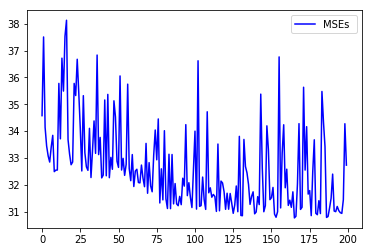

check point at 2019-04-25 16:29:13.241722
training : 新營
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 6s - loss: 0.0012 - 

 - 2s - loss: 8.5921e-04 - val_loss: 8.5314e-04
Epoch : 38, MSE : [32.537255873598234]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 2s - loss: 8.6073e-04 - val_loss: 7.8792e-04
Epoch : 39, MSE : [30.138808281009815]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 2s - loss: 8.6511e-04 - val_loss: 8.0899e-04
Epoch : 40, MSE : [31.10058938553225]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 2s - loss: 8.6195e-04 - val_loss: 7.9314e-04
Epoch : 41, MSE : [30.422817742305536]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 2s - loss: 8.5624e-04 - val_loss: 7.8836e-04
Epoch : 42, MSE : [30.304808108377312]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 2s - loss: 8.5912e-04 - val_loss: 8.1112e-04
Epo

 - 2s - loss: 8.4818e-04 - val_loss: 8.0602e-04
Epoch : 82, MSE : [30.7504711029047]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 2s - loss: 8.5487e-04 - val_loss: 8.1047e-04
Epoch : 83, MSE : [30.98700924238001]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 2s - loss: 8.4919e-04 - val_loss: 7.9637e-04
Epoch : 84, MSE : [30.26005857520149]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 2s - loss: 8.4636e-04 - val_loss: 8.2573e-04
Epoch : 85, MSE : [31.483839863831008]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 2s - loss: 8.4854e-04 - val_loss: 7.7540e-04
Epoch : 86, MSE : [29.74100613287236]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 2s - loss: 8.4738e-04 - val_loss: 7.8587e-04
Epoch :

Epoch : 125, MSE : [28.833374464799867]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 2s - loss: 8.1399e-04 - val_loss: 7.8069e-04
Epoch : 126, MSE : [29.437285241117674]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 2s - loss: 8.1620e-04 - val_loss: 7.9951e-04
Epoch : 127, MSE : [30.283051070539738]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 2s - loss: 8.1866e-04 - val_loss: 7.7812e-04
Epoch : 128, MSE : [29.64944100169962]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 2s - loss: 8.1688e-04 - val_loss: 8.0011e-04
Epoch : 129, MSE : [30.41421161069435]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 2s - loss: 8.1587e-04 - val_loss: 8.0799e-04
Epoch : 130, MSE : [30.425901986316774]
-------

 - 2s - loss: 8.0838e-04 - val_loss: 7.7447e-04
Epoch : 169, MSE : [29.269132264060268]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 2s - loss: 8.0331e-04 - val_loss: 7.8102e-04
Epoch : 170, MSE : [29.471142742185556]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 2s - loss: 8.1298e-04 - val_loss: 7.7989e-04
Epoch : 171, MSE : [29.389794724507915]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 2s - loss: 8.0694e-04 - val_loss: 7.6969e-04
Epoch : 172, MSE : [29.252482351198477]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 2s - loss: 8.0357e-04 - val_loss: 7.6140e-04
Epoch : 173, MSE : [28.632643551933416]
-------------------------------------------
Train on 22823 samples, validate on 5706 samples
Epoch 1/1
 - 2s - loss: 8.0598e-04 - val_loss: 7.6929e-

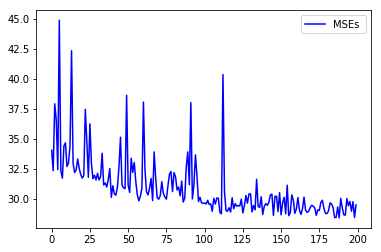

check point at 2019-04-25 16:39:23.900060
training : 朴子
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 6s - loss: 0.0015 - 

 - 2s - loss: 8.5848e-04 - val_loss: 9.0323e-04
Epoch : 38, MSE : [39.260265881115444]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 2s - loss: 8.6697e-04 - val_loss: 9.4950e-04
Epoch : 39, MSE : [40.9797695522438]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 2s - loss: 8.6609e-04 - val_loss: 9.7000e-04
Epoch : 40, MSE : [44.08190852304426]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 2s - loss: 8.6749e-04 - val_loss: 9.5203e-04
Epoch : 41, MSE : [41.44462919729366]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 2s - loss: 8.6336e-04 - val_loss: 9.2154e-04
Epoch : 42, MSE : [40.10051632204388]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 2s - loss: 8.6298e-04 - val_loss: 8.9207e-04
Epoch :

 - 2s - loss: 8.5115e-04 - val_loss: 9.1747e-04
Epoch : 82, MSE : [40.074087084787124]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 2s - loss: 8.5411e-04 - val_loss: 9.5665e-04
Epoch : 83, MSE : [41.69829688487768]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 2s - loss: 8.5414e-04 - val_loss: 8.8209e-04
Epoch : 84, MSE : [39.916507836153215]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 2s - loss: 8.6173e-04 - val_loss: 8.8243e-04
Epoch : 85, MSE : [39.066541194380065]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 2s - loss: 8.5675e-04 - val_loss: 9.8738e-04
Epoch : 86, MSE : [43.17853360000196]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 2s - loss: 8.5612e-04 - val_loss: 8.9405e-04
Epoc

Epoch : 125, MSE : [38.69374908925835]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 2s - loss: 8.5552e-04 - val_loss: 8.8356e-04
Epoch : 126, MSE : [39.10725945114811]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 2s - loss: 8.4954e-04 - val_loss: 8.6943e-04
Epoch : 127, MSE : [38.69180819950851]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 2s - loss: 8.5066e-04 - val_loss: 9.1896e-04
Epoch : 128, MSE : [40.29581091038612]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 2s - loss: 8.6030e-04 - val_loss: 8.9313e-04
Epoch : 129, MSE : [39.09873066583872]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 2s - loss: 8.4861e-04 - val_loss: 8.7927e-04
Epoch : 130, MSE : [39.403193064251106]
----------

 - 2s - loss: 8.4756e-04 - val_loss: 8.8187e-04
Epoch : 169, MSE : [38.74709519242507]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 2s - loss: 8.4288e-04 - val_loss: 9.1958e-04
Epoch : 170, MSE : [41.52290060115819]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 2s - loss: 8.4364e-04 - val_loss: 8.6063e-04
Epoch : 171, MSE : [38.156280249999064]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 2s - loss: 8.4180e-04 - val_loss: 8.6068e-04
Epoch : 172, MSE : [38.113187039416516]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 2s - loss: 8.4230e-04 - val_loss: 8.6247e-04
Epoch : 173, MSE : [38.88727573005725]
-------------------------------------------
Train on 22650 samples, validate on 5663 samples
Epoch 1/1
 - 2s - loss: 8.4755e-04 - val_loss: 8.8090e-04


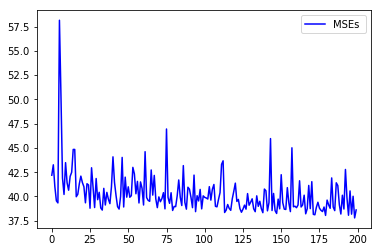

check point at 2019-04-25 16:49:18.653312
training : 麥寮
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 6s - loss: 0.0012 - 

 - 2s - loss: 8.1623e-04 - val_loss: 7.8695e-04
Epoch : 38, MSE : [24.915211605274017]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 2s - loss: 8.1039e-04 - val_loss: 7.8618e-04
Epoch : 39, MSE : [24.956865892406572]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 2s - loss: 8.1510e-04 - val_loss: 7.9832e-04
Epoch : 40, MSE : [25.164884015564795]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 2s - loss: 8.1845e-04 - val_loss: 7.9035e-04
Epoch : 41, MSE : [25.17150178530258]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 2s - loss: 8.1738e-04 - val_loss: 8.1565e-04
Epoch : 42, MSE : [25.67627046286834]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 2s - loss: 8.0165e-04 - val_loss: 7.9792e-04
Epoc

Epoch : 81, MSE : [26.16762709050222]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 2s - loss: 7.6806e-04 - val_loss: 8.1754e-04
Epoch : 82, MSE : [25.743504818508075]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 2s - loss: 7.8510e-04 - val_loss: 7.5323e-04
Epoch : 83, MSE : [23.779072496466505]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 2s - loss: 7.7494e-04 - val_loss: 7.6837e-04
Epoch : 84, MSE : [24.099143479751575]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 2s - loss: 7.7083e-04 - val_loss: 8.3590e-04
Epoch : 85, MSE : [26.015564605184302]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 2s - loss: 7.7412e-04 - val_loss: 7.6475e-04
Epoch : 86, MSE : [24.143976818615403]
------------

 - 2s - loss: 7.5198e-04 - val_loss: 7.3874e-04
Epoch : 125, MSE : [23.194683907731292]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 2s - loss: 7.4780e-04 - val_loss: 7.3714e-04
Epoch : 126, MSE : [23.255126161850512]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 2s - loss: 7.5090e-04 - val_loss: 7.3424e-04
Epoch : 127, MSE : [22.976658902922004]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 2s - loss: 7.4643e-04 - val_loss: 7.3485e-04
Epoch : 128, MSE : [23.067429918678545]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 2s - loss: 7.4183e-04 - val_loss: 7.5968e-04
Epoch : 129, MSE : [23.844999048227336]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 2s - loss: 7.5819e-04 - val_loss: 8.1647e-

 - 2s - loss: 7.3486e-04 - val_loss: 7.3202e-04
Epoch : 168, MSE : [22.85106349877949]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 2s - loss: 7.3955e-04 - val_loss: 7.3025e-04
Epoch : 169, MSE : [22.89748453122915]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 2s - loss: 7.4299e-04 - val_loss: 7.4456e-04
Epoch : 170, MSE : [23.24964204413245]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 2s - loss: 7.3331e-04 - val_loss: 7.3538e-04
Epoch : 171, MSE : [23.118652142845797]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 2s - loss: 7.3926e-04 - val_loss: 7.4380e-04
Epoch : 172, MSE : [23.280040486061502]
-------------------------------------------
Train on 22285 samples, validate on 5572 samples
Epoch 1/1
 - 2s - loss: 7.3713e-04 - val_loss: 7.2319e-04


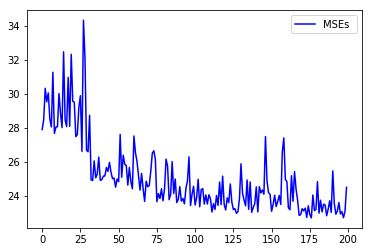

check point at 2019-04-25 16:59:07.547623
training : 仁武
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 6s - loss: 0.0023 - 

Epoch : 39, MSE : [41.45652003612061]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 2s - loss: 0.0016 - val_loss: 0.0017
Epoch : 40, MSE : [44.35314640017043]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 2s - loss: 0.0016 - val_loss: 0.0015
Epoch : 41, MSE : [39.49352762126979]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0015
Epoch : 42, MSE : [40.64151018421345]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 2s - loss: 0.0016 - val_loss: 0.0016
Epoch : 43, MSE : [41.366263398949634]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0015
Epoch : 44, MSE : [40.26691485601975]
-------------------------------------------
Train on 218

 - 2s - loss: 0.0015 - val_loss: 0.0015
Epoch : 85, MSE : [39.276559442183185]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0015
Epoch : 86, MSE : [41.613948129080384]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0016
Epoch : 87, MSE : [41.77454071733003]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0015
Epoch : 88, MSE : [40.42056968173103]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0015
Epoch : 89, MSE : [40.666407640903195]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0015
Epoch : 90, MSE : [40.1917008771113]
---------------

Epoch : 130, MSE : [42.32457445535706]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0016
Epoch : 131, MSE : [42.54150699198026]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0015
Epoch : 132, MSE : [39.0547743724575]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0014
Epoch : 133, MSE : [38.419996671756806]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0017
Epoch : 134, MSE : [44.32669497405456]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0016
Epoch : 135, MSE : [42.365466982392626]
-------------------------------------------
Train 

Epoch : 175, MSE : [38.292338696535715]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0014
Epoch : 176, MSE : [38.48666254053741]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0015
Epoch : 177, MSE : [38.65040735374777]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0014
Epoch : 178, MSE : [38.270041769895144]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0014
Epoch : 179, MSE : [38.27008256784349]
-------------------------------------------
Train on 21844 samples, validate on 5461 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0015
Epoch : 180, MSE : [38.65575592409193]
-------------------------------------------
Train

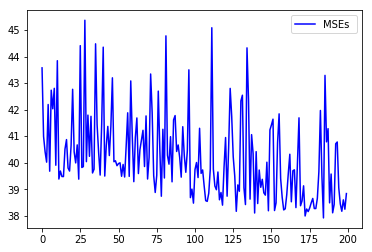

check point at 2019-04-25 17:08:52.379728
training : 前金
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 6s - loss: 0.0014 - 

Epoch : 39, MSE : [42.245772575157154]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 2s - loss: 0.0010 - val_loss: 0.0011
Epoch : 40, MSE : [41.74910042002111]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 2s - loss: 0.0010 - val_loss: 0.0012
Epoch : 41, MSE : [45.82725232524101]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 2s - loss: 0.0010 - val_loss: 0.0010
Epoch : 42, MSE : [40.9253194546815]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 2s - loss: 0.0010 - val_loss: 9.9391e-04
Epoch : 43, MSE : [39.2591890393592]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 2s - loss: 0.0010 - val_loss: 0.0010
Epoch : 44, MSE : [39.51317142832965]
-------------------------------------------
Train on 2

Epoch : 84, MSE : [39.01736738888978]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 2s - loss: 0.0010 - val_loss: 9.9682e-04
Epoch : 85, MSE : [38.90437872382103]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 2s - loss: 0.0010 - val_loss: 9.8416e-04
Epoch : 86, MSE : [38.49989143310832]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 2s - loss: 0.0010 - val_loss: 0.0011
Epoch : 87, MSE : [42.87108823358459]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 1s - loss: 0.0010 - val_loss: 0.0010
Epoch : 88, MSE : [39.04148716764227]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 2s - loss: 0.0010 - val_loss: 9.7788e-04
Epoch : 89, MSE : [38.29184016972398]
-------------------------------------------
T

 - 2s - loss: 0.0010 - val_loss: 0.0010
Epoch : 129, MSE : [39.983380290081165]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 2s - loss: 9.9990e-04 - val_loss: 0.0010
Epoch : 130, MSE : [39.86149365258881]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 2s - loss: 0.0010 - val_loss: 9.8813e-04
Epoch : 131, MSE : [38.40471514062704]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 2s - loss: 9.9801e-04 - val_loss: 9.9573e-04
Epoch : 132, MSE : [38.62227762192906]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 2s - loss: 9.9839e-04 - val_loss: 9.7351e-04
Epoch : 133, MSE : [37.90141947231324]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 2s - loss: 9.9728e-04 - val_loss: 9.6780e-04
Epoch : 134, MSE 

 - 2s - loss: 9.9664e-04 - val_loss: 9.7404e-04
Epoch : 173, MSE : [37.79068833277778]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 2s - loss: 9.8605e-04 - val_loss: 9.8903e-04
Epoch : 174, MSE : [38.44277686372744]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 2s - loss: 9.8221e-04 - val_loss: 9.7879e-04
Epoch : 175, MSE : [37.90188159386385]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 1s - loss: 9.8486e-04 - val_loss: 0.0010
Epoch : 176, MSE : [39.57132366154465]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 2s - loss: 9.8232e-04 - val_loss: 9.6062e-04
Epoch : 177, MSE : [37.40383421630623]
-------------------------------------------
Train on 20557 samples, validate on 5140 samples
Epoch 1/1
 - 2s - loss: 9.8880e-04 - val_loss: 0.0010
Epoch : 17

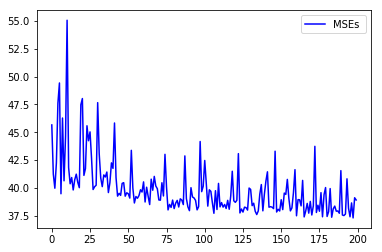

check point at 2019-04-25 17:18:16.541476
training : 前鎮
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 6s - loss: 0.0017 - 

Epoch : 39, MSE : [47.29248292800097]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0012
Epoch : 40, MSE : [45.958248406564174]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0012
Epoch : 41, MSE : [46.29186196973072]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0012
Epoch : 42, MSE : [43.45342832102662]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0011
Epoch : 43, MSE : [42.1758856996517]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0011
Epoch : 44, MSE : [41.969051690792696]
-------------------------------------------
Train on 217

 - 2s - loss: 0.0010 - val_loss: 0.0011
Epoch : 85, MSE : [39.236597943516834]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 2s - loss: 0.0010 - val_loss: 0.0011
Epoch : 86, MSE : [40.34624322584488]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 2s - loss: 0.0010 - val_loss: 0.0011
Epoch : 87, MSE : [40.53979554821079]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 2s - loss: 0.0010 - val_loss: 0.0012
Epoch : 88, MSE : [42.17305422052908]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 2s - loss: 0.0010 - val_loss: 0.0011
Epoch : 89, MSE : [39.774573149224985]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 2s - loss: 0.0010 - val_loss: 0.0011
Epoch : 90, MSE : [42.27924179841614]
---------------

 - 2s - loss: 9.8113e-04 - val_loss: 0.0011
Epoch : 130, MSE : [38.76218098802312]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 2s - loss: 9.7972e-04 - val_loss: 0.0011
Epoch : 131, MSE : [38.88730906403513]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 2s - loss: 9.7915e-04 - val_loss: 0.0012
Epoch : 132, MSE : [42.06533747680619]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 2s - loss: 9.7937e-04 - val_loss: 0.0011
Epoch : 133, MSE : [38.63342321429737]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 2s - loss: 9.7937e-04 - val_loss: 0.0011
Epoch : 134, MSE : [39.49853611171853]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 2s - loss: 9.7642e-04 - val_loss: 0.0011
Epoch : 135, MSE : [39.166

Epoch : 174, MSE : [40.734776931457674]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 2s - loss: 9.7392e-04 - val_loss: 0.0011
Epoch : 175, MSE : [40.01399170233523]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 2s - loss: 9.7434e-04 - val_loss: 0.0011
Epoch : 176, MSE : [38.96043290252506]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 2s - loss: 9.6846e-04 - val_loss: 0.0011
Epoch : 177, MSE : [38.46382207409173]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 2s - loss: 9.6608e-04 - val_loss: 0.0011
Epoch : 178, MSE : [38.35717563952081]
-------------------------------------------
Train on 21748 samples, validate on 5437 samples
Epoch 1/1
 - 2s - loss: 9.7351e-04 - val_loss: 0.0011
Epoch : 179, MSE : [38.333284770963935]
-----------------------------

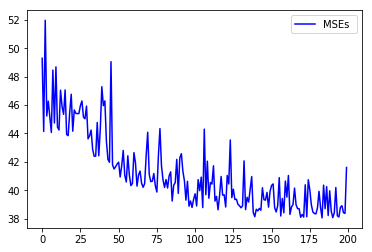

check point at 2019-04-25 17:28:26.262382
training : 大寮
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 6s - loss: 0.0025 - 

Epoch : 39, MSE : [50.84000715000881]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 2s - loss: 0.0018 - val_loss: 0.0018
Epoch : 40, MSE : [51.16734714308789]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 1s - loss: 0.0018 - val_loss: 0.0018
Epoch : 41, MSE : [53.04443592111704]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 2s - loss: 0.0018 - val_loss: 0.0017
Epoch : 42, MSE : [50.663428923073]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 2s - loss: 0.0018 - val_loss: 0.0017
Epoch : 43, MSE : [50.691547669091115]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 1s - loss: 0.0018 - val_loss: 0.0018
Epoch : 44, MSE : [51.291731108380716]
-------------------------------------------
Train on 1919

 - 1s - loss: 0.0017 - val_loss: 0.0017
Epoch : 85, MSE : [50.0099169476818]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 2s - loss: 0.0017 - val_loss: 0.0017
Epoch : 86, MSE : [49.637929060624565]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 2s - loss: 0.0017 - val_loss: 0.0016
Epoch : 87, MSE : [48.42182185979513]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 1s - loss: 0.0017 - val_loss: 0.0017
Epoch : 88, MSE : [49.01402096114362]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 2s - loss: 0.0017 - val_loss: 0.0016
Epoch : 89, MSE : [48.14173446409708]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 2s - loss: 0.0017 - val_loss: 0.0017
Epoch : 90, MSE : [48.57693830486269]
-----------------

Epoch : 130, MSE : [47.75929588746214]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 2s - loss: 0.0017 - val_loss: 0.0016
Epoch : 131, MSE : [47.84847838516576]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 1s - loss: 0.0016 - val_loss: 0.0016
Epoch : 132, MSE : [48.122872859773864]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 2s - loss: 0.0017 - val_loss: 0.0018
Epoch : 133, MSE : [53.84019275135855]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 2s - loss: 0.0017 - val_loss: 0.0016
Epoch : 134, MSE : [47.53422163154291]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 2s - loss: 0.0017 - val_loss: 0.0016
Epoch : 135, MSE : [46.99566431986874]
-------------------------------------------
Train 

Epoch : 175, MSE : [46.9621389074796]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 2s - loss: 0.0016 - val_loss: 0.0017
Epoch : 176, MSE : [50.342381492585574]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 2s - loss: 0.0017 - val_loss: 0.0016
Epoch : 177, MSE : [46.95213269134164]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 2s - loss: 0.0016 - val_loss: 0.0017
Epoch : 178, MSE : [48.262801997671325]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 2s - loss: 0.0017 - val_loss: 0.0016
Epoch : 179, MSE : [46.99799331290152]
-------------------------------------------
Train on 19194 samples, validate on 4799 samples
Epoch 1/1
 - 2s - loss: 0.0016 - val_loss: 0.0017
Epoch : 180, MSE : [48.73741785207182]
-------------------------------------------
Train 

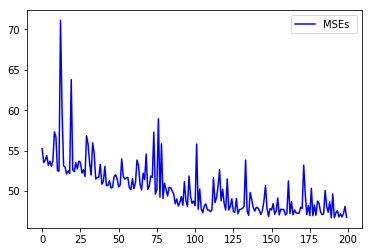

check point at 2019-04-25 17:37:31.034927
training : 小港
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 6s - loss: 0.0020 - 

Epoch : 39, MSE : [51.40727833368621]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 1s - loss: 0.0017 - val_loss: 0.0020
Epoch : 40, MSE : [60.903876052747826]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 2s - loss: 0.0017 - val_loss: 0.0017
Epoch : 41, MSE : [51.15845787678386]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 2s - loss: 0.0017 - val_loss: 0.0017
Epoch : 42, MSE : [51.612738246990794]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 1s - loss: 0.0017 - val_loss: 0.0017
Epoch : 43, MSE : [50.09460660121611]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 2s - loss: 0.0017 - val_loss: 0.0018
Epoch : 44, MSE : [53.70754286086627]
-------------------------------------------
Train on 18

 - 2s - loss: 0.0016 - val_loss: 0.0017
Epoch : 85, MSE : [52.30911626465902]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 2s - loss: 0.0016 - val_loss: 0.0017
Epoch : 86, MSE : [50.87833432723934]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 2s - loss: 0.0016 - val_loss: 0.0017
Epoch : 87, MSE : [49.96861260475989]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 2s - loss: 0.0016 - val_loss: 0.0017
Epoch : 88, MSE : [52.897519560330046]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 2s - loss: 0.0016 - val_loss: 0.0017
Epoch : 89, MSE : [50.39430115420155]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 2s - loss: 0.0016 - val_loss: 0.0017
Epoch : 90, MSE : [49.25148215199927]
----------------

Epoch : 130, MSE : [49.0583912071259]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 2s - loss: 0.0016 - val_loss: 0.0016
Epoch : 131, MSE : [49.43917178351815]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 1s - loss: 0.0016 - val_loss: 0.0017
Epoch : 132, MSE : [49.531279480331946]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 2s - loss: 0.0016 - val_loss: 0.0017
Epoch : 133, MSE : [50.1785778350147]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 2s - loss: 0.0016 - val_loss: 0.0017
Epoch : 134, MSE : [49.52295860952503]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 1s - loss: 0.0016 - val_loss: 0.0017
Epoch : 135, MSE : [49.25799922692058]
-------------------------------------------
Train on

Epoch : 175, MSE : [55.107858722280106]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 1s - loss: 0.0016 - val_loss: 0.0016
Epoch : 176, MSE : [48.33333001697743]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 2s - loss: 0.0016 - val_loss: 0.0017
Epoch : 177, MSE : [49.83132601109075]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 2s - loss: 0.0016 - val_loss: 0.0017
Epoch : 178, MSE : [49.85149638246654]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 1s - loss: 0.0016 - val_loss: 0.0016
Epoch : 179, MSE : [48.51348109473642]
-------------------------------------------
Train on 18733 samples, validate on 4684 samples
Epoch 1/1
 - 2s - loss: 0.0016 - val_loss: 0.0017
Epoch : 180, MSE : [49.67201303037384]
-------------------------------------------
Train 

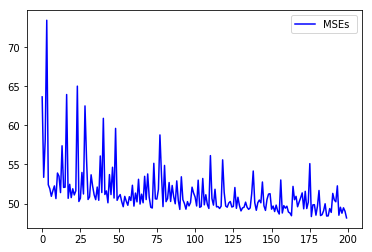

check point at 2019-04-25 17:46:21.714754
training : 屏東
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 6s - loss: 0.0024 - 

Epoch : 39, MSE : [41.65751100983426]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0011
Epoch : 40, MSE : [41.33100098295075]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0011
Epoch : 41, MSE : [41.554302666018785]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0011
Epoch : 42, MSE : [41.83292199221485]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 43, MSE : [43.38823471933849]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0011
Epoch : 44, MSE : [41.787668036806544]
-------------------------------------------
Train on 20

 - 2s - loss: 0.0011 - val_loss: 0.0011
Epoch : 85, MSE : [41.33892601206405]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0012
Epoch : 86, MSE : [43.150449307883584]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 87, MSE : [43.241419965616444]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0012
Epoch : 88, MSE : [42.28364963457735]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0012
Epoch : 89, MSE : [42.91811396262177]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0011
Epoch : 90, MSE : [42.02363803834117]
---------------

Epoch : 130, MSE : [42.69032437698803]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0012
Epoch : 131, MSE : [42.23831552130744]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0012
Epoch : 132, MSE : [43.39474875071672]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0012
Epoch : 133, MSE : [44.07341741209797]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0012
Epoch : 134, MSE : [42.52752091599258]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0011
Epoch : 135, MSE : [41.218260062273146]
-------------------------------------------
Train 

Epoch : 175, MSE : [41.04126648028188]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0011
Epoch : 176, MSE : [41.1291342327254]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0012
Epoch : 177, MSE : [43.177897114608285]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0011
Epoch : 178, MSE : [41.3836396851101]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0012
Epoch : 179, MSE : [44.31348649304546]
-------------------------------------------
Train on 20231 samples, validate on 5058 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0012
Epoch : 180, MSE : [43.94475278612271]
-------------------------------------------
Train on

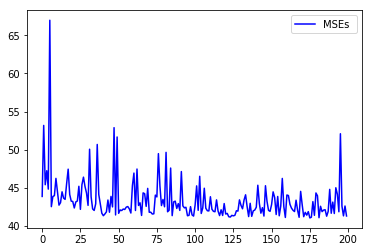

check point at 2019-04-25 17:56:00.816466
training : 左營
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 6s - loss: 0.0020 - 

Epoch : 39, MSE : [40.30352068248241]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0016
Epoch : 40, MSE : [45.813844426359005]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 2s - loss: 0.0014 - val_loss: 0.0014
Epoch : 41, MSE : [41.82763365415754]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 2s - loss: 0.0014 - val_loss: 0.0015
Epoch : 42, MSE : [42.63957018511088]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 2s - loss: 0.0014 - val_loss: 0.0014
Epoch : 43, MSE : [39.548390319225476]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 2s - loss: 0.0014 - val_loss: 0.0014
Epoch : 44, MSE : [40.19157560472933]
-------------------------------------------
Train on 20

 - 2s - loss: 0.0014 - val_loss: 0.0013
Epoch : 85, MSE : [38.8489134086235]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 2s - loss: 0.0014 - val_loss: 0.0013
Epoch : 86, MSE : [38.958110202934506]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 2s - loss: 0.0014 - val_loss: 0.0013
Epoch : 87, MSE : [39.28069551206071]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 2s - loss: 0.0014 - val_loss: 0.0013
Epoch : 88, MSE : [39.11665964406891]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 2s - loss: 0.0014 - val_loss: 0.0014
Epoch : 89, MSE : [41.365792486243905]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 2s - loss: 0.0014 - val_loss: 0.0013
Epoch : 90, MSE : [38.840926123834954]
---------------

Epoch : 130, MSE : [38.67475902813863]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 2s - loss: 0.0014 - val_loss: 0.0016
Epoch : 131, MSE : [46.294397196033096]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 2s - loss: 0.0014 - val_loss: 0.0013
Epoch : 132, MSE : [38.43578685269157]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 2s - loss: 0.0014 - val_loss: 0.0014
Epoch : 133, MSE : [39.26104111668051]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 2s - loss: 0.0014 - val_loss: 0.0013
Epoch : 134, MSE : [39.13490957587627]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 2s - loss: 0.0014 - val_loss: 0.0013
Epoch : 135, MSE : [38.09319928667913]
-------------------------------------------
Train 

Epoch : 175, MSE : [39.00582681072716]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch : 176, MSE : [38.5354595909577]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch : 177, MSE : [38.09437787972063]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 2s - loss: 0.0014 - val_loss: 0.0013
Epoch : 178, MSE : [38.53515773440745]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 2s - loss: 0.0014 - val_loss: 0.0013
Epoch : 179, MSE : [39.38394126191867]
-------------------------------------------
Train on 20922 samples, validate on 5231 samples
Epoch 1/1
 - 1s - loss: 0.0014 - val_loss: 0.0014
Epoch : 180, MSE : [41.29362598626213]
-------------------------------------------
Train on

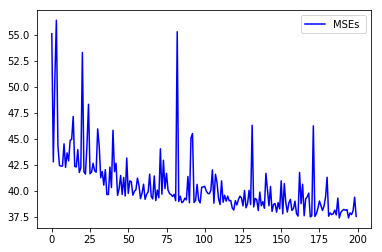

check point at 2019-04-25 18:06:04.912786
training : 復興
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 6s - loss: 0.0019 - 

Epoch : 39, MSE : [27.891138048926905]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0011
Epoch : 40, MSE : [27.0985634861654]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0011
Epoch : 41, MSE : [28.325240726929767]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0011
Epoch : 42, MSE : [26.551474376863126]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0011
Epoch : 43, MSE : [26.554243661157372]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0011
Epoch : 44, MSE : [26.31577088791943]
-------------------------------------------
Train on 2

 - 2s - loss: 0.0011 - val_loss: 0.0010
Epoch : 85, MSE : [25.29572147540038]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0010
Epoch : 86, MSE : [25.640821271762867]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0010
Epoch : 87, MSE : [26.03205133723223]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0010
Epoch : 88, MSE : [26.007744995823625]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0010
Epoch : 89, MSE : [25.80007976192142]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0011
Epoch : 90, MSE : [27.609108976753152]
--------------

 - 2s - loss: 0.0011 - val_loss: 0.0010
Epoch : 130, MSE : [25.15110254617494]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 2s - loss: 0.0010 - val_loss: 0.0010
Epoch : 131, MSE : [25.67944609846884]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0010
Epoch : 132, MSE : [25.137709745635664]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 2s - loss: 0.0010 - val_loss: 0.0011
Epoch : 133, MSE : [28.331785206824385]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 2s - loss: 0.0010 - val_loss: 0.0012
Epoch : 134, MSE : [29.023543324336572]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 2s - loss: 0.0011 - val_loss: 0.0011
Epoch : 135, MSE : [27.213125551771387]
-------

 - 2s - loss: 0.0010 - val_loss: 0.0010
Epoch : 175, MSE : [25.45418824181318]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 2s - loss: 0.0010 - val_loss: 0.0010
Epoch : 176, MSE : [25.052529530811544]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 2s - loss: 0.0010 - val_loss: 0.0010
Epoch : 177, MSE : [25.9936576442363]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 2s - loss: 0.0010 - val_loss: 0.0010
Epoch : 178, MSE : [24.843712532971463]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 2s - loss: 0.0010 - val_loss: 0.0010
Epoch : 179, MSE : [25.66644455643968]
-------------------------------------------
Train on 22151 samples, validate on 5538 samples
Epoch 1/1
 - 2s - loss: 0.0010 - val_loss: 0.0011
Epoch : 180, MSE : [27.176551013245838]
---------

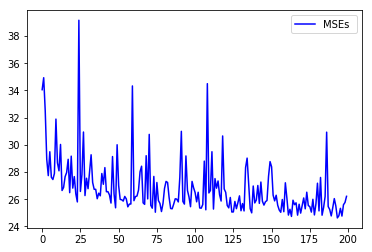

check point at 2019-04-25 18:17:11.707630
training : 恆春
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 6s - loss: 0.0018 - 

Epoch : 39, MSE : [13.551360495396358]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0015
Epoch : 40, MSE : [12.784682991974515]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0015
Epoch : 41, MSE : [12.791794804635854]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 2s - loss: 0.0014 - val_loss: 0.0015
Epoch : 42, MSE : [12.634113791762221]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0014
Epoch : 43, MSE : [12.629898136887324]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0016
Epoch : 44, MSE : [13.512520921385068]
-------------------------------------------
Train o

 - 2s - loss: 0.0014 - val_loss: 0.0015
Epoch : 85, MSE : [13.098872468482833]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 2s - loss: 0.0014 - val_loss: 0.0014
Epoch : 86, MSE : [12.513257061164648]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 2s - loss: 0.0014 - val_loss: 0.0015
Epoch : 87, MSE : [12.628619696449496]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 2s - loss: 0.0014 - val_loss: 0.0014
Epoch : 88, MSE : [12.49851406825918]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 2s - loss: 0.0014 - val_loss: 0.0015
Epoch : 89, MSE : [12.872714192376609]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 2s - loss: 0.0014 - val_loss: 0.0015
Epoch : 90, MSE : [12.720572917518853]
------------

 - 2s - loss: 0.0014 - val_loss: 0.0015
Epoch : 130, MSE : [12.424133473148244]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 2s - loss: 0.0014 - val_loss: 0.0014
Epoch : 131, MSE : [12.470248474281727]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 2s - loss: 0.0014 - val_loss: 0.0015
Epoch : 132, MSE : [12.959694988618923]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 2s - loss: 0.0014 - val_loss: 0.0014
Epoch : 133, MSE : [12.42511915533388]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 2s - loss: 0.0014 - val_loss: 0.0015
Epoch : 134, MSE : [12.83291770834917]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 2s - loss: 0.0014 - val_loss: 0.0015
Epoch : 135, MSE : [12.772447470545606]
-------

 - 2s - loss: 0.0014 - val_loss: 0.0015
Epoch : 175, MSE : [12.633332471969723]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 2s - loss: 0.0014 - val_loss: 0.0015
Epoch : 176, MSE : [12.416987926457457]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 2s - loss: 0.0014 - val_loss: 0.0016
Epoch : 177, MSE : [13.877134010136508]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 2s - loss: 0.0014 - val_loss: 0.0015
Epoch : 178, MSE : [12.742125152126475]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 2s - loss: 0.0014 - val_loss: 0.0015
Epoch : 179, MSE : [12.571793257662733]
-------------------------------------------
Train on 21172 samples, validate on 5293 samples
Epoch 1/1
 - 2s - loss: 0.0014 - val_loss: 0.0015
Epoch : 180, MSE : [12.700914485591266]
-----

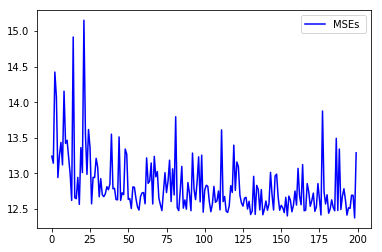

check point at 2019-04-25 18:27:51.035739
training : 林園
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 6s - loss: 0.0030 - 

Epoch : 39, MSE : [91.93188451581956]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 2s - loss: 0.0024 - val_loss: 0.0022
Epoch : 40, MSE : [91.55672114416342]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 2s - loss: 0.0024 - val_loss: 0.0023
Epoch : 41, MSE : [93.59163459903228]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 2s - loss: 0.0024 - val_loss: 0.0023
Epoch : 42, MSE : [93.10819352268774]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 2s - loss: 0.0024 - val_loss: 0.0022
Epoch : 43, MSE : [92.57073646874107]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 2s - loss: 0.0024 - val_loss: 0.0022
Epoch : 44, MSE : [92.39017167002942]
-------------------------------------------
Train on 1948

 - 2s - loss: 0.0024 - val_loss: 0.0023
Epoch : 85, MSE : [92.65293793941532]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 2s - loss: 0.0024 - val_loss: 0.0022
Epoch : 86, MSE : [91.66081933460575]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 2s - loss: 0.0024 - val_loss: 0.0023
Epoch : 87, MSE : [93.95800528447934]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 2s - loss: 0.0024 - val_loss: 0.0022
Epoch : 88, MSE : [92.13015435503723]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 2s - loss: 0.0024 - val_loss: 0.0022
Epoch : 89, MSE : [91.5147289073153]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 2s - loss: 0.0024 - val_loss: 0.0023
Epoch : 90, MSE : [92.87194402441848]
------------------

Epoch : 130, MSE : [92.65770106509945]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 2s - loss: 0.0024 - val_loss: 0.0023
Epoch : 131, MSE : [94.82881342438147]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 2s - loss: 0.0024 - val_loss: 0.0022
Epoch : 132, MSE : [91.61281455518586]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 2s - loss: 0.0024 - val_loss: 0.0023
Epoch : 133, MSE : [91.98873608876656]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 2s - loss: 0.0024 - val_loss: 0.0022
Epoch : 134, MSE : [91.40647798264146]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 2s - loss: 0.0024 - val_loss: 0.0023
Epoch : 135, MSE : [92.71818150214189]
-------------------------------------------
Train o

 - 2s - loss: 0.0023 - val_loss: 0.0022
Epoch : 176, MSE : [90.71574961902444]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 2s - loss: 0.0023 - val_loss: 0.0022
Epoch : 177, MSE : [91.62898662482016]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 2s - loss: 0.0023 - val_loss: 0.0023
Epoch : 178, MSE : [92.12924075580186]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 2s - loss: 0.0023 - val_loss: 0.0023
Epoch : 179, MSE : [92.34205190434132]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 2s - loss: 0.0023 - val_loss: 0.0022
Epoch : 180, MSE : [91.34569528474802]
-------------------------------------------
Train on 19482 samples, validate on 4871 samples
Epoch 1/1
 - 2s - loss: 0.0024 - val_loss: 0.0022
Epoch : 181, MSE : [91.24314464223757]
-----------

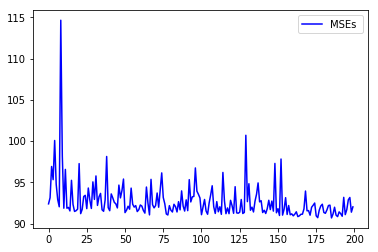

check point at 2019-04-25 18:37:35.383506
training : 楠梓
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 6s - loss: 0.0017 - 

Epoch : 39, MSE : [41.42224056958474]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 0.0013 - val_loss: 0.0012
Epoch : 40, MSE : [38.62379361638698]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 0.0013 - val_loss: 0.0012
Epoch : 41, MSE : [38.527495052513096]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 0.0013 - val_loss: 0.0012
Epoch : 42, MSE : [38.405749403359096]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 0.0013 - val_loss: 0.0013
Epoch : 43, MSE : [41.730630973787655]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 44, MSE : [38.03412804838567]
-------------------------------------------
Train on 2

 - 2s - loss: 0.0012 - val_loss: 0.0011
Epoch : 85, MSE : [36.45906559231298]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0011
Epoch : 86, MSE : [36.18695916386805]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 87, MSE : [36.41479271190214]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 88, MSE : [37.044705581155135]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 89, MSE : [36.57468473727418]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 90, MSE : [38.6320406103552]
-----------------

Epoch : 130, MSE : [37.543336297431885]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 131, MSE : [36.2672359314209]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0011
Epoch : 132, MSE : [35.63936778400665]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 133, MSE : [36.65841200031825]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 134, MSE : [37.38133656803681]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0011
Epoch : 135, MSE : [35.78416582602033]
-------------------------------------------
Train o

Epoch : 175, MSE : [37.24007627720836]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0011
Epoch : 176, MSE : [35.71875908266039]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 177, MSE : [36.68024390246151]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0011
Epoch : 178, MSE : [35.906339999911026]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 179, MSE : [36.821079112477996]
-------------------------------------------
Train on 22266 samples, validate on 5567 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 180, MSE : [38.011019249404036]
-------------------------------------------
Trai

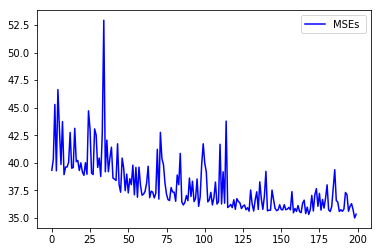

check point at 2019-04-25 18:48:50.056608
training : 橋頭
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 6s - loss: 0.0022 - 

Epoch : 39, MSE : [35.60454015493602]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 2s - loss: 0.0013 - val_loss: 0.0012
Epoch : 40, MSE : [33.79701948052518]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 2s - loss: 0.0013 - val_loss: 0.0013
Epoch : 41, MSE : [36.26506753522991]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 2s - loss: 0.0013 - val_loss: 0.0012
Epoch : 42, MSE : [33.55844743634764]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 2s - loss: 0.0013 - val_loss: 0.0012
Epoch : 43, MSE : [34.32488071882364]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 2s - loss: 0.0013 - val_loss: 0.0011
Epoch : 44, MSE : [32.68302249437428]
-------------------------------------------
Train on 2167

 - 2s - loss: 0.0013 - val_loss: 0.0012
Epoch : 85, MSE : [33.36376601336452]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 2s - loss: 0.0013 - val_loss: 0.0012
Epoch : 86, MSE : [35.369588067245346]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 2s - loss: 0.0013 - val_loss: 0.0012
Epoch : 87, MSE : [32.95371817982491]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 2s - loss: 0.0013 - val_loss: 0.0012
Epoch : 88, MSE : [32.94419436752886]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 2s - loss: 0.0013 - val_loss: 0.0012
Epoch : 89, MSE : [35.00406283940962]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 2s - loss: 0.0013 - val_loss: 0.0012
Epoch : 90, MSE : [32.88779882244837]
----------------

Epoch : 130, MSE : [31.850941481609258]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0011
Epoch : 131, MSE : [31.147340143822564]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0011
Epoch : 132, MSE : [31.484838776691035]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0011
Epoch : 133, MSE : [32.23823552317344]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0013
Epoch : 134, MSE : [37.66369444891713]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 135, MSE : [34.50275907842032]
-------------------------------------------
Trai

Epoch : 175, MSE : [31.609109693248815]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0011
Epoch : 176, MSE : [30.4840277903441]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0011
Epoch : 177, MSE : [30.770525268940084]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0011
Epoch : 178, MSE : [31.791147638356765]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0011
Epoch : 179, MSE : [31.30683005683367]
-------------------------------------------
Train on 21671 samples, validate on 5418 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0011
Epoch : 180, MSE : [31.45509956776808]
-------------------------------------------
Train

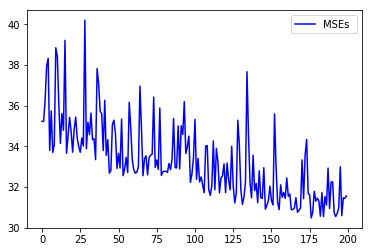

check point at 2019-04-25 18:59:58.288849
training : 潮州
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 7s - loss: 0.0019 - 

Epoch : 39, MSE : [41.755315076678855]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 2s - loss: 0.0013 - val_loss: 0.0012
Epoch : 40, MSE : [40.760255947410876]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 41, MSE : [40.58701011743157]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 42, MSE : [41.21172694601257]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0014
Epoch : 43, MSE : [46.35657491240909]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 44, MSE : [40.73078076060312]
-------------------------------------------
Train on 21

 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 85, MSE : [40.8753971187092]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 86, MSE : [39.88013578711077]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 87, MSE : [39.67343135042064]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 88, MSE : [39.68287281884861]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 89, MSE : [39.648103142727194]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 90, MSE : [40.217790287145924]
----------------

Epoch : 130, MSE : [40.13213263885781]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 131, MSE : [40.06042650017123]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 132, MSE : [39.52849928632214]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 133, MSE : [39.796089646498096]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 134, MSE : [39.335015996492125]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 135, MSE : [39.34137540255062]
-------------------------------------------
Train

Epoch : 175, MSE : [39.705814781833]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 176, MSE : [39.67838877210484]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 177, MSE : [40.056527166407186]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 178, MSE : [39.53170294105664]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0013
Epoch : 179, MSE : [41.98183040248193]
-------------------------------------------
Train on 21498 samples, validate on 5375 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 180, MSE : [40.46537196474085]
-------------------------------------------
Train on

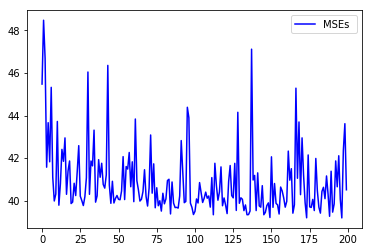

check point at 2019-04-25 19:11:16.192254
training : 美濃
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 6s - loss: 0.0026 - 

Epoch : 39, MSE : [38.874564369605665]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 2s - loss: 0.0016 - val_loss: 0.0016
Epoch : 40, MSE : [38.12131917471436]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0015
Epoch : 41, MSE : [35.992537423413836]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0015
Epoch : 42, MSE : [35.369532015512235]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 2s - loss: 0.0016 - val_loss: 0.0016
Epoch : 43, MSE : [36.19839410453894]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 2s - loss: 0.0016 - val_loss: 0.0015
Epoch : 44, MSE : [34.87941128541024]
-------------------------------------------
Train on 2

 - 2s - loss: 0.0015 - val_loss: 0.0015
Epoch : 85, MSE : [34.97492020551392]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0015
Epoch : 86, MSE : [35.899220601960444]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0015
Epoch : 87, MSE : [35.132511590203876]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0015
Epoch : 88, MSE : [36.01547388025435]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0015
Epoch : 89, MSE : [34.96097547222644]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0015
Epoch : 90, MSE : [34.80029685446499]
---------------

Epoch : 130, MSE : [39.19532553250698]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0015
Epoch : 131, MSE : [35.331169832185545]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0016
Epoch : 132, MSE : [36.54989503678503]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0015
Epoch : 133, MSE : [34.889946081451725]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0015
Epoch : 134, MSE : [35.80172247197961]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0016
Epoch : 135, MSE : [36.01075737314834]
-------------------------------------------
Train

Epoch : 175, MSE : [35.064603182086074]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0015
Epoch : 176, MSE : [35.76914179103116]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0016
Epoch : 177, MSE : [36.119614109740894]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0015
Epoch : 178, MSE : [34.678448625291516]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0015
Epoch : 179, MSE : [34.77219307683193]
-------------------------------------------
Train on 20442 samples, validate on 5111 samples
Epoch 1/1
 - 2s - loss: 0.0015 - val_loss: 0.0015
Epoch : 180, MSE : [34.94288965677568]
-------------------------------------------
Trai

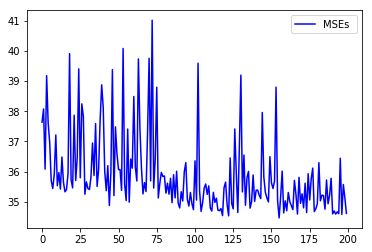

check point at 2019-04-25 19:22:10.941108
training : 鳳山
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_1_input (InputLayer)     (None, 6)                 0         
_________________________________________________________________
dnn_1 (Dense)                (None, 128)               896       
_________________________________________________________________
dnn_2 (Dense)                (None, 64)                8256      
_________________________________________________________________
dnn_3 (Dense)                (None, 32)                2080      
_________________________________________________________________
dnn_4 (Dense)                (None, 1)                 33        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 7s - loss: 0.0017 - 

Epoch : 39, MSE : [31.042629595857775]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 2s - loss: 0.0013 - val_loss: 0.0013
Epoch : 40, MSE : [31.92681504488192]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 2s - loss: 0.0013 - val_loss: 0.0013
Epoch : 41, MSE : [31.690765219654285]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0013
Epoch : 42, MSE : [30.76141412709076]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0013
Epoch : 43, MSE : [32.840296604835586]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 2s - loss: 0.0013 - val_loss: 0.0014
Epoch : 44, MSE : [33.538914491434696]
-------------------------------------------
Train on 

 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 85, MSE : [30.445094678530275]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 86, MSE : [30.25801681678918]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 87, MSE : [30.50159972236641]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0013
Epoch : 88, MSE : [30.778123446347866]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0013
Epoch : 89, MSE : [31.03825207259941]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0013
Epoch : 90, MSE : [32.810883087985516]
--------------

 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 130, MSE : [29.89621903685012]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0013
Epoch : 131, MSE : [31.044767402501236]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 132, MSE : [30.069307963071125]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0013
Epoch : 133, MSE : [32.49766184415754]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 134, MSE : [30.126997212139482]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 135, MSE : [30.581040080481692]
-------

 - 2s - loss: 0.0012 - val_loss: 0.0013
Epoch : 175, MSE : [31.10617712195107]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 176, MSE : [30.392163930466428]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 177, MSE : [30.462123217656664]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 178, MSE : [30.19689766310295]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0012
Epoch : 179, MSE : [30.865353102354067]
-------------------------------------------
Train on 22400 samples, validate on 5601 samples
Epoch 1/1
 - 2s - loss: 0.0012 - val_loss: 0.0013
Epoch : 180, MSE : [31.031343649822293]
-------

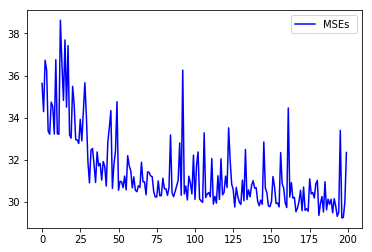

check point at 2019-04-25 19:34:06.951093


In [10]:
import datetime
db=MySQLdb.connect(host="localhost",user="root", passwd="swater0", db="airdb", charset="utf8")
cursor = db.cursor()


epochs = 200
windosSize = 7

stationList = getStationList(cursor)

col=1
for station in stationList:
    print("training : " +station)
    sc, X_train, y_train, X_test, y_test = fetchData(cursor,station,windosSize)
    regressor = buildModel()
    MSEs = train(regressor,sc,X_train, y_train, X_test, y_test,epochs)
    
    book = xlwt.Workbook(encoding="utf-8")
    sheet1 = book.add_sheet("Sheet1")
    writeExcelHead(sheet1,epochs,station)
    row = 1
    for mse in MSEs:
        sheet1.write(row,1,mse)
        row+=1
    book.save("excelFiles/ANN/ANNresult"+station+".xls")
        
    print('check point at ' + str(datetime.datetime.now()))

db.close()


In [5]:
X_train.shape

(21422, 9, 1)